# Week 2 - Counting Words & Phrases (Computational Linguistics)
This week, we take text corpora that we have developed, spidered, scraped, and encoded, and we find and count words, simple and parsed phrases and explore the statistical properties of those counts (e.g., word frequency distributions). Initially, we model how to search corpora for keywords or phrases. Next, we examine the distributions of terms and phrases across a corpus, and the correlation between different words and phrase counts. In order to do this effectively, we coarsely disambiguate words based of part-of-speech (POS) tagging, and normalize them through stemming and lemmatization. Next we distinguish *important* words and phrase within the corpus, and image them with Wordls! Then we calculate word frequenceis, conditional frequences (the frequency of word *shock* conditional on the presence of word *awe*), and statistically significant collocations of lengths 2 through $n$. Finally, we calculate and visualize Differences (Divergences and Distances) between the word frequency distributions from two corpora. 

Then we shift to focus not simply on the *ideas* in a corpus, but also extracting precise *claims*. This process involves a sequential pipeline of classifying and structuring tokens from text, each of which generates potentially useful data for the content analyst. Steps in this process, which we examine in this notebook, include: 1) tagging words by their part of speech (POS) to reveal the linguistic role they play in the sentence (e.g., Verb, Noun, Adjective, etc.); 2) tagging words as named entities (NER) such as places or organizations; 3) structuring or "parsing" sentences into nested phrases that are local to, describe or depend on one another; and 4) extracting informational claims from those phrases.

We will be introducing spaCy as a package for Computational Linguistics, and also walk you through how to use the Davies Corpora. 

While we wish to avoid using NLTK for heavy corpus analysis, some of its smaller functions can still be useful.

Of course, for final projects that draw on these tools, we encourage you to install the software on your own machines or shared servers at the university (RCC, SSRC) in order to perform these operations on much more text. 

For this notebook we will be using the following packages:


In [53]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
import lucem_illud #just in case, regularly update your lucem_illud with the following code: pip install git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#All these packages need to be installed from pip
import requests #for http requests
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import wordcloud #Makes word clouds
import numpy as np #For divergences/distances
import scipy #For divergences/distances
import seaborn as sns #makes our plots look nicer
import sklearn.manifold #For a manifold plot
import json #For API responses
import urllib.parse #For joining urls

# comp-linguistics
import spacy

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook
%matplotlib inline

# Retrieving exemplary corpora

To get started we will need some examples. Let's start by downloading one of the corpuses from the Davies set purchased for this class and developed by a computational linguist at Brigham Young University. We can get a list of works available from the [corpora here](https://www.english-corpora.org/).

In this notebook, I will be accessing the data locally - you also have access to this data through the Dropbox download link. The same code can be modified slighlty to access the rest of the corpora on RCC. 
There is a notebook describing this process in the same repository, as well as in the same directory on RCC.

In [230]:
corpus_name = "/Users/nyjiang/Dropbox/Zips/Movies" 
# corpus_name = "Movies"

Just to be clear, your corpus_name should be different since you're not bhargav. Modify the corpus_name with your directory. This method extracts the text from the zip files and stroes the raw data.

In [231]:
def loadcorpus(corpus_name, corpus_style="text"):
    texts_raw = {}
    for file in os.listdir(corpus_name + "/"):
        if corpus_style in file:
            print(file)
            zfile = zipfile.ZipFile(corpus_name + "/" + file)
            for file in zfile.namelist():
                texts_raw[file] = []
                with zfile.open(file) as f:
                    for line in f:
                        texts_raw[file].append(line)
    return texts_raw

In [232]:
movie_raw = loadcorpus(corpus_name)

text_13_idi.zip
text_16_qll.zip
text_32_ldf.zip
text_19_gvc.zip
text_05_nko.zip
text_17_arp.zip
text_01_ote.zip
text_28_rfy.zip
text_31_akv.zip
text_22_etp.zip
text_11_uoy.zip
text_09_oii.zip
text_06_jfy.zip
text_14_lnc.zip
text_08_loh.zip
text_33_kje.zip
text_30_wkp.zip
text_07_oma.zip
text_03_mnq.zip
text_21_fqa.zip
text_29_oye.zip
text_27_fle.zip
text_23_fmh.zip
text_12_rcq.zip
text_00_myn.zip
text_10_aoy.zip
text_04_mlq.zip
text_20_cde.zip
text_02_mqu.zip
text_26_ngj.zip
text_24_ywo.zip
text_18_jfj.zip
text_25_byg.zip
text_15_guo.zip


In [101]:
fileDic = {'name':[]}
for file in movie_raw:
    fileDic['name'].append(file)
fileDic

{'name': ['13.txt',
  '16.txt',
  '32.txt',
  '19.txt',
  '05.txt',
  '17.txt',
  '01.txt',
  '28.txt',
  '31.txt',
  '22.txt',
  '11.txt',
  '09.txt',
  '06.txt',
  '14.txt',
  '08.txt',
  '33.txt',
  '30.txt',
  '07.txt',
  '03.txt',
  '21.txt',
  '29.txt',
  '27.txt',
  '23.txt',
  '12.txt',
  '00.txt',
  'text_01_ote.zip',
  'text_02_mqu.zip',
  'text_03_mnq.zip',
  'text_04_mlq.zip',
  'text_05_nko.zip',
  'text_06_jfy.zip',
  'text_07_oma.zip',
  'text_08_loh.zip',
  'text_09_oii.zip',
  'text_10_aoy.zip',
  'text_11_uoy.zip',
  'text_12_rcq.zip',
  'text_13_idi.zip',
  'text_14_lnc.zip',
  'text_15_guo.zip',
  'text_16_qll.zip',
  'text_17_arp.zip',
  'text_18_jfj.zip',
  'text_19_gvc.zip',
  'text_20_cde.zip',
  'text_21_fqa.zip',
  'text_22_etp.zip',
  'text_23_fmh.zip',
  'text_24_ywo.zip',
  'text_25_byg.zip',
  'text_26_ngj.zip',
  'text_27_fle.zip',
  'text_28_rfy.zip',
  'text_29_oye.zip',
  'text_30_wkp.zip',
  'text_31_akv.zip',
  'text_32_ldf.zip',
  'text_33_kje.zip',

In [6]:
movie_raw['11.txt'][0:3]

[b'\r\n',
 b'@@216680 Hey , I \'m talking to you Give me 600 dollars You wish ! That \'s all we \'ve left And you still go to gamble Shut up I earn the money Even that you ca n\'t take it for gamble Shut up What \'re you doing ? Bastard , I \'m gon na beat you You gambling pig , I \'ll beat the shit out of you You bitch I \'ll beat you You dare to hit me with something ! I \'ll kill you All you know is gambling I \'ll beat you What \'re you doing ? Let go of me Stop You \'ll kill Mom Mom , are you all right ? Do n\'t touch my money Dad , where \'re you going ? Go away Dad , do n\'t go Get lost Dad , come back You take Marble with you The way she \'s now Do you want to give me trouble ? I \'m in more trouble than you I am a woman I \'m a sailor You take care of Marble Just gamble a bit less is enough to raise the kid No way Raising her would be like raising others @ @ @ @ @ @ @ @ @ @ take care of her Marry her when she grows up And you tell her to be smart Do n\'t marry a gambler Hey , 

It seems messy, but nothing we can't clean. This basic method replaces some of the issues with the formatting, and prints the errors if any for debugging. Let us clean one of the raw text files.

We ignore the non-unicode data for convenience in our first pass.

In [233]:
def clean_raw_text(raw_texts):
    clean_texts = []
    for text in raw_texts:
        try:
            text = text.decode("utf-8")
            clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
            clean_texts.append(clean_text)
        except AttributeError:
            # print("ERROR CLEANING")
            # print(text)
            continue
        except UnicodeDecodeError:
            # print("Unicode Error, Skip")
            continue
    return clean_texts

In [238]:
clean_11 = clean_raw_text(movie_raw['11.txt'])

In [239]:
clean_11[1]

'@@216680 Hey , I\'m talking to you Give me 600 dollars You wish ! That\'s all we\'ve left And you still go to gamble Shut up I earn the money Even that you can\'t take it for gamble Shut up What\'re you doing ? Bastard , I\'m gon na beat you You gambling pig , I\'ll beat the shit out of you You bitch I\'ll beat you You dare to hit me with something ! I\'ll kill you All you know is gambling I\'ll beat you What\'re you doing ? Let go of me Stop You\'ll kill Mom Mom , are you all right ? Don\'t touch my money Dad , where\'re you going ? Go away Dad , don\'t go Get lost Dad , come back You take Marble with you The way she\'s now Do you want to give me trouble ? I\'m in more trouble than you I am a woman I\'m a sailor You take care of Marble Just gamble a bit less is enough to raise the kid No way Raising her would be like raising others @ @ @ @ @ @ @ @ @ @ take care of her Marry her when she grows up And you tell her to be smart Don\'t marry a gambler Hey , you want a quarrel ? No , never

This method cleaned a few basic formatting errors. You are welcome to experiment and add your own code to expand on cleaning the text. Once it begins to look the way you want it to, we can start using spaCy to do some heavier cleaning. spaCy does this through the use of language models. Make sure you have the spaCy english language model loaded. 

In [234]:
nlp = spacy.load("en_core_web_sm")

This model is going to be the basis of most of the tasks which NLTK (the Natural Language Tool Kit) might have done otherwise. While NLTK uses a bunch of clunky models from multiple places, spacy neatly packs all functionality in one model. This deep trained model will start by doing our word tokenizing and normalising. These methods are already included in lucem illud, and here we will just demonstrate them outside the package so to explain what goes on under the hood.

When we run text through a spacy model, it performs a lot of computation on each of the tokens. Each token is given certain attributes, such as a part of speech, information whether it is a number, a stop word, and so on. 

To perform a tokenization, we check if the string includes punctuation and add this token. 

In [235]:
def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [240]:
clean_11[1]

'@@216680 Hey , I\'m talking to you Give me 600 dollars You wish ! That\'s all we\'ve left And you still go to gamble Shut up I earn the money Even that you can\'t take it for gamble Shut up What\'re you doing ? Bastard , I\'m gon na beat you You gambling pig , I\'ll beat the shit out of you You bitch I\'ll beat you You dare to hit me with something ! I\'ll kill you All you know is gambling I\'ll beat you What\'re you doing ? Let go of me Stop You\'ll kill Mom Mom , are you all right ? Don\'t touch my money Dad , where\'re you going ? Go away Dad , don\'t go Get lost Dad , come back You take Marble with you The way she\'s now Do you want to give me trouble ? I\'m in more trouble than you I am a woman I\'m a sailor You take care of Marble Just gamble a bit less is enough to raise the kid No way Raising her would be like raising others @ @ @ @ @ @ @ @ @ @ take care of her Marry her when she grows up And you tell her to be smart Don\'t marry a gambler Hey , you want a quarrel ? No , never

In [241]:
word_tokenize(clean_11[1])

['@@216680',
 'Hey',
 'I',
 "'m",
 'talking',
 'to',
 'you',
 'Give',
 'me',
 '600',
 'dollars',
 'You',
 'wish',
 'That',
 "'s",
 'all',
 'we',
 "'ve",
 'left',
 'And',
 'you',
 'still',
 'go',
 'to',
 'gamble',
 'Shut',
 'up',
 'I',
 'earn',
 'the',
 'money',
 'Even',
 'that',
 'you',
 'ca',
 "n't",
 'take',
 'it',
 'for',
 'gamble',
 'Shut',
 'up',
 'What',
 "'re",
 'you',
 'doing',
 'Bastard',
 'I',
 "'m",
 'gon',
 'na',
 'beat',
 'you',
 'You',
 'gambling',
 'pig',
 'I',
 "'ll",
 'beat',
 'the',
 'shit',
 'out',
 'of',
 'you',
 'You',
 'bitch',
 'I',
 "'ll",
 'beat',
 'you',
 'You',
 'dare',
 'to',
 'hit',
 'me',
 'with',
 'something',
 'I',
 "'ll",
 'kill',
 'you',
 'All',
 'you',
 'know',
 'is',
 'gambling',
 'I',
 "'ll",
 'beat',
 'you',
 'What',
 "'re",
 'you',
 'doing',
 'Let',
 'go',
 'of',
 'me',
 'Stop',
 'You',
 "'ll",
 'kill',
 'Mom',
 'Mom',
 'are',
 'you',
 'all',
 'right',
 'Do',
 "n't",
 'touch',
 'my',
 'money',
 'Dad',
 'where',
 "'re",
 'you',
 'going',
 'Go',
 'a

You can see how the sentence is broken into its constituent words. We can then do some analysis with this. 

Note: we still don't know which movie this is, just that it is raw movie text data. Maybe in the process of our text cleaning and counting we will come across something!

# Counting words

If we want to do some analysis we can start by simply counting the number of times each word occurs within the corpus.

In [236]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pandas.DataFrame(countsForFrame)

In [242]:
countedWords = wordCounter(word_tokenize(clean_11[1]))
countedWords[:10]

word  count
0  @@216680      1
1       hey     16
2         i    191
3        'm     24
4   talking      2
5        to    112
6       you    302
7      give     14
8        me     82
9       600      1

Lets sort and plot our counts to investigate the shape of our word frequency distribution.

First we need to sort the words by count.

In [243]:
#Doing this in place (changing the original DataFrame) as we don't need the unsorted DataFrame
countedWords.sort_values('count', ascending=False, inplace=True)
countedWords[:100]

word  count
6        you    302
2          i    191
13        's    126
5         to    112
31        it    109
..       ...    ...
248  postman     10
187   please      9
328      but      9
215       as      9
135      say      9

[100 rows x 2 columns]

Punctuation and very common words (articles 'a' and 'the'; prepositions 'of' and 'to') make up the most common values, but this isn't very interesting and can actually get in the way of our analysis. We may remove these 'function words' by removing according to a stopword list, setting some frequency threshold, or using a weighting scheme (like tf.idf) to decrease their influence - we will look at these methods in more detail as we go through this tutorial. 

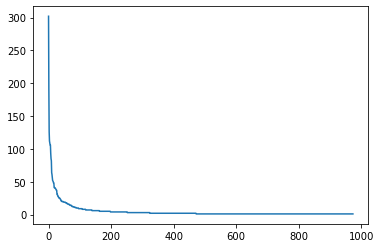

In [244]:
#Creating a figure and axis lets us do things like change the scaling or add a title
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
plt.show()

This shows that likelihood of a word occurring is inversely proportional to its rank. This effect is called [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law), and suggests that the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, etc. Zipf's law is most easily observed by plotting the data on a log-log graph, with the axes being log (rank order) and log (frequency) resulting in a linear relationship.

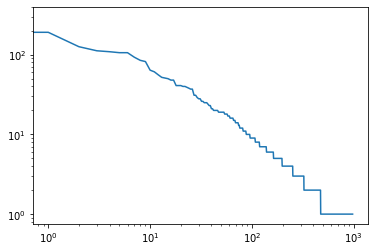

In [245]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

(The same relationship occurs in many other rankings, such as population ranks of cities, corporation sizes, income rankings, etc.) 

The distribution was imagined by Zipf to be driven by a principle of 'least effort' where speakers did not work any harder than necessary to communicate a given idea, but the basis for this relationship is still not well understood and conforms at least as well to a process of [preferential attachment](https://en.wikipedia.org/wiki/Preferential_attachment) whereby people disproportionately attend to popular words.


# Getting and working with raw text

First, we will retrieve a collection of press releases from a *GitHub API* that archived them, based on a number of analyses by Justin Grimmer, a political scientist whose work we will read in two weeks!

GitHub API requests are made to `'https://api.github.com/'` and responses are in JSON, similar to Tumblr's API.

We will get the information on [github.com/lintool/GrimmerSenatePressReleases](https://github.com/lintool/GrimmerSenatePressReleases) as it contains a nice set documents.

In [22]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases')
senateReleasesData = json.loads(r.text)
print(senateReleasesData.keys())
print(senateReleasesData['description'])

dict_keys(['id', 'node_id', 'name', 'full_name', 'private', 'owner', 'html_url', 'description', 'fork', 'url', 'forks_url', 'keys_url', 'collaborators_url', 'teams_url', 'hooks_url', 'issue_events_url', 'events_url', 'assignees_url', 'branches_url', 'tags_url', 'blobs_url', 'git_tags_url', 'git_refs_url', 'trees_url', 'statuses_url', 'languages_url', 'stargazers_url', 'contributors_url', 'subscribers_url', 'subscription_url', 'commits_url', 'git_commits_url', 'comments_url', 'issue_comment_url', 'contents_url', 'compare_url', 'merges_url', 'archive_url', 'downloads_url', 'issues_url', 'pulls_url', 'milestones_url', 'notifications_url', 'labels_url', 'releases_url', 'deployments_url', 'created_at', 'updated_at', 'pushed_at', 'git_url', 'ssh_url', 'clone_url', 'svn_url', 'homepage', 'size', 'stargazers_count', 'watchers_count', 'language', 'has_issues', 'has_projects', 'has_downloads', 'has_wiki', 'has_pages', 'forks_count', 'mirror_url', 'archived', 'disabled', 'open_issues_count', 'lic

What we are interested in here is the `'contents_url'`

In [23]:
print(senateReleasesData['contents_url'])

https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/{+path}


We can use this to get any or all of the files from the repo.

In [24]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse')
whitehouseLinks = json.loads(r.text)
whitehouseLinks[0]

{'name': '10Apr2007Whitehouse123.txt',
 'path': 'raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'sha': 'f524289ee563dca58690c8d36c23dce5dbd9962a',
 'size': 2206,
 'url': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse/10Apr2007Whitehouse123.txt?ref=master',
 'html_url': 'https://github.com/lintool/GrimmerSenatePressReleases/blob/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'git_url': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
 'download_url': 'https://raw.githubusercontent.com/lintool/GrimmerSenatePressReleases/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'type': 'file',
 '_links': {'self': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse/10Apr2007Whitehouse123.txt?ref=master',
  'git': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
  'html': 'https:/

Now we have a list of information about Whitehouse press releases. Let's look at one of them.

In [25]:
r = requests.get(whitehouseLinks[0]['download_url'])
whitehouseRelease = r.text
print(whitehouseRelease[:1000])
len(whitehouseRelease)

SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY IN PUSH FOR STEM CELL RESEARCH
  Sharing the story of Lila Barber, a 12 year old girl from Westerly, Sen. Sheldon Whitehouse (D-R.I.) on Tuesday, April 10, 2007, illustrated the hope stem cell research can offer in a speech on the Senate floor in favor of legislation to expand federal funding for stem cell research.  
   Whitehouse met Lila two weeks ago. She was diagnosed two years ago with osteosarcoma, a cancerous bone condition, and last year underwent cadaver bone transplant surgery. The procedure saved her leg and is helping her remain cancer-free, but the transplanted tissue will not grow with her and likely will break down over time. Stem cell research, Whitehouse explained, could vastly improve the care of patients like Lila by allowing surgeons to enhance transplants with a patient's own stem cells, which could replace the lost bone and cartilage, or grow entirely new replacement bones and joints. 
   "Stem cell research gives hope

2206

Now we have a string of correctly encoded text. For analysis of its words, next we need to tokenize it, or split it into a sequence of tokens or word instances.

In [26]:
whTokens = word_tokenize(whitehouseRelease)
whTokens[10:30]

['STEM',
 'CELL',
 'RESEARCH',
 'Sharing',
 'the',
 'story',
 'of',
 'Lila',
 'Barber',
 'a',
 '12',
 'year',
 'old',
 'girl',
 'from',
 'Westerly',
 'Sen.',
 'Sheldon',
 'Whitehouse',
 'D']

Previous iterations of the course used `nltk`s tokenizer, but as we saw before, we used spaCy's model (https://spacy.io/api/tokenizer). We intend to avoid using NLTK when we can - for production level code, it is a lot faster and cleaner to use spaCy.

That being said, `nltk` does have some useful methods for quick analysis of small corpora. We will explore a few here, and encourage you to figure out for yourself which other ones might be useful.

To use the list of tokens in `nltk`, and take advantage of functions like `concordance`, shown above, we can convert it into a `Text`.

In [27]:
import nltk

In [28]:
whText = nltk.Text(whTokens)

whitehouseIndex = nltk.text.ConcordanceIndex(whText) 
whitehouseIndex.print_concordance('Whitehouse')

Displaying 5 of 5 matches:
ld girl from Westerly Sen. Sheldon Whitehouse D R.I. on Tuesday April 10 2007 il
ral funding for stem cell research Whitehouse met Lila two weeks ago She was dia
 down over time Stem cell research Whitehouse explained could vastly improve the
s research might help or even cure Whitehouse said Whitehouse also praised the e
 help or even cure Whitehouse said Whitehouse also praised the efforts of Rhode 


*Note* that the `Text` class is for doing rapid, exploratory analysis. It provides an easy interface to many of the operations we want to do, but it does not allow us much control over the particular operations it glosses. When you are doing a more complete analysis, you should be using the module specifically designed for that task instead of the shortcut method `Text` provides, e.g. use  [`collocations` Module](http://www.nltk.org/api/nltk.html#module-nltk.collocations) instead of `.collocations()`.

Now that we have gotten this loaded, let's glance at few features we will delve into more deeply later.

For example, we can find words that statistically tend to occur together and typically have a composite, idiomatic meaning irreducible to the semantics of its component words. We will do this later with more control over exactly how these are identified.

Or we can pick a word (or words) and find what words tend to occur around it.

In [29]:
whText.common_contexts(['stem'])

for_cell on_cells the_cell hope_cell time_cell own_cells joints_cell
of_cell embryonic_cells


We can also just count the number of times the word occurs.

In [30]:
whText.count('cell')

5


We can also plot each time a set of words occurs.

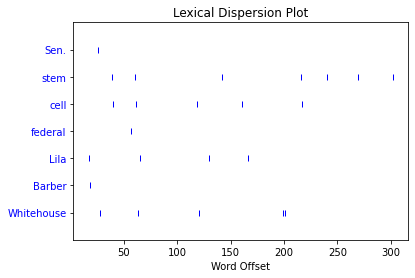

In [31]:
sns.reset_orig() #Seaborn messes with this plot, disabling it
whText.dispersion_plot(['Sen.','stem', 'cell', 'federal' ,'Lila', 'Barber', 'Whitehouse'])
sns.set() #Re-enabling seaborn

If we want to do an analysis of all the Whitehouse press releases we will first need to obtain them. By looking at the API we can see the the URL we want is [https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse](https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse), so we can create a function to scrape the individual files.

If you want to know more about downloading from APIs, refer back to the 1st notebook.

In [113]:
def getGithubFiles(target, maxFiles = 100):
    #We are setting a max so our examples don't take too long to run
    #For converting to a DataFrame
    releasesDict = {
        'name' : [], #The name of the file
        'text' : [], #The text of the file, watch out for binary files
        'path' : [], #The path in the git repo to the file
        'html_url' : [], #The url to see the file on Github
        'download_url' : [], #The url to download the file
    }

    #Get the directory information from Github
    r = requests.get(target)
    filesLst = json.loads(r.text)

    for fileDict in filesLst[:maxFiles]:
        #These are provided by the directory
        releasesDict['name'].append(fileDict['name'])
        releasesDict['path'].append(fileDict['path'])
        releasesDict['html_url'].append(fileDict['html_url'])
        releasesDict['download_url'].append(fileDict['download_url'])

        #We need to download the text though
        text = requests.get(fileDict['download_url']).text
        releasesDict['text'].append(text)

    return pandas.DataFrame(releasesDict)

whReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse', maxFiles = 10)
whReleases[:5]

name  \
0  10Apr2007Whitehouse123.txt   
1    10Apr2008Whitehouse2.txt   
2    10Apr2008Whitehouse3.txt   
3   10Aug2007Whitehouse78.txt   
4   10Jan2008Whitehouse35.txt   

                                                text  \
0  SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...   
1  SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...   
2  EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...   
3  R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...   
4  SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...   

                                        path  \
0  raw/Whitehouse/10Apr2007Whitehouse123.txt   
1    raw/Whitehouse/10Apr2008Whitehouse2.txt   
2    raw/Whitehouse/10Apr2008Whitehouse3.txt   
3   raw/Whitehouse/10Aug2007Whitehouse78.txt   
4   raw/Whitehouse/10Jan2008Whitehouse35.txt   

                                            html_url  \
0  https://github.com/lintool/GrimmerSenatePressR...   
1  https://github.com/lintool/GrimmerSenatePressR...   
2  https://github.com/lintool/GrimmerSenatePressR...   
3  https://github.com/lintool/GrimmerSenatePressR...   
4  https://github.com/lintool/GrimmerSenatePressR...   

                                        download_url  
0  https://raw.githubusercontent.com/lintool/Grim...  
1  https://raw.githubusercontent.com/lintool/Grim...  
2  https://raw.githubusercontent.com/lintool/Grim...  
3  https://raw.githubusercontent.com/lintool/Grim...  
4  https://raw.githubusercontent.com/lintool/Grim...

If you are having trouble downloading the data uncomment this next cell

In [ ]:
#whReleases = pandas.read_csv('../data/whReleases.csv')

Now we have all the texts in a DataFrame we can look at a few things.

First let's tokenize the texts with the same tokenizer as we used before. We will just save the tokens as a list for now; no need to convert to `Text`s.

In [115]:
whReleases['tokenized_text'] = whReleases['text'].apply(lambda x: word_tokenize(x))

Now lets see how long each of the press releases is:

In [116]:
whReleases['word_counts'] = whReleases['tokenized_text'].apply(lambda x: len(x))
whReleases['word_counts']

0    350
1    311
2    497
3    189
4    236
5    334
6    241
7    469
8    443
9    425
Name: word_counts, dtype: int64

## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that input and interrogate a corpus relating to your anticipated final project. This could include one of the Davies corpora or some other you have constructed. Turn your text into an nltk `Text` object, and explore all of the features examined above, and others that relate to better understanding your corpus in relation to your research question. </font>

For this exercise, I will the SOAP dataset.

In [275]:
corpus_name = "/Users/nyjiang/Dropbox/Zips/SOAP"

def loadcorpus(corpus_name, corpus_style="text"):
    texts_raw = {}
    for file in os.listdir(corpus_name + "/"):
        if corpus_style in file:
            print(file)
            zfile = zipfile.ZipFile(corpus_name + "/" + file)
            for file in zfile.namelist():
                texts_raw[file] = []
                with zfile.open(file) as f:
                    for line in f:
                        texts_raw[file].append(line)
    return texts_raw

soap_raw = loadcorpus(corpus_name)

text_7-jss.zip
text_6-egn.zip
text_5-rag.zip
text_2-wts.zip
text_3-pem.zip
text_4-jfy.zip
text_8-sbo.zip
text_9-jtw.zip
text_0-tez.zip
text_1-teh.zip


In [127]:
# take a look at a random txt file
soap_raw['text_6-egn.txt'][0:2]

[b'\r\n',
 b"@@6 @!Ryan: Gillian , you can come back to me now . We can be together again . # @!Mateo: No , the jar is overflowing with names . Yeah . Should I peek ? Yeah ? All right . Let me get a couple . Tatania , Queen of the desert . I like that . It 's nice . Simple . Sebastian . How about Sebastian ? Do I look like a guy that would have a son named Sebastian ? I do n't know . All right . How are you doing ? All right ? Good ? Ok . Call me if you need me , all right ? I 'll be here . All right . I ca n't wait , either . Bye . @!Mateo: Hi . @!Rosa: Hey . @!Mateo: Well , I do n't know what your problem is , but the baby name scheme is working . Did you put your name in ? Did you -- @!Rosa: Yes . I do n't feel like talking , ok ? @!Mateo: Oh . I just adore your moods . @!Rosa: I 'm not in a mood . @!Mateo: Yes , you are @ @ @ @ @ @ @ @ @ @ so pleasantly , too . Do n't break anything , all right ? # @!Rosa: What ? What are you looking at ? @!Gabriel: You . @!Rosa: do n't . @!Gabriel

In [324]:
import cleantext # a module to clean text

In [327]:
# here, I build my own clean text function
def clean_raw_text_new(raw_texts):
    clean_texts = []
    for text in raw_texts:
        try:
            text = text.decode("utf-8")
            # using the cleantext module to clean the text
            clean_text = cleantext.clean(text)
            # check if the string contains nothing or only spaces
            if clean_text and (not clean_text.isspace()):
                clean_texts.append(clean_text)
        except AttributeError:
            # print("ERROR CLEANING")
            # print(text)
            continue
        except UnicodeDecodeError:
            # print("Unicode Error, Skip")
            continue
    return clean_texts

In [328]:
clean_test = clean_raw_text_new(soap_raw['text_6-egn.txt'][0:50])
clean_test[0:4]

['ryan gillian come back togeth mateo jar overflow name yeah peek yeah right let get coupl tatania queen desert like nice simpl sebastian sebastian look like guy would son name sebastian nt know right right good ok call need right right ca nt wait either bye mateo hi rosa hey mateo well nt know problem babi name scheme work put name rosa ye nt feel like talk ok mateo oh ador mood rosa mood mateo ye pleasantli nt break anyth right rosa look gabriel rosa nt gabriel look big favor ask marcu shirt beach ask one fool around rosa gabriel pleas drop pleas gabriel afraid get lie chanc mia sure david mia well mean aw big club go lot peopl david yeah ok phobia crowd mia mia mayb though everyon town think thrown prison head full gray hair david david stori mia sad tale woe weird idea research could gig go mia well resourc mean far concern curiou david go lot peopl stare whole time think handl mia sweat david good wilt pressur got tell someth honey pretti world nt go keep interest past first drink

In [130]:
sentence_tokens = sum([nltk.word_tokenize(x) for x in clean_test], [])
sentence_tokens[0:30]

['ryan',
 'gillian',
 'come',
 'back',
 'togeth',
 'mateo',
 'jar',
 'overflow',
 'name',
 'yeah',
 'peek',
 'yeah',
 'right',
 'let',
 'get',
 'coupl',
 'tatania',
 'queen',
 'desert',
 'like',
 'nice',
 'simpl',
 'sebastian',
 'sebastian',
 'look',
 'like',
 'guy',
 'would',
 'son',
 'name']

In [131]:
# converting raw strings to NLTK Text instances 
whText = nltk.Text(sentence_tokens)
whText

<Text: ryan gillian come back togeth mateo jar overflow...>

In [68]:
Index = nltk.text.ConcordanceIndex(whText)
# Let's see the concordance of the word "damn"
Index.print_concordance('damn')

Displaying 25 of 80 matches:
dr hayward david tell someth mia find damn fascin mia well hotshot doctor circum
 new maker tad nt ok stop nobodi give damn coffe joe tad mean mean go stand pret
nt approach say hey sister pleas give damn mia understand success nt care money 
eah fine sorri caus scene leo greenle damn told stay away wife greenle back leo 
a mmhmm brook okay laurasigh laura oh damn greenle thank never go leo okay reall
dam liza work ryan laveri behind back damn hell happen liza mia well said time t
ook mean nt spend time pine edmund oh damn brook mean edmund know thought past t
n adam bare knew gillian liza go adam damn well go explain liza ryan move adam m
man mayb help forget let go liza know damn well tri steal life adam well nt fasc
th help right complet drain mean take damn long stress tad stress tad tad wake l
anki wait never said nt happi said oh damn bianca franki nt know bianca well nt 
sinlock laura greenle laura leo laura damn hell phoner leo thought told call tel

In [70]:
whText.common_contexts(['mom'])

need_nt see_would see_cri know_could tell_fine yeah_use want_keep
hang_tear rosa_christen sorri_sudden split_crawl think_cri lost_get
ryan_dad bite_laura someth_want know_hospit total_leo laura_pleas
count_wait


In [71]:
whText.count('mom')

155

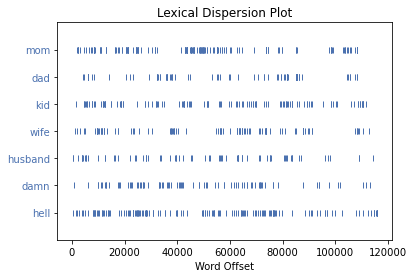

In [74]:
sns.reset_orig() #Seaborn messes with this plot, disabling it
whText.dispersion_plot(['mom','dad', 'kid', 'wife' ,'husband', 'damn', 'hell'])
sns.set() #Re-enabling seaborn

An interesting pattern here is that "mom" is more frequently appeared than "dad" in this corpus!

In [77]:
# Distributional similarity: find other words which appear in the same contexts as the specified word
whText.similar('brother')

anna know right nt ca david tell thank kill bianca edmund jack ahem
ryan gillian mateo yeah let like call


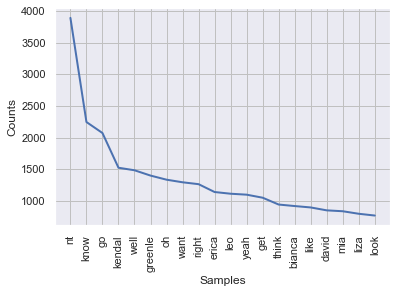

In [78]:
whText.plot(20) # plots 20 most common tokens

In [79]:
whText.vocab()

FreqDist({'nt': 3893, 'know': 2246, 'go': 2072, 'kendal': 1523, 'well': 1483, 'greenle': 1399, 'oh': 1334, 'want': 1293, 'right': 1263, 'erica': 1139, ...})

# Filtering and normalizing text

As we want to start comparing the different releases we may choose to do a bit of filtering and normalizing that will allow us to focus on what we most care about. We can first make all of the words lower case, then drop the non-word tokens. Next, we can remove some 'stop words', stem the remaining words to remove suffixes, prefixes and (in some languages) infixes, or lemmatize tokens by intelligently grouping inflected or variant forms of the same word (e.g., with a stemmer and a dictionary). 

To begin this process, we will first define a function to work over the tokenized lists, then another to add normalized tokens to a new column.

We will be using spaCy's built in stop words identifying capacity. When we run text through spaCy's language pipeline, it automatically tags it as a stop word. 

We can remove these stopwords from the analysis by fiat, but we could also take a more principled approach by looking at the frequency distribution of words and selecting a specific cut-off associated with the preservation of 'meaningful words' identified upon inspection. Alternatively, we could automatically set a cut-off by rule, such as removal of all words more frequent then the most frequent verb, or the most frequent noun (not pronoun), or some term of central interest. 

In [118]:
countsDict = {}
for word in whReleases['tokenized_text'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:20]

[('the', 179),
 ('of', 112),
 ('to', 112),
 ('and', 108),
 ('in', 64),
 ('a', 61),
 ("'s", 50),
 ('that', 41),
 ('our', 39),
 ('for', 35),
 ('on', 33),
 ('is', 33),
 ('Whitehouse', 31),
 ('Iraq', 28),
 ('Bush', 27),
 ('President', 25),
 ('troops', 21),
 ('by', 19),
 ('American', 19),
 ('with', 18)]

We can look at this and pick the cutoff, often at the first noun. So we will cut all words before `'Whitehouse'`.

In [119]:
#The stop list is then all words that occur before the first noun
stop_words_freq = []
for word, count in word_counts:
    if word == 'Whitehouse':
        break
    else:
        stop_words_freq.append(word)
stop_words_freq

['the', 'of', 'to', 'and', 'in', 'a', "'s", 'that', 'our', 'for', 'on', 'is']

If we did have any extra words to add as stop words apart from those normally considered as stop words, we would add it to our stop words by passing it to the normalize tokens method. 

Now we can create our function to normalize the tokens

In [120]:
def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    doc = nlp(word_list.lower())
    
    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

In [121]:
whReleases['normalized_tokens'] = whReleases['tokenized_text'].apply(lambda x: normalizeTokens(x))

whReleases['normalized_tokens_count'] = whReleases['normalized_tokens'].apply(lambda x: len(x))

whReleases

name  \
0  10Apr2007Whitehouse123.txt   
1    10Apr2008Whitehouse2.txt   
2    10Apr2008Whitehouse3.txt   
3   10Aug2007Whitehouse78.txt   
4   10Jan2008Whitehouse35.txt   
5    10Mar2008Whitehouse8.txt   
6   10Sep2007Whitehouse72.txt   
7  11Apr2007Whitehouse122.txt   
8  11Jan2007Whitehouse161.txt   
9    11Mar2008Whitehouse7.txt   

                                                text  \
0  SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...   
1  SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...   
2  EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...   
3  R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...   
4  SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...   
5  SENS. REED, WHITEHOUSE WELCOME RHODE ISLAND ST...   
6  REP. WHITEHOUSE ISSUES STATEMENT ON GEN. PETRA...   
7  SEN. WHITEHOUSE URGES BUSH FOR NEW DIRECTION I...   
8  SENS. REED, WHITEHOUSE URGE PORTUGAL TO RECONS...   
9  WHITEHOUSE UNVEILS 'BUSH DEBT': $7.7 TRILLION ...   

                                        path  \
0  raw/Whitehouse/10Apr2007Whitehouse123.txt   
1    raw/Whitehouse/10Apr2008Whitehouse2.txt   
2    raw/Whitehouse/10Apr2008Whitehouse3.txt   
3   raw/Whitehouse/10Aug2007Whitehouse78.txt   
4   raw/Whitehouse/10Jan2008Whitehouse35.txt   
5    raw/Whitehouse/10Mar2008Whitehouse8.txt   
6   raw/Whitehouse/10Sep2007Whitehouse72.txt   
7  raw/Whitehouse/11Apr2007Whitehouse122.txt   
8  raw/Whitehouse/11Jan2007Whitehouse161.txt   
9    raw/Whitehouse/11Mar2008Whitehouse7.txt   

                                            html_url  \
0  https://github.com/lintool/GrimmerSenatePressR...   
1  https://github.com/lintool/GrimmerSenatePressR...   
2  https://github.com/lintool/GrimmerSenatePressR...   
3  https://github.com/lintool/GrimmerSenatePressR...   
4  https://github.com/lintool/GrimmerSenatePressR...   
5  https://github.com/lintool/GrimmerSenatePressR...   
6  https://github.com/lintool/GrimmerSenatePressR...   
7  https://github.com/lintool/GrimmerSenatePressR...   
8  https://github.com/lintool/GrimmerSenatePressR...   
9  https://github.com/lintool/GrimmerSenatePressR...   

                                        download_url  \
0  https://raw.githubusercontent.com/lintool/Grim...   
1  https://raw.githubusercontent.com/lintool/Grim...   
2  https://raw.githubusercontent.com/lintool/Grim...   
3  https://raw.githubusercontent.com/lintool/Grim...   
4  https://raw.githubusercontent.com/lintool/Grim...   
5  https://raw.githubusercontent.com/lintool/Grim...   
6  https://raw.githubusercontent.com/lintool/Grim...   
7  https://raw.githubusercontent.com/lintool/Grim...   
8  https://raw.githubusercontent.com/lintool/Grim...   
9  https://raw.githubusercontent.com/lintool/Grim...   

                                      tokenized_text  word_counts  \
0  [SEN, WHITEHOUSE, SHARES, WESTERLY, GIRL, 'S, ...          350   
1  [SEN, WHITEHOUSE, SAYS, PRESIDENT, BUSH, MUST,...          311   
2  [EPA, MUST, REVIEW, LEGAL, PROCESS, TO, ROOT, ...          497   
3  [R.I., SENATORS, PRAISE, SEN, DENIAL, OF, LNG,...          189   
4  [SEN, WHITEHOUSE, COMMENTS, ON, ONE, YEAR, ANN...          236   
5  [SENS, REED, WHITEHOUSE, WELCOME, RHODE, ISLAN...          334   
6  [REP, WHITEHOUSE, ISSUES, STATEMENT, ON, GEN, ...          241   
7  [SEN, WHITEHOUSE, URGES, BUSH, FOR, NEW, DIREC...          469   
8  [SENS, REED, WHITEHOUSE, URGE, PORTUGAL, TO, R...          443   
9  [WHITEHOUSE, UNVEILS, BUSH, DEBT, $, 7.7, TRIL...          425   

                                   normalized_tokens  normalized_tokens_count  
0  [sen, whitehouse, share, westerly, girl, story...                      224  
1  [sen, whitehouse, say, president, bush, begin,...                      159  
2  [epa, review, legal, process, root, political,...                      298  
3  [r.i, senator, praise, sen, denial, lng, facil...                      116  
4  [sen, whitehouse, comment, year, anniversary, ...                      125  
5  [sens, reed, whitehouse, welcome, rhod

You can see that in the final step of normalizing, we add the lemmatized form of the word. spaCy's built in lemmatizer does this (https://spacy.io/api/lemmatizer). Lemmatization can be thought of as finding the root or the base of the word after removing inflections and other variations of words. Another possible way of finding the roots of words is using NLTK's porting or stemming functionalities, but we will not be getting into them.

Now that it is cleaned we start analyzing the dataset. We can start by finding frequency distributions for the dataset. Lets start looking at all the press releases together. The [`ConditionalFreqDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) class reads in an iterable of tuples, the first element is the condition and the second the focal word. For starters, we will use word lengths as the conditions, but tags or clusters will provide more useful results.

In [122]:
#.sum() adds together the lists from each row into a single list
whcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in whReleases['normalized_tokens'].sum()))

#print the number of words
print(whcfdist.N())

1964


From this we can lookup the distributions of different word lengths

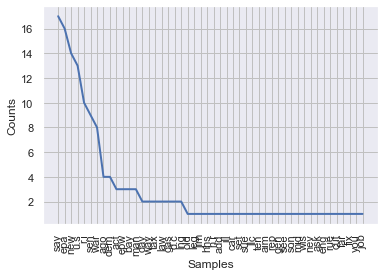

In [85]:
whcfdist[3].plot()

We can also create a Conditional Probability Distribution or [`ConditionalProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) from the `ConditionalFreqDist`. To do this, however, we need a model for the probability distribution. A simple model is [`ELEProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ELEProbDist) which gives the expected likelihood estimate for the probability distribution of the experiment used to generate the observed frequency distribution. 

In [123]:
whcpdist = nltk.ConditionalProbDist(whcfdist, nltk.ELEProbDist)

#print the most common 2 letter word
print(whcpdist[2].max())

#And its probability
print(whcpdist[2].prob(whcpdist[2].max()))

ri
0.25


Length is one feature of a word, but there are many more important features we care about. Another critical feature is a word's role in the sentence, or its part of speech (POS). 

The method below works similarly to ```nltk.pos_text```, and can work with the conditional frequency distributions it provides.

In [124]:
def spacy_pos(word_list):
    tags = []
    doc = nlp(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags

In [125]:
whReleases['normalized_tokens_POS'] = [spacy_pos(t) for t in whReleases['text']]

This gives us a new column with the part of speech as a short initialism and the word in a tuple, exactly how the `nltk.ConditionalFreqDist()` function wants them. We can now construct another conditional frequency distribution.

In [126]:
whcfdist_WordtoPOS = nltk.ConditionalFreqDist(whReleases['normalized_tokens_POS'].sum())
list(whcfdist_WordtoPOS.items())[:10]

[('sen', FreqDist({'NNP': 9})),
 ('.', FreqDist({'.': 127, 'NNP': 39})),
 ('whitehouse', FreqDist({'NN': 27, 'NNP': 13})),
 ('shares', FreqDist({'NNS': 1})),
 ('westerly', FreqDist({'RB': 2})),
 ('girl', FreqDist({'NN': 2})),
 ("'s", FreqDist({'POS': 47, 'VBZ': 5})),
 ('story', FreqDist({'NN': 2})),
 ('in', FreqDist({'IN': 71, 'RP': 1})),
 ('push', FreqDist({'NN': 1}))]

This gives the frequency of each word as each part of speech...which can be uninformative and boring. What we want is the converse; the frequency of each part of speech for each word.

In [127]:
whcfdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in whReleases['normalized_tokens_POS'].sum())

We can now identify and collect all of the superlative adjectives

In [128]:
whcfdist_POStoWord['JJ']

FreqDist({'american': 17, 'new': 10, 'portuguese': 9, 'political': 8, 'federal': 5, 'clear': 5, 'potential': 5, 'fiscal': 5, 'last': 4, 'several': 4, ...})

Or look at the most common nouns

In [129]:
whcfdist_POStoWord['NN'].most_common(5)

[('whitehouse', 27), ('d', 17), ('today', 15), ('stem', 12), ('year', 12)]

Or plot the base form verbs against their number of occurrences

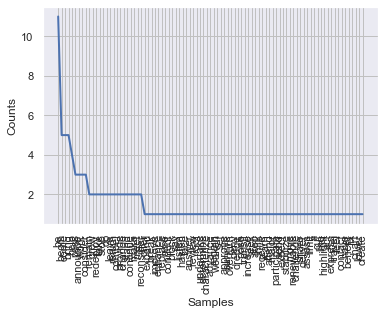

In [93]:
whcfdist_POStoWord['VB'].plot()

We can then do a similar analysis of the word probabilities

In [130]:
whcpdist_POStoWord = nltk.ConditionalProbDist(whcfdist_POStoWord, nltk.ELEProbDist)

#print the most common nouns
print(whcpdist_POStoWord['NN'].max())

#And its probability
print(whcpdist_POStoWord['NN'].prob(whcpdist_POStoWord['NN'].max()))

whitehouse
0.032391048292108364


We can even create a...wait for it...*WORD CLOUD* or Wordl to gaze at and draw mystical, approximate inferences about important nouns and verbs in our corpus:

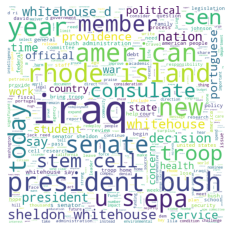

In [95]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(whReleases['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("whitehouse_word_cloud.pdf", format = 'pdf')

## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that filter, stem and lemmatize the tokens in your corpus, and then creates plots (with titles and labels) that map the word frequency distribution, word probability distribution, and at least two conditional probability distributions that help us better understand the social and cultural game underlying the production of your corpus. Create a wordl of words (or normalized words) and add a few vague comments about what mysteries are revealed through it.</font>

Here, I just use one script in the SOAP corpus as a sample to study the underlying patterns.

In [143]:
import itertools
corpus_name = "/Users/nyjiang/Dropbox/Zips/SOAP"
def getFiles(corpus_name, maxFiles = 3):
    #We are setting a max number of files so our examples don't take too long to run
    #For converting to a DataFrame
    releasesDict = {
        'name' : [], #The name of the file
        'text' : [], #The text of the file, watch out for binary files
    }

    #Get the directory informatio
    filesDict = loadcorpus(corpus_name)
    NewFilesDict = dict(itertools.islice(filesDict.items(), maxFiles))

    for k, v in NewFilesDict.items():
        releasesDict['name'].append(k)
        #We need to download the text though
        text = ''.join(clean_raw_text_new(v[0:100]))
        releasesDict['text'].append(text)

    return pandas.DataFrame(releasesDict)

res = getFiles(corpus_name, maxFiles = 1)
res

text_7-jss.zip
text_6-egn.zip
text_5-rag.zip
text_2-wts.zip
text_3-pem.zip
text_4-jfy.zip
text_8-sbo.zip
text_9-jtw.zip
text_0-tez.zip
text_1-teh.zip


name                                               text
0  text_7-jss.txt  report anyth regret experi davidontv well gues...

In [13]:
res.iat[0,1]

'report anyth regret experi davidontv well guess anyth regret fact kept away patient realli need report see futur davidontv well adult life dedic toward heal total exoner look forward get back earliest opportun mean sad disturb chapter life want peopl know hold ill malic toward fals accus tad fals accus glassbreak agent happen tad much sex violenc agent go come budget know tad yeah tax dollar well spent look sorri guy nt even mean know guess nt know strength one minut gone next hell happen wife mateo rick ca nt quit ca nt quit best bartend come rick sorri mateo offer good mateo well match rick nt money mateo rick six month manag bar la mateo well ca nt match rick know blue mateo good luck rick thank get anoth guy mateo right rick take easi mateo right leav apron chri hey mateo mateo hey chri hear need bartend mateo ca nt replac rick institut follow peopl come shot mateo chri avail mateo bj chri think rather work mateo agenc give rick job nt chri well mateo right chri make easier say ye

In [144]:
nlp.max_length = 1315618
res['tokenized_text'] = res['text'].apply(lambda x: word_tokenize(x))
res['word_counts'] = res['tokenized_text'].apply(lambda x: len(x))
res

/Users/nyjiang/.local/lib/python3.8/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


name                                               text  \
0  text_7-jss.txt  report anyth regret experi davidontv well gues...   

                                      tokenized_text  word_counts  
0  [report, anyth, regret, experi, davidontv, wel...       237772

In [145]:
countsDict = {}
for word in res['tokenized_text'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:20]

[('nt', 7752),
 ('know', 4476),
 ('go', 4193),
 ('greenle', 3138),
 ('kendal', 2894),
 ('well', 2700),
 ('want', 2673),
 ('right', 2581),
 ('oh', 2370),
 ('erica', 2249),
 ('get', 2233),
 ('bianca', 2188),
 ('yeah', 1994),
 ('ryan', 1990),
 ('like', 1795),
 ('david', 1722),
 ('think', 1716),
 ('jr', 1607),
 ('tad', 1572),
 ('would', 1542)]

In [146]:
#The stop list is then all words that occur before the first verb
stop_words_freq = []
for word, count in word_counts:
    if word == 'know':
        break
    else:
        stop_words_freq.append(word)
stop_words_freq

['nt']

In [147]:
nlp.max_length = 1315788
def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    doc = nlp(word_list.lower())
    
    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

res['normalized_tokens'] = res['tokenized_text'].apply(lambda x: normalizeTokens(x))

res['normalized_tokens_count'] = res['normalized_tokens'].apply(lambda x: len(x))

res

name                                               text  \
0  text_7-jss.txt  report anyth regret experi davidontv well gues...   

                                      tokenized_text  word_counts  \
0  [report, anyth, regret, experi, davidontv, wel...       237772   

                                   normalized_tokens  normalized_tokens_count  
0  [report, anyth, regret, experi, davidontv, gue...                   206354

For word frequency distribution:

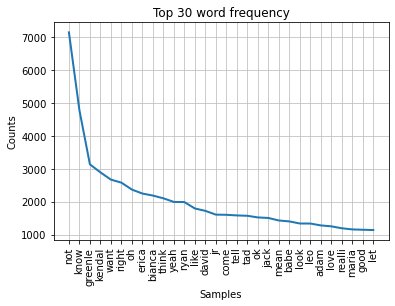

In [56]:
fd = nltk.FreqDist(w for w in res['normalized_tokens'].sum())
fd.plot(30, cumulative = False, title = "Top 30 word frequency")

From here, we see that the most frequently appeared words are "not", "know", and "greenle" (a name).

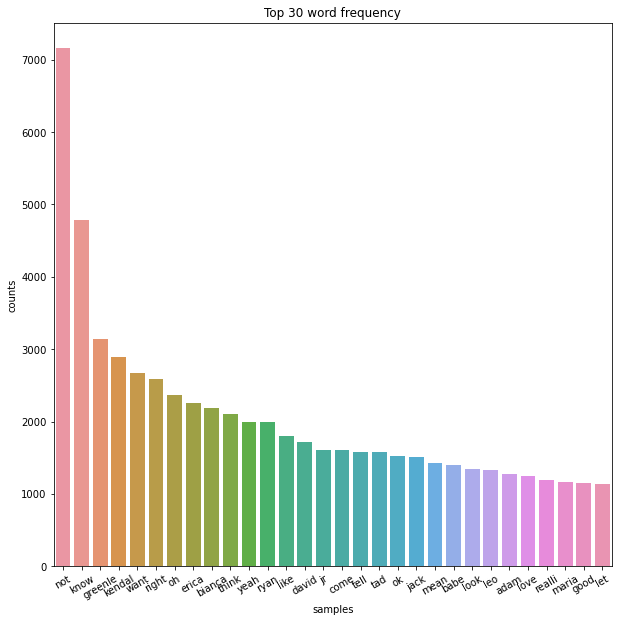

In [58]:
## Creating FreqDist for whole BoW, keeping the 20 most common tokens
all_fdist = fd.most_common(30)

## Conversion to Pandas series via Python Dictionary for easier plotting
all_fdist = pandas.Series(dict(all_fdist))

## Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(10,10))

## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)
all_plot.set(xlabel='samples', ylabel='counts', title = "Top 30 word frequency")
plt.xticks(rotation=30);

(-0.5, 499.5, 499.5, -0.5)

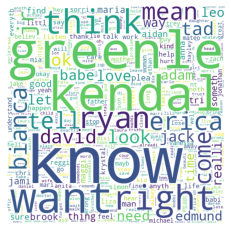

In [59]:
wc_res = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(res['normalized_tokens'].sum()))
plt.imshow(wc_res)
plt.axis("off")

In [66]:
#.sum() adds together the lists from each row into a single list
resdist = nltk.ConditionalFreqDist(((len(w), w) for w in res['normalized_tokens'].sum()))
#print the number of words
print(resdist.N())

206354


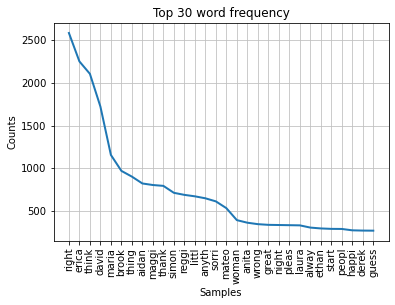

In [67]:
# resdist.plot(30, title = "Top 30 word frequency")
resdist[5].plot(30, title = "Top 30 word with length 5 conditional frequency")

If we calculate the conditional frequency distribution, we will find that the most frequently appeared words are "night", "erica", and "think". The resulst are different from what we directly generate the word frequency distribution.

In [38]:
rescpdist = nltk.ConditionalProbDist(resdist, nltk.ELEProbDist)

#print the most common 2 letter word
print(rescpdist[2].max())

#And its probability
print(rescpdist[2].prob(rescpdist[2].max()))

oh
0.2589578326414682


In [40]:
def spacy_pos(word_list):
    tags = []
    doc = nlp(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags
res['normalized_tokens_POS'] = [spacy_pos(t) for t in res['text']]

In [41]:
resdist_WordtoPOS = nltk.ConditionalFreqDist(res['normalized_tokens_POS'].sum())
list(resdist_WordtoPOS.items())[:10]

[('report', FreqDist({'NN': 27, 'NNP': 8, 'VB': 3, 'VBP': 2})),
 ('anyth', FreqDist({'NNP': 623, 'VB': 15, 'NN': 13})),
 ('regret', FreqDist({'NN': 15, 'JJ': 9, 'NNP': 8, 'VB': 6, 'VBP': 4})),
 ('experi', FreqDist({'NNP': 13, 'JJ': 11})),
 ('davidontv', FreqDist({'NNP': 2})),
 ('well',
  FreqDist({'UH': 1405, 'RB': 966, 'NNP': 182, 'NN': 60, 'IN': 38, 'JJ': 36, 'FW': 6, 'DT': 5, 'CC': 2})),
 ('guess',
  FreqDist({'VBP': 124, 'VB': 88, 'NN': 49, 'NNP': 10, 'JJ': 1, 'UH': 1})),
 ('fact', FreqDist({'NN': 138, 'NNP': 7, 'VBP': 2, 'VB': 1})),
 ('kept', FreqDist({'VBD': 49, 'VBN': 10, 'VB': 4})),
 ('away', FreqDist({'RB': 367, 'RP': 127, 'NNP': 3, 'IN': 1, 'JJ': 1}))]

In [43]:
resdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in res['normalized_tokens_POS'].sum())
resdist_POStoWord['NN'].most_common(5)

[('time', 960), ('babe', 955), ('tad', 898), ('thing', 874), ('love', 702)]

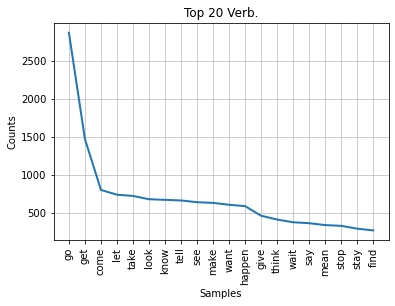

In [69]:
resdist_POStoWord['VB'].plot(20, cumulative=False, title = "Top 20 Verb.")

I find really interesting to know that the most mentioned verbs are "go", "get", and "come".

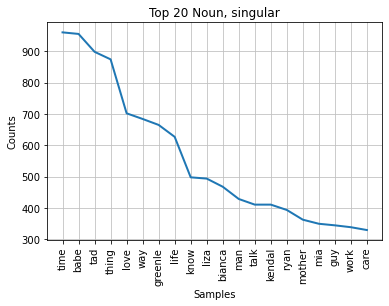

In [70]:
resdist_POStoWord['NN'].plot(20, cumulative=False, title = "Top 20 Noun, singular")

In informal English, words like "babe" and "love"are very frequently used!

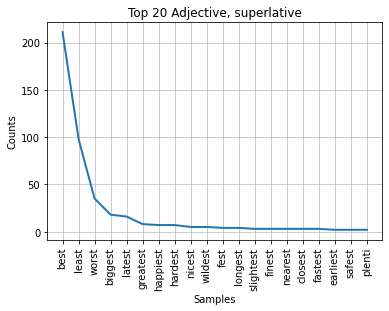

In [71]:
resdist_POStoWord['JJS'].plot(20, cumulative=False, title = "Top 20 Adjective, superlative")

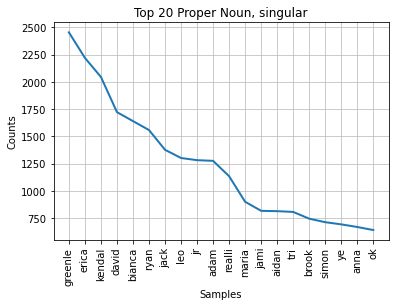

In [72]:
resdist_POStoWord['NNP'].plot(20, cumulative=False, title = "Top 20 Proper Noun, singular")
# find tagging at: https://pythonprogramming.net/part-of-speech-tagging-nltk-tutorial/

Here are some interesting names lol!

## Davies Corpora

Now that we have our basic cleaning down, we can arrange our Davies Corpora. Let us try this with the movies corpora we have already loaded.

We'll use a smaller corpus of a 1000 movies for this demonstration.

In [246]:
zfile = zipfile.ZipFile(corpus_name + "/sources_movies.zip")
source = []

In [247]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [248]:
source[0:20]

[b'textID\tfileID\t#words\tgenre\tyear\tlanguage(s)\tcountry\timdb\ttitle\r\n',
 b'-----\t-----\t-----\t-----\t-----\t-----\t-----\t-----\t-----\r\n',
 b'\r\n',
 b'290635\t3547424\t4722\tShort, Musical\t1930\tUK\tEnglish\t0290635\tGoodbye to All That\r\n',
 b'21165\t6332374\t10220\tCrime, Mystery, Thriller\t1930\tUK\tEnglish\t0021165\tMurder!\r\n',
 b'21191\t6013789\t5281\tDrama, Romance\t1930\tUSA\tEnglish\t0021191\tA Notorious Affair\r\n',
 b'20620\t3660608\t6724\tBiography, Drama, History\t1930\tUSA\tEnglish\t0020620\tAbraham Lincoln\r\n',
 b'20629\t60053\t9552\tDrama, War\t1930\tUSA\tEnglish, French, German, Latin\t0020629\tAll Quiet on the Western Front\r\n',
 b'20640\t6850720\t13862\tComedy, Musical\t1930\tUSA\tEnglish\t0020640\tAnimal Crackers\r\n',
 b'20641\t176501\t11140\tDrama, Romance\t1930\tUSA\tEnglish\t0020641\tAnna Christie\r\n',
 b'20643\t3603861\t1748\tComedy, Short\t1930\tUSA\tEnglish\t0020643\tAnother Fine Mess\r\n',
 b'20670\t4159455\t6966\tComedy, Musical\t1930\tUS

It looks dirty because the file is encoded as bytes, but we can certainly see the information there. The file id is also present in the original raw text data: as the first "word". Look back at the normalized/tokenized words to confirm that. We're going to use this to create a dataframe with: Fileid, movie name, genre, year, and country.

It is advised that you run a similar check of the source file before you do other extraction.

First, let us create a dictionary mapping file-id to all the text. Each movie will be mapped to a list of the tokenized words.

In this example, I only use it to load 100 movies. You can comment this out or increase/decrease the number as you see fit.

Note that in the following cells, we make use of the `lucem_illud` package's `word_tokenize` function. You can see that function on line 70 of [processing.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/processing.py), and we provide the code here for transparency. Since we put this folder in our helper package, you won't need to define this function every time you want to use it; you just `import lucem_illud`!

In [249]:
# processing.py calls a spacy model called "en" (and sometimes called "en_core_web_sm") so we load that first.
try:
    nlp = spacy.load("en")
except OSError:
    nlp = spacy.load("en_core_web_sm")

    
#Here is the function from lucem_illud/lucem_illud/processing.py
def word_tokenize(word_list, model=nlp, MAX_LEN=1500000):
    
    tokenized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 
    # since we're only tokenizing, I remove RAM intensive operations and increase max text size

    model.max_length = MAX_LEN
    doc = model(word_list, disable=["parser", "tagger", "ner"])
    
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [250]:
movie_texts = {}

In [251]:
for files in movie_raw:
    if len(movie_texts) > 100:
        break
    movies = clean_raw_text(movie_raw[files][1:])
    for movie in movies:
        # We can run the following line of code with or without `lucem_illud.`, using the package or our code 2 cells above.
        txts = lucem_illud.word_tokenize(movie)
        try:
            movie_texts[txts[0][2:]] = txts[1:]
        except IndexError:
            continue

/Users/nyjiang/.local/lib/python3.8/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [252]:
import pandas as pd

In [253]:
movie_df = pd.DataFrame(columns=["Movie Name", "Genre", "Year", "Country", "Tokenized Texts"])

In [254]:
for movie in source[3:]:
    try:
        tid, fileid, total_words, genre, year, lang, country, imdb, title = movie.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    try:
        movie_df.loc[fileid.strip()] = [title.strip(), genre.strip(), year.strip(), country.strip(), movie_texts[fileid.strip()]]
    except KeyError:
        continue

In [255]:
movie_df.head(5)

Movie Name            Genre  Year          Country  \
6850720    Animal Crackers  Comedy, Musical  1930          English   
176501       Anna Christie   Drama, Romance  1930          English   
4056770  Ladies of Leisure   Drama, Romance  1930          English   
5992934      Over the Hill            Drama  1931          English   
4436137  Design for Living  Comedy, Romance  1933  English, French   

                                           Tokenized Texts  
6850720  [You, must, do, your, best, tonight, Be, on, y...  
176501   [Either, you, 're, flat, or, I, am, I, beg, yo...  
4056770  [Look, out, There, 's, another, bottle, coming...  
5992934  [Good, morning, kitty, Come, in, here, baby, I...  
4436137  [Train_engine_grinding, 26;1426;TOOLONG, Whist...

# Part-of-Speech (POS) tagging

In POS tagging, we classify each word by its semantic role in a sentence. We will be using the in-built spaCy pos-tagging.

https://spacy.io/usage/linguistic-features

|#. |Tag |Description |
|---|----|------------|
|1.	|CC	|Coordinating conjunction
|2.	|CD	|Cardinal number
|3.	|DT	|Determiner
|4.	|EX	|Existential there
|5.	|FW	|Foreign word
|6.	|IN	|Preposition or subordinating conjunction
|7.	|JJ	|Adjective
|8.	|JJR|	Adjective, comparative
|9.	|JJS|	Adjective, superlative
|10.|	LS	|List item marker
|11.|	MD	|Modal
|12.|	NN	|Noun, singular or mass
|13.|	NNS	|Noun, plural
|14.|	NNP	|Proper noun, singular
|15.|	NNPS|	Proper noun, plural
|16.|	PDT	|Predeterminer
|17.|	POS	|Possessive ending
|18.|	PRP	|Personal pronoun
|19.|	PRP\$|	Possessive pronoun
|20.|	RB	|Adverb
|21.|	RBR	|Adverb, comparative
|22.|	RBS	|Adverb, superlative
|23.|	RP	|Particle
|24.|	SYM	|Symbol
|25.|	TO	|to
|26.|	UH	|Interjection
|27.|	VB	|Verb, base form
|28.|	VBD	|Verb, past tense
|29.|	VBG	|Verb, gerund or present participle
|30.|	VBN	|Verb, past participle
|31.|	VBP	|Verb, non-3rd person singular present
|32.|	VBZ	|Verb, 3rd person singular present
|33.|	WDT	|Wh-determiner
|34.|	WP	|Wh-pronoun
|35.|	WP$	|Possessive wh-pronoun
|36.|	WRB	|Wh-adverb

spaCy pos-tags word as we run it through the english language model. A small example:

In [86]:
sent = nlp(u"Tom went to IKEA to get some of those delicious Swedish meatballs.")


In [87]:
for token in sent:
    print(token.text, token.pos_, token.tag_)

Tom PROPN NNP
went VERB VBD
to ADP IN
IKEA NOUN NN
to PART TO
get VERB VB
some PRON DT
of ADP IN
those DET DT
delicious ADJ JJ
Swedish ADJ JJ
meatballs NOUN NNS
. PUNCT .


This looks quite good. Now we will try POS tagging with a somewhat larger corpus. We consider a few of the top posts from the reddit data we used last week.

In [88]:
redditDF = pandas.read_csv('../data/reddit.csv')

Grabbing the 10 highest scoring posts and tokenizing the sentences. Once again, notice that we aren't going to do any kind of stemming this week (although *semantic* normalization may be performed where we translate synonyms into the same focal word). Here, we will use sentences tokenized by spaCy. Like before, these methods can also be found in `lucem_illud`.



In [91]:
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.text.strip() for sent in doc.sents]
    return sentences

In [92]:
redditTopScores = redditDF.sort_values('score')[-10:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores

/Users/nyjiang/.local/lib/python3.8/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Unnamed: 0                author  over_18  score                subreddit  \
9           8        brenkelieshere    False   9448  Tales From Tech Support   
8           7             Bombadils    False  10528  Tales From Tech Support   
7        1200  whenlifegivesyoushit    False  11003            Relationships   
6           6                sfsdfd    False  11295  Tales From Tech Support   
5           5               Raitaro    False  12372  Tales From Tech Support   
4           4           goldie-gold    False  12650  Tales From Tech Support   
3           3        TheDroolinFool    False  13152  Tales From Tech Support   
2           2     Clickity_clickity    False  13404  Tales From Tech Support   
1           1                SECGaz    False  13724  Tales From Tech Support   
0           0      guitarsdontdance    False  14089  Tales From Tech Support   

                                                text  \
9  Last year, Help Desk got a call from a user co...   
8  First post in quite some time! I work at a loc...   
7  [Original Post](https://www.reddit.com/r/relat...   
6  I witnessed this astounding IT meltdown around...   
5  I work Helpdesk for a retail store chain in th...   
4  This just happened...  So, I had a laptop syst...   
3  Another tale from the out of hours IT desk... ...   
2  [Part 1](http://www.reddit.com/r/talesfromtech...   
1  > $Me  - Hello, IT.   > $Usr - Hi, I am still ...   
0  So my story starts on what was a normal day ta...   

                                               title  \
9  How to fix a laptop that won't boot in under a...   
8                  OK, now the password is 'D35p41r'   
7  [UPDATE]My [26 F] with my husband [29 M] 1 yea...   
6  Company-wide email + 30,000 employees + auto-r...   
5  I'm pretty sure I knocked a user out from near...   
4      Engineer is doing drugs!! No. No they aren't.   
3       "I need you to fix Google Bing immediately!"   
2                   Jack, the Worst End User, Part 4   
1              Hi, I am still off sick but I am not.   
0  "Don't bother sending a tech, I'll be dead by ...   

                                                 url  \
9  https://www.reddit.com/r/talesfromtechsupport/...   
8  https://www.reddit.com/r/talesfromtechsupport/...   
7  https://www.reddit.com/r/relationships/comment...   
6  https://www.reddit.com/r/talesfromtechsupport/...   
5  https://www.reddit.com/r/talesfromtechsupport/...   
4  https://www.reddit.com/r/talesfromtechsupport/...   
3  https://www.reddit.com/r/talesfromtechsupport/...   
2  https://www.reddit.com/r/talesfromtechsupport/...   
1  https://www.reddit.com/r/talesfromtechsupport/...   
0  https://www.reddit.com/r/talesfromtechsupport/...   

                                           sentences  
9  [[Last, year, Help, Desk, got, a, call, from, ...  
8  [[First, post, in, quite, some, time], [I, wor...  
7  [[Original, Post](https://www.reddit.com, r, r...  
6  [[I, witnessed, this, astounding, IT, meltdown...  
5  [[I, work, Helpdesk, for, a, retail, store, ch...  
4  [[This, just, happened], [So, I, had, a, lapto...  
3  [[Another, tale, from, the, out, of, hours, IT...  
2  [[Part, 1](http://www.reddit.com, r, talesfrom...  
1  [[>, $, Me, Hello, IT, >, $, Usr, Hi, I, am, s...  
0  [[So, my, story, starts, on, what, was, a, nor...

In [93]:
def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [94]:
redditTopScores['POS_sents'] = redditTopScores['sentences'].apply(lambda x: tag_sents_pos(x))

In [95]:
redditTopScores['POS_sents']

9    [[(Last, JJ), (year, NN), (Help, NNP), (Desk, ...
8    [[(First, JJ), (post, NN), (in, IN), (quite, P...
7    [[(Original, JJ), (Post](https://www.reddit.co...
6    [[(I, PRP), (witnessed, VBD), (this, DT), (ast...
5    [[(I, PRP), (work, VBP), (Helpdesk, NNP), (for...
4    [[(This, DT), (just, RB), (happened, VBD), (So...
3    [[(Another, DT), (tale, NN), (from, IN), (the,...
2    [[(Part, NNP), (1](http://www.reddit.com, CD),...
1    [[(>, XX), ($, $), (Me, PRP), (Hello, UH), (IT...
0    [[(So, RB), (my, PRP$), (story, NN), (starts, ...
Name: POS_sents, dtype: object

And count the number of `NN` (nouns)

In [96]:
countTarget = 'NN'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('password', 22),
 ('time', 14),
 ('computer', 13),
 ('lot', 12),
 ('life', 11),
 ('email', 11),
 ('system', 10),
 ('laptop', 9),
 ('message', 9),
 ('day', 9),
 ('auto', 9),
 ('call', 8),
 ('office', 8),
 ('part', 8),
 ('today', 8),
 ('story', 8),
 ('user', 7),
 ('job', 7),
 ('something', 7),
 ('problem', 7)]

What about the adjectives that modify the word, "computer"?

In [97]:
NTarget = 'JJ'
Word = 'computer'
NResults = set()
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)     

{'own', 'unrestricted'}


## <font color="red">Exercise 3</font>

<font color="red">In the cells immediately following, perform POS tagging on a meaningful (but modest) subset of a corpus associated with your final project. Examine the list of words associated with at least three different parts of speech. Consider conditional associations (e.g., adjectives associated with nouns or adverbs with verbs of interest). What do these distributions suggest about your corpus?

Continuing to discover the SOAP corpus that we have seen in the Exercise 2, I will use the same subset of the corpus to do the practice here. 

In [201]:
soap = "/Users/nyjiang/Dropbox/Zips/SOAP"
def getFiles(corpus_name, maxFiles = 3):
    #We are setting a max number of files so our examples don't take too long to run
    #For converting to a DataFrame
    releasesDict = {
        'name' : [], #The name of the file
        'text' : [], #The text of the file, watch out for binary files
    }

    #Get the directory informatio
    filesDict = loadcorpus(corpus_name)
    NewFilesDict = dict(itertools.islice(filesDict.items(), maxFiles))

    for k, v in NewFilesDict.items():
        releasesDict['name'].append(k)
        #We need to download the text though
        text = ''.join(clean_raw_text(v[0:100]))
        releasesDict['text'].append(text)

    return pandas.DataFrame(releasesDict)

res2 = getFiles(soap, maxFiles = 1)
res2

text_7-jss.zip
text_6-egn.zip
text_5-rag.zip
text_2-wts.zip
text_3-pem.zip
text_4-jfy.zip
text_8-sbo.zip
text_9-jtw.zip
text_0-tez.zip
text_1-teh.zip


name                                               text
0  text_7-jss.txt  report anyth regret experi davidontv well gues...

In [203]:
nlp.max_length = 2055770
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.text.strip() for sent in doc.sents]
    return sentences
res2['sentences'] = res2['text'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])

/Users/nyjiang/.local/lib/python3.8/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [204]:
nlp.max_length = 2055977
res2['POS_sents'] = res2['sentences'].apply(lambda x: tag_sents_pos(x))

In [107]:
res2['POS_sents']

0    [[(must, MD), (best, RBS), (tonight, NN), (toe...
Name: POS_sents, dtype: object

In [108]:
countTarget = 'NN'
targetCounts = {}
for entry in res2['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('time', 1633),
 ('thing', 1244),
 ('man', 1239),
 ('way', 1058),
 ('night', 879),
 ('love', 774),
 ('day', 759),
 ('girl', 692),
 ('talk', 686),
 ('boy', 659),
 ('ye', 648),
 ('minut', 647),
 ('thank', 588),
 ('life', 574),
 ('know', 563),
 ('work', 558),
 ('year', 550),
 ('place', 538),
 ('mother', 538),
 ('friend', 512)]

In [109]:
countTarget = 'NNS'
targetCounts = {}
for entry in res2['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('pleas', 780),
 ('men', 431),
 ('cours', 333),
 ('els', 327),
 ('hors', 243),
 ('gentlemen', 234),
 ('children', 163),
 ('women', 135),
 ('majesti', 128),
 ('feet', 120),
 ('sens', 85),
 ('wors', 83),
 ('simpl', 81),
 ('danc', 81),
 ('respons', 73),
 ('judg', 63),
 ('babi', 61),
 ('nurs', 44),
 ('aliv', 42),
 ('privat', 40)]

"Men" were mentioned more times than "Women".

In [110]:
countTarget = 'JJ'
targetCounts = {}
for entry in res2['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('good', 2073),
 ('right', 1516),
 ('old', 763),
 ('much', 584),
 ('last', 558),
 ('nice', 468),
 ('big', 458),
 ('sure', 446),
 ('morn', 445),
 ('hous', 419),
 ('long', 416),
 ('great', 414),
 ('first', 409),
 ('marri', 396),
 ('new', 393),
 ('dear', 380),
 ('bad', 366),
 ('enough', 331),
 ('someth', 295),
 ('dead', 291)]

Many Adj. in the SOAP episode were positive words like "good", "right", "nice".

In [111]:
countTarget = 'VB'
targetCounts = {}
for entry in res2['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('go', 3394),
 ('get', 2965),
 ('come', 2061),
 ('see', 1564),
 ('take', 1441),
 ('let', 1222),
 ('tell', 1214),
 ('look', 1208),
 ('make', 928),
 ('give', 879),
 ('know', 805),
 ('say', 777),
 ('want', 682),
 ('think', 671),
 ('happen', 653),
 ('wait', 576),
 ('keep', 479),
 ('find', 433),
 ('ask', 433),
 ('stay', 379)]

In [368]:
NTarget = 'JJ'
Word = 'babe'
NResults = set()
for entry in res2['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)   

{'polic', 'shred', 'full', 'yellow', 'young', 'lizalaugh', 'knew', 'slept', 'fine', 'twice', 'kid', 'krystal', 'dead', 'sudden', 'potshot', 'enough', 'old', 'green', 'good', 'ok', 'much', 'know', 'promis', 'difficult', 'special', 'hous', 'proud', 'cool', 'loud', 'due', 'secret', 'well', 'great', 'clear', 'live', 'open', 'right', 'choic', 'suspect', 'particular', 'jami', 'ounc', 'mean', 'marri', 'calm', 'actual', 'late', 'safe', 'serious', 'applic', 'quiet', 'swear', 'groceri', 'somewher', 'sick', 'perfect', 'buddi', 'second', 'long', 'other', 'glad', 'close', 'stupid', 'mirag', 'hurt', 'morn', 'togeth', 'hot', 'offici', 'stuck', 'sure', 'straight', 'easi', 'upset', 'wrong', 'opal', 'byeby', 'selfish', 'cute'}


In [369]:
NTarget = 'NNS'
Word = 'good'
NResults = set()
for entry in res2['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)   

{'pleas', 'sens', 'respons'}


Overall, we can see that in this corpus, things are pretty much possitive. 

# Collocations

As illustrated above, we might want to find significant bigrams (two-word phrases), trigrams (three-word phrases), n-grams (*n*-word phrases) or skip-grams (noncontinguous 'phrases' with skip-length *n*). 

We will begin with the [`nltk.collocations.BigramCollocationFinder`](http://www.nltk.org/api/nltk.html?highlight=bigramcollocationfinder#nltk.collocations.BigramCollocationFinder) class, which can be given raw lists of strings with the `from_words()` method. By default it only looks at continuous bigrams but there is an option (`window_size`) to allow skip-grams.

In [131]:
whBigrams = nltk.collocations.BigramCollocationFinder.from_words(whReleases['normalized_tokens'].sum())
print("There are {} bigrams in the finder".format(whBigrams.N))

There are 1964 bigrams in the finder


To compare the bigrams we need to tell nltk what our score function is. Initially, we will look at the raw counts.

In [132]:
def bigramScoring(count, wordsTuple, total):
    return count

print(whBigrams.nbest(bigramScoring, 10))

[('president', 'bush'), ('rhode', 'island'), ('sheldon', 'whitehouse'), ('stem', 'cell'), ('whitehouse', 'd'), ('d', 'r.i'), ('bush', 'administration'), ('u.s', 'senator'), ('whitehouse', 'say'), ('american', 'people')]


One note about how `BigramCollocationFinder` works. It doesn't use the strings internally.

In [133]:
birgramScores = []

def bigramPrinting(count, wordsTuple, total):
    global birgramScores
    birgramScores.append("The first word is:  {}, The second word is: {}".format(*wordsTuple))
    #Returns None so all the tuples are considered to have the same rank

whBigrams.nbest(bigramPrinting, 10)
print('\n'.join(birgramScores[:10]))

The first word is:  28, The second word is: 31
The first word is:  20, The second word is: 17
The first word is:  12, The second word is: 12
The first word is:  12, The second word is: 40
The first word is:  40, The second word is: 17
The first word is:  17, The second word is: 10
The first word is:  40, The second word is: 17
The first word is:  13, The second word is: 13
The first word is:  31, The second word is: 11
The first word is:  9, The second word is: 24


The words are each given numeric IDs and there is a dictionary that maps the IDs to the words they represent. This is a common performance optimization.

Two words can appear together by chance. Recall from  Manning and Schütze's textbook that a t-value can be computed for each bigram to see how significant the association is. You may also want to try computing the $\chi^2$, likelihood ratio, and pointwise mutual information statistics. 

In [134]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
whBigrams.score_ngrams(bigram_measures.likelihood_ratio)[:40]
# other options include student_t, chi_sq, likelihood_ratio, pmi

[(('rhode', 'island'), 178.42791632631025),
 (('stem', 'cell'), 146.27449459815534),
 (('president', 'bush'), 126.23062149808423),
 (('sheldon', 'whitehouse'), 97.40535043376386),
 (('d', 'r.i'), 84.89634183337617),
 (('united', 'states'), 81.47339960284599),
 (('whitehouse', 'd'), 57.74744623651276),
 (('u.s', 'senator'), 57.03786703770191),
 (('senator', 'sheldon'), 46.93608358543005),
 (('jack', 'reed'), 46.47304595760241),
 (('american', 'people'), 45.62466065629863),
 (('bush', 'administration'), 45.4509557751863),
 (('honor', 'society'), 44.900172381728815),
 (('bring', 'troop'), 43.07951375003984),
 (('cell', 'research'), 41.08298559892974),
 (('d', 'ri'), 39.013185331609264),
 (('potential', 'closing'), 38.17005571163625),
 (('youth', 'program'), 38.17005571163625),
 (('troop', 'home'), 36.666015832295386),
 (('come', 'home'), 36.52029777577777),
 (('epw', 'committee'), 34.315160571201105),
 (('whitehouse', 'say'), 33.09869922194955),
 (('budget', 'resolution'), 32.086787845859

There are a few other available measures

In [135]:
[s for s in dir(bigram_measures) if s[0] != '_']

['chi_sq',
 'dice',
 'fisher',
 'jaccard',
 'likelihood_ratio',
 'mi_like',
 'phi_sq',
 'pmi',
 'poisson_stirling',
 'raw_freq',
 'student_t']

We can also look at trigrams

In [136]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
whTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(whReleases['normalized_tokens'].sum())
whTrigrams.score_ngrams(trigram_measures.student_t)[:20]

[(('sheldon', 'whitehouse', 'd'), 3.1616086893217816),
 (('whitehouse', 'd', 'r.i'), 2.6450850001523705),
 (('bring', 'troop', 'home'), 2.449192549827382),
 (('senator', 'sheldon', 'whitehouse'), 2.448829313992519),
 (('stem', 'cell', 'research'), 2.235917719697493),
 (('u.s', 'senator', 'sheldon'), 2.235832851864714),
 (('senate', 'youth', 'program'), 1.7320171301402933),
 (('united', 'states', 'senator'), 1.7319807585174225),
 (('jack', 'reed', 'd'), 1.7319693830304341),
 (('new', 'direction', 'iraq'), 1.7318496410621351),
 (('rhode', 'island', 'state'), 1.731694575213188),
 (('whitehouse', 'd', 'ri'), 1.731643684876661),
 (('sen', 'sheldon', 'whitehouse'), 1.731404200940063),
 (('reconsider', 'potential', 'closing'), 1.4142080628720362),
 (('responsibility', 'security', 'governance'), 1.4142047631714012),
 (('$', 'foregone', 'surplus'), 1.4142018301041699),
 (('v.', 'epa', 'decide'), 1.4142018301041699),
 (('cell', 'enhancement', 'act'), 1.4142003635705542),
 (('select', 'committee'

Or n-grams (for any number n)

In [137]:
Ngrams = nltk.ngrams(whReleases['normalized_tokens'].sum(), 4)
Counts = {}
for ngram in list(Ngrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 2:
        pass
    else:
        Filtered[key] = Counts[key]
print(Filtered)

{('sen', 'sheldon', 'whitehouse', 'd'): 2, ('sheldon', 'whitehouse', 'd', 'r.i'): 7, ('stem', 'cell', 'research', 'whitehouse'): 2, ('stem', 'cell', 'enhancement', 'act'): 2, ('begin', 'bring', 'troop', 'home'): 2, ('bring', 'troop', 'home', 'iraq'): 2, ('u.s', 'senator', 'sheldon', 'whitehouse'): 5, ('senator', 'sheldon', 'whitehouse', 'd'): 5, ('sheldon', 'whitehouse', 'd', 'ri'): 3, ('whitehouse', 'd', 'ri', 'say'): 2, ('d', 'ri', 'say', 'today'): 2, ('member', 'senate', 'select', 'committee'): 2, ('senate', 'select', 'committee', 'intelligence'): 2, ('california', 'rhode', 'island', 'state'): 2, ('u.s', 'senator', 'jack', 'reed'): 2, ('senator', 'jack', 'reed', 'd'): 2, ('jack', 'reed', 'd', 'r.i'): 2, ('reed', 'd', 'r.i', 'sheldon'): 2, ('d', 'r.i', 'sheldon', 'whitehouse'): 2, ('r.i', 'sheldon', 'whitehouse', 'd'): 2, ('iraq', 'sen', 'sheldon', 'whitehouse'): 2, ('portuguese', 'american', 'citizen', 'rhode'): 2, ('american', 'citizen', 'rhode', 'island'): 2}


Gensim is another important python text processing package which allows us to use collocations, among other cool methods (which we will explore later weeks).

In [138]:
import gensim

In [139]:
bigram = gensim.models.Phrases(whReleases['normalized_tokens'])

In [140]:
texts = [bigram[line] for line in whReleases['normalized_tokens']]

In [141]:
texts[0]

['sen',
 'whitehouse',
 'share',
 'westerly',
 'girl',
 'story',
 'push',
 'stem_cell',
 'research',
 'share',
 'story',
 'lila',
 'barber',
 'year',
 'old',
 'girl',
 'westerly',
 'sen',
 'sheldon_whitehouse',
 'd_r.i',
 'tuesday',
 'april',
 'illustrate',
 'hope',
 'stem_cell',
 'research',
 'offer',
 'speech',
 'senate',
 'floor',
 'favor',
 'legislation',
 'expand',
 'federal',
 'funding',
 'stem_cell',
 'research',
 'whitehouse',
 'meet',
 'lila',
 'week',
 'ago',
 'diagnose',
 'year',
 'ago',
 'osteosarcoma',
 'cancerous',
 'bone',
 'condition',
 'year',
 'undergo',
 'cadaver',
 'bone',
 'transplant',
 'surgery',
 'procedure',
 'save',
 'leg',
 'help',
 'remain',
 'cancer',
 'free',
 'transplanted',
 'tissue',
 'grow',
 'likely',
 'break',
 'time',
 'stem_cell',
 'research',
 'whitehouse',
 'explain',
 'vastly',
 'improve',
 'care',
 'patient',
 'like',
 'lila',
 'allow',
 'surgeon',
 'enhance',
 'transplant',
 'patient',
 'stem_cell',
 'replace',
 'lose',
 'bone',
 'cartilage',


## <font color="red">*Exercise 4*</font>

<font color="red">Construct cells immediately below this that identify statistically significant bigrams, trigrams, quadgrams, higher-order *n*grams and skipgrams. Explore whether these collocations are idiomatic and so irreducible to the semantic sum of their component words. You can do this by examination of conditional frequencies (e.g., what else is 'united' besides the 'United States'). If these phrases are idiomatic, what do they suggest about the culture of the world producing them?

<font color="red">**Stretch**: In Manning and Schütze's textbook, there Section 5.3.2 explores how to use the *t*-test to find words whose co-occurance patterns best distinguish two words. Implement that and use it to explore phrases in your corpus. For instance, you could tell what words come after "America" much more often than after "Iraq"?</font> 

In [166]:
bigrams = nltk.collocations.BigramAssocMeasures()
trigrams = nltk.collocations.TrigramAssocMeasures()
bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(res['normalized_tokens'].sum())
bigramFinder.score_ngrams(bigram_measures.likelihood_ratio)[:40]

[(('will', 'not'), 2175.3040401341223),
 (('pine', 'valley'), 1668.9059682986904),
 (('oh', 'god'), 1154.6595273591515),
 (('not', 'know'), 1031.5897552478318),
 (('not', 'want'), 1005.973729656875),
 (('whoa', 'whoa'), 888.3532403893495),
 (('michael', 'cambia'), 865.5602089701986),
 (('wait', 'wait'), 864.2190147153749),
 (('du', 'pre'), 821.0435094851453),
 (('wait', 'minut'), 771.2263899126687),
 (('juan', 'pablo'), 759.1679353603023),
 (('ms', 'kane'), 613.298006913323),
 (('merri', 'christma'), 551.3826174686247),
 (('leav', 'alon'), 527.4015391748288),
 (('everi', 'singl'), 513.6953853284681),
 (('littl', 'bit'), 508.41543355706995),
 (('dr', 'hayward'), 435.72017523449057),
 (('look', 'like'), 425.43324055751475),
 (('hey', 'hey'), 421.1174052070831),
 (('long', 'time'), 411.8779302521143),
 (('feel', 'like'), 407.19770947243114),
 (('erica', 'oh'), 387.2565097794414),
 (('shh', 'shh'), 371.69533342888866),
 (('chandler', 'enterpris'), 351.6686358197112),
 (('walk', 'away'), 33

In [150]:
# simply order by frequency
bigram_freq = bigramFinder.ngram_fd.items()
bigramFreqTable = pd.DataFrame(list(bigram_freq), columns=['bigram','freq']).sort_values(by='freq', ascending=False)
bigramFreqTable.head().reset_index(drop=True)

bigram  freq
0   (not, know)   693
1   (not, want)   511
2   (will, not)   325
3   (know, not)   290
4  (not, think)   259

This is interesting. It seems that everything is related to "not". In the previous exercise, we find that the most frequently appeared words are almost positive words. From this exercise, it's also possible that a lot of "not" are associated with those good words!

Note that I limit the word types for the first and the second word respectively to find more associations. 

In [157]:
from nltk.corpus import stopwords
#get english stopwords
en_stopwords = set(stopwords.words('english'))
#function to filter for ADJ/NN bigrams
def rightTypes(ngram):
    if '-pron-' in ngram or '' in ngram or ' 'in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word in en_stopwords:
            return False
    acceptable_types = ('JJ', 'JJR', 'JJS')
    second_type = ('NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in acceptable_types and tags[1][1] in second_type:
        return True
    else:
        return False

In [158]:
nltk.download('averaged_perceptron_tagger')
#filter bigrams
filtered_bi = bigramFreqTable[bigramFreqTable.bigram.map(lambda x: rightTypes(x))]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nyjiang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [159]:
filtered_bi[:10]

bigram  freq
6876     (long, time)    72
2124     (littl, bit)    57
2514         (ok, ok)    52
71417   (krystal, oh)    51
6728   (right, thing)    49
5865   (good, friend)    41
30417    (ok, kendal)    41
1963     (right, let)    41
5956     (fine, fine)    41
4216    (ok, greenle)    37

In [163]:
trigramFinder  = nltk.collocations.TrigramCollocationFinder.from_words(res['normalized_tokens'].sum())
trigram_freq = trigramFinder .ngram_fd.items()
trigramFreqTable = pd.DataFrame(list(trigram_freq), columns=['trigram','freq']).sort_values(by='freq', ascending=False)
trigramFreqTable.head().reset_index(drop=True)

trigram  freq
0  (wait, wait, wait)    59
1    (not, know, not)    49
2  (whoa, whoa, whoa)    37
3   (know, not, know)    34
4    (will, not, let)    32

In [175]:
# https://github.com/nicharuc/Collocations/blob/master/Collocations.ipynb
def rightTypesTri(ngram):
    if '-pron-' in ngram or '' in ngram or ' 'in ngram or '  ' in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word in en_stopwords:
            return False
    first_type = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    third_type = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in first_type and tags[2][1] in third_type:
        return True
    else:
        return False
filtered_tri = trigramFreqTable[trigramFreqTable.trigram.map(lambda x: rightTypesTri(x))]
filtered_tri[:10]

trigram  freq
7861         (wait, wait, wait)    59
20938        (whoa, whoa, whoa)    37
4154            (hey, hey, hey)    28
7809         (yeah, yeah, yeah)    16
30470            (god, oh, god)    15
174982          (red, red, red)    14
13463           (shh, shh, shh)    14
18277       (wait, minut, wait)    13
18278      (minut, wait, minut)    11
116328  (wish, merri, christma)    11

In [189]:
freq_bi = filtered_bi[:20].bigram.values
freq_tri = filtered_tri[:20].trigram.values

In [167]:
bigramFinder.apply_freq_filter(20)
bigramPMITable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.pmi)), columns=['bigram','PMI']).sort_values(by='PMI', ascending=False)
bigramPMITable[:10]

bigram        PMI
0              (du, pre)  12.040052
1          (juan, pablo)  11.512100
2      (merri, christma)  11.234742
3             (shh, shh)  10.595868
4         (pine, valley)  10.480982
5  (chandler, enterpris)  10.393231
6          (cell, phone)   9.930248
7             (ms, kane)   9.852784
8            (dna, test)   9.648117
9           (whoa, whoa)   9.464869

In [168]:
trigramFinder.apply_freq_filter(20)
trigramPMITable = pd.DataFrame(list(trigramFinder.score_ngrams(trigrams.pmi)), columns=['trigram','PMI']).sort_values(by='PMI', ascending=False)
trigramPMITable[:10]

trigram        PMI
0    (whoa, whoa, whoa)  18.979250
1       (hey, hey, hey)  13.041460
2    (wait, wait, wait)  12.989528
3      (will, not, let)   8.999154
4   (bianca, not, know)   3.506512
5  (greenle, not, know)   3.308208
6     (know, not, want)   3.288055
7     (know, not, know)   3.142840
8      (not, know, not)   3.089754

In [169]:
pmi_bi = bigramPMITable[:20].bigram.values
pmi_tri = trigramPMITable[:20].trigram.values

In [170]:
bigramTtable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.student_t)), columns=['bigram','t']).sort_values(by='t', ascending=False)
filteredT_bi = bigramTtable[bigramTtable.bigram.map(lambda x: rightTypes(x))]
filteredT_bi[:10]

bigram         t
20     (long, time)  8.275127
32     (littl, bit)  7.503111
69     (fine, fine)  6.282637
70    (krystal, oh)  6.239207
74   (good, friend)  6.160062
94         (ok, ok)  5.654367
97    (good, night)  5.597575
98      (big, deal)  5.591580
109  (right, thing)  5.384729
113    (good, idea)  5.317186

In [176]:
trigramTtable = pd.DataFrame(list(trigramFinder.score_ngrams(trigrams.student_t)), columns=['trigram','t']).sort_values(by='t', ascending=False)
filteredT_tri = trigramTtable[trigramTtable.trigram.map(lambda x: rightTypesTri(x))]
filteredT_tri

trigram         t
0  (wait, wait, wait)  7.680201
2  (whoa, whoa, whoa)  6.082751
4     (hey, hey, hey)  5.290875

In [180]:
t_bi = filteredT_bi[:20].bigram.values
t_tri = filteredT_tri[:20].trigram.values

In [181]:
bigramChiTable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.chi_sq)), columns=['bigram','chi-sq']).sort_values(by='chi-sq', ascending=False)
bigramChiTable.head(20)

bigram         chi-sq
0               (du, pre)  189505.101240
1          (pine, valley)  155753.136941
2           (juan, pablo)  134335.197181
3       (merri, christma)   84323.789932
4            (whoa, whoa)   50806.866489
5              (ms, kane)   44332.344598
6              (shh, shh)   41756.981642
7   (chandler, enterpris)   33598.165742
8           (cell, phone)   25335.553626
9          (everi, singl)   23588.356115
10            (dna, test)   17623.368874
11          (dr, hayward)   16452.285153
12      (michael, cambia)   14297.783092
13          (wait, minut)   10677.440049
14           (littl, bit)    9131.351093
15            (will, not)    9001.819966
16           (leav, alon)    8777.706990
17       (mr, montgomeri)    8218.464519
18           (wait, wait)    7538.819988
19              (oh, god)    6862.926027

In [182]:
trigramChiTable = pd.DataFrame(list(trigramFinder.score_ngrams(trigrams.chi_sq)), columns=['trigram','chi-sq']).sort_values(by='chi-sq', ascending=False)
trigramChiTable.head(20)

trigram        chi-sq
0    (whoa, whoa, whoa)  1.914565e+07
1    (wait, wait, wait)  4.844498e+05
2       (hey, hey, hey)  2.384781e+05
3      (will, not, let)  2.383746e+04
4     (know, not, want)  2.111596e+03
5     (know, not, know)  2.008752e+03
6      (not, know, not)  1.967248e+03
7  (greenle, not, know)  1.881659e+03
8   (bianca, not, know)  1.878103e+03

In [183]:
chi_bi = bigramChiTable[:20].bigram.values
chi_tri = trigramChiTable[:20].trigram.values

In [184]:
bigramLikTable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.likelihood_ratio)), columns=['bigram','likelihood ratio']).sort_values(by='likelihood ratio', ascending=False)
filteredLik_bi = bigramLikTable[bigramLikTable.bigram.map(lambda x: rightTypes(x))]
filteredLik_bi.head(10)

bigram  likelihood ratio
15        (littl, bit)        508.415434
19        (long, time)        411.877930
39        (fine, fine)        253.752731
49         (big, deal)        229.928105
52  (answer, question)        205.915011
57      (good, friend)        196.606700
58        (uncl, jack)        195.934213
59         (new, year)        191.475979
72     (ask, question)        162.482792
74        (leav, town)        161.058307

In [185]:
trigramLikTable = pd.DataFrame(list(trigramFinder.score_ngrams(trigrams.likelihood_ratio)), columns=['trigram','likelihood ratio']).sort_values(by='likelihood ratio', ascending=False)
filteredLik_tri = trigramLikTable[trigramLikTable.trigram.map(lambda x: rightTypesTri(x))]
filteredLik_tri.head(20)

trigram  likelihood ratio
1  (wait, wait, wait)       1873.298937
2  (whoa, whoa, whoa)       1782.267738
8     (hey, hey, hey)        937.419817

In [186]:
lik_bi = filteredLik_bi[:20].bigram.values
lik_tri = filteredLik_tri[:20].trigram.values

In [187]:
bigramsCompare = pd.DataFrame([freq_bi, pmi_bi, t_bi, chi_bi, lik_bi]).T
bigramsCompare.columns = ['Frequency With Filter', 'PMI', 'T-test With Filter', 'Chi-Sq Test', 'Likeihood Ratio Test With Filter']
bigramsCompare

Frequency With Filter                    PMI  T-test With Filter  \
0           (long, time)              (du, pre)        (long, time)   
1           (littl, bit)          (juan, pablo)        (littl, bit)   
2               (ok, ok)      (merri, christma)        (fine, fine)   
3          (krystal, oh)             (shh, shh)       (krystal, oh)   
4         (right, thing)         (pine, valley)      (good, friend)   
5         (good, friend)  (chandler, enterpris)            (ok, ok)   
6           (ok, kendal)          (cell, phone)       (good, night)   
7           (right, let)             (ms, kane)         (big, deal)   
8           (fine, fine)            (dna, test)      (right, thing)   
9          (ok, greenle)           (whoa, whoa)        (good, idea)   
10       (krystal, yeah)         (everi, singl)        (uncl, jack)   
11          (good, time)          (dr, hayward)     (krystal, yeah)   
12         (good, thing)       (mr, montgomeri)       (good, thing)   
13         (good, night)            (year, ago)        (good, time)   
14             (ok, let)            (god, sake)         (new, year)   
15            (ok, babe)     (answer, question)  (answer, question)   
16           (big, deal)         (mr, chandler)        (leav, town)   
17          (want, sure)           (sam, maddi)     (ask, question)   
18          (good, idea)           (littl, bit)          (opal, oh)   
19          (good, good)      (michael, cambia)           (ok, let)   

              Chi-Sq Test Likeihood Ratio Test With Filter  
0               (du, pre)                     (littl, bit)  
1          (pine, valley)                     (long, time)  
2           (juan, pablo)                     (fine, fine)  
3       (merri, christma)                      (big, deal)  
4            (whoa, whoa)               (answer, question)  
5              (ms, kane)                   (good, friend)  
6              (shh, shh)                     (uncl, jack)  
7   (chandler, enterpris)                      (new, year)  
8           (cell, phone)                  (ask, question)  
9          (everi, singl)                     (leav, town)  
10            (dna, test)                    (good, night)  
11          (dr, hayward)                     (good, idea)  
12      (michael, cambia)                    (krystal, oh)  
13          (wait, minut)                       (opal, oh)  
14           (littl, bit)                    (good, thing)  
15            (will, not)                  (krystal, yeah)  
16           (leav, alon)                         (ok, ok)  
17       (mr, montgomeri)                     (good, time)  
18           (wait, wait)                   (right, thing)  
19              (oh, god)                     (want, hurt)

In [188]:
trigramsCompare = pd.DataFrame([freq_tri, pmi_tri, t_tri, chi_tri, lik_tri]).T
trigramsCompare.columns = ['Frequency With Filter', 'PMI', 'T-test With Filter', 'Chi-Sq Test', 'Likeihood Ratio Test With Filter']
trigramsCompare

Frequency With Filter                   PMI  T-test With Filter  \
0        (wait, wait, wait)    (whoa, whoa, whoa)  (wait, wait, wait)   
1        (whoa, whoa, whoa)       (hey, hey, hey)  (whoa, whoa, whoa)   
2           (hey, hey, hey)    (wait, wait, wait)     (hey, hey, hey)   
3        (yeah, yeah, yeah)      (will, not, let)                None   
4            (god, oh, god)   (bianca, not, know)                None   
5           (red, red, red)  (greenle, not, know)                None   
6           (shh, shh, shh)     (know, not, want)                None   
7       (wait, minut, wait)     (know, not, know)                None   
8      (minut, wait, minut)      (not, know, not)                None   
9   (wish, merri, christma)                  None                None   
10     (bianca, mom, erica)                  None                None   
11      (greenle, leo, leo)                  None                None   
12      (erica, oh, bianca)                  None                None   
13        (erica, oh, jack)                  None                None   
14  (kill, michael, cambia)                  None                None   
15       (erica, oh, thank)                  None                None   
16  (erica, bianca, bianca)                  None                None   
17          (leo, leo, leo)                  None                None   
18         (brook, oh, god)                  None                None   
19     (simon, oh, greenle)                  None                None   

             Chi-Sq Test Likeihood Ratio Test With Filter  
0     (whoa, whoa, whoa)               (wait, wait, wait)  
1     (wait, wait, wait)               (whoa, whoa, whoa)  
2        (hey, hey, hey)                  (hey, hey, hey)  
3       (will, not, let)                             None  
4      (know, not, want)                             None  
5      (know, not, know)                             None  
6       (not, know, not)                             None  
7   (greenle, not, know)                             None  
8    (bianca, not, know)                             None  
9                   None                             None  
10                  None                             None  
11                  None                             None  
12                  None                             None  
13                  None                             None  
14                  None                             None  
15                  None                             None  
16                  None                             None  
17                  None                             None  
18                  None                             None  
19                  None                             None

Throughout this comparison, I feel like the PMI and Chi-sq Test are better than the others. 

# Named-Entity Recognition

Named Entity Recognition (NER) is also a classification task, which identifies named objects. 
Like every other part of the pipeline, spaCy also tags words with their tagged entity (https://spacy.io/api/entityrecognizer). You can see the full capacity of what spaCy does by checking out: https://spacy.io/usage/linguistic-features.

For training the identification of such entities, spaCy uses a deep learning model.

Let's try it on a basic sentence:

In [190]:
sent = nlp(u"Tom went to IKEA to get some of those delicious Swedish meatballs.")

In [191]:
for token in sent:
    print(token.text, token.ent_type_)

Tom PERSON
went 
to 
IKEA 
to 
get 
some 
of 
those 
delicious 
Swedish NORP
meatballs 
. 


For only finding ents-

In [192]:
for ent in sent.ents:
    print(ent.text, ent.label_)

Tom PERSON
Swedish NORP


In [193]:
def tag_sents_ner(sentences):
    """
    function which replicates NLTK ner tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for ent in sent.ents:
            pos_sent.append((ent.text, ent.label_))
        pos_sents.append(pos_sent)
    
    return pos_sents

We can also run NER over our entire corpus:

In [194]:
redditTopScores['classified_sents'] = redditTopScores['sentences'].apply(lambda x: tag_sents_ner(x))

In [195]:
redditTopScores['classified_sents']

9    [[(Last year, DATE), (Help Desk, PERSON)], [(a...
8    [[(First, ORDINAL)], [(today, DATE)], [(Citrix...
7    [[], [(about a month, DATE), (a few days ago, ...
6    [[], [(30,000, CARDINAL), (30,000, CARDINAL), ...
5    [[(Helpdesk, PERSON), (UK, GPE)], [], [], [], ...
4    [[], [(Engineer, PERSON), (10 minutes later, T...
3    [[(hours, TIME), (Desk Caller, PERSON)], [], [...
2    [[(1](http://www.reddit.com, CARDINAL), (comme...
1    [[], [], [], [], [], [], [(today, DATE)], [], ...
0    [[(recently past few years, DATE)], [], [], [(...
Name: classified_sents, dtype: object

Find the most common entities (which are, of course, boring):

In [196]:
entityCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[('Jack', 14),
 ('today', 6),
 ('9', 4),
 ('Boss', 4),
 ('Smith', 4),
 ('4', 3),
 ('one', 3),
 ('second', 3),
 ('30,000', 3),
 ('Google Bing', 3)]

Or those occurring only twice:

In [197]:
[x[0] for x in sortedEntities if x[1] == 2]

['two',
 'first',
 '5',
 '10',
 'Edit 2',
 '30k',
 '20',
 'hours',
 'Caller',
 'last week',
 'three',
 'last Thursday']

We could also list the most common "non-objects". (We note that we're not graphing these because there are so few here.)

In [198]:
nonObjCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

[('Jack', 14),
 ('today', 6),
 ('9', 4),
 ('Smith', 4),
 ('4', 3),
 ('one', 3),
 ('second', 3),
 ('30,000', 3),
 ('two', 2),
 ('first', 2)]

What about the Organizations?

In [199]:
OrgCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                print(ent)

HDD
Citrix
R. Computer
Fair
Milestone
Bing Search
Google Chrome
Google Bing
Caller
Boss
Boss
Boss
Bing
Buzzfeed
Boss


These, of course, have much smaller counts.

In this particular example we didn't find the most interesting entities - you can remedy that in exercise 4!

## <font color="red">*Exercise 5*</font>

<font color="red">In the cells immediately following, perform NER on a (modest) subset of your corpus of interest. List all of the different kinds of entities tagged? What does their distribution suggest about the focus of your corpus? For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed.

In [205]:
res2['classified_sents'] = res2['sentences'].apply(lambda x: tag_sents_ner(x))

In [207]:
res2['classified_sents']

0    [[(experi davidontv, PERSON)], [(one, CARDINAL...
Name: classified_sents, dtype: object

In [208]:
entityCounts = {}
for entry in res2['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities_res2 = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities_res2[:20]

[('erica', 1487),
 ('jack', 685),
 ('one', 601),
 ('first', 297),
 ('two', 229),
 ('everyth', 158),
 ('mari', 152),
 ('today', 136),
 ('mayb', 135),
 ('tonight', 132),
 ('michael', 130),
 ('second', 121),
 ('leav', 94),
 ('michael cambia', 93),
 ('anna', 92),
 ('mateo', 88),
 ('laura', 79),
 ('worri', 76),
 ('last night', 65),
 ('joni', 60)]

In [371]:
nonObjCounts = {}
for entry in res2['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

[('erica', 1487),
 ('jack', 685),
 ('one', 601),
 ('first', 297),
 ('two', 229),
 ('mari', 152),
 ('today', 136),
 ('mayb', 135),
 ('tonight', 132),
 ('michael', 130)]

I feel like in this corpus, there are A LOT OF names!

In [209]:
PersonCounts = {}
for entry in res2['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'PERSON':
                print(ent)

experi davidontv
mateo rick
rick sorri mateo
rick
mateo
mateo
rick institut follow
mateo
hung rosa
gabriel rosa
gillian gillian ryan
gillian gillian
leav
everi entranc
mateo
mateo
leav
sorri ca
marcu rosa rosa rosa rosa marcu sorri
rosa marcu
rosa sorri marcu
rustl liza tad come jr eat
sam
idiot jrrememb jr
mani
adam jr
mateo
roosevelt
studi brianna
malanga hondura human
phil ye mateo
phil
mateo
phil phil
gillian gillian liza
rosa whenev
phil
doubt rosa phil
rosa gabriel nt
gabriel cri rosa none
marcu rosa nt
mateo
mateo rosa
mateo
rosa rosa
mateo
rosa gabriel
rosa mateo
gabriel mateo
rosa
mateo
everi
mateo
phil ok gabriel rosa
rosa mateo
rosa ok mateo
mayb
rosa mateo
mateo appar
mateo
derek hayley
mateo
laura
challeng laura
erica chang
pari leo nt
leo greenle
laura
mateo
mateo
mateo
mateo hayley
activ jumpstart
mateo activ
activ activ
babi hayley
bubbl gum cigar
laura
laura
laura
laura
everyth
laura
laura leo
laura
erica
erica
adam adam
deni adam adam
adam leav
adam liza
doorclos adam

erica sorri
erica
erica
erica
erica
leav
erica
erica
erica
erica kane
erica
erica
shut greenle
everi happi
david leo
leo deserv david david probabl nt
marri leo
david leo
leo
leav quietli
hungri mari
soninlaw greenle enviou toothpick
measur compani
anna bianca
sorri greenle
mari ye anna
greenle maryandmaggi
greenle greenle
erica
knockondoor chri mayb
erica
erica
mani time
erica
erica
erica
erica
erica realli
erica ye chri
erica
greenle jazz
david leo
leo greenle
david leo
david leo sorri
david extrem
leo extrem
leo sorri
sorri leo
david leo
anna suspici guy
anna leo
erica
mari
mari
pari greenle
anna
greenle nt
shut greenle penni anna
mari ye
mari
mari
maggi greenle
mari garter
leav
mari
simon honey
sorri sorri
adam ye
sorri nt
xray
anna
anna anna
anna leo
leo anna
anna leo leo
anna anna
languag
mia worri
adam girl colbi
adam mia
compani
everyth
someon deserv
david leo
greenle right comfort
anna
david greenle
roger chacha dirti
anna
anna anna leo
jack problem
derek frye jack necessari d

michael honey
erica
michael choos
michael
erica erica
aidan chri
erica
erica
jealousi insecur caveman
erica
erica
erica
erica
uhoh lee
butt everi
michael anyth
erica
michael
erica
chri erica seriou futur
erica
erica
chang
erica jack
lauri lauri jami
lauri mani
michael least kendal
michael everyon
michael damn
michael
michael mean
michael well
erica
michael excus
erica chri chri
erica
jack
jack
erica jack chri
erica
jack jack look erica
erica
urg jack
erica chri
jack
erica
maggi sorri
lauri jami
joni jr jami
lauri lauri nt
jami nt
jr jami lauri nt
michael take
michael
michael
michael well
michael anyth
leav
erica
everyth
jack ye erica
jack ye ye pleas
erica
jack
erica
jack erica
jack erica
erica ye ye jack
jack
erica
steven nt
jami
lauri mayb
apolog way
michael
sorri boyd
michael
michael
chang
michael
boyd mayb
chang
cambia leav
michael
erica
jackson jack
erica
erica
jack mayb ye look
chang erica erica
erica jack realli
leav jack
erica
jack kind
erica
jack
erica
jack chri
joni
sorri chr

merri christma jr
joe martin
chang
chang
merri merri
erica
jack
erica
jack
erica
merri christma
merri christma
erica
merri christma
erica sweetheart
erica
erica
erica
worri jack
jack
merri christma
longnarr greenle merri
leo toolong
merri christma
merri christma
merri christma
merri christma
merri christma
merri christma
merri christma
merri christma
merri christma
merri christma
powwow jami
mayb
joe jami
chang
stabil
joe maria
joe david
maria temporari
joe david
joe maria call
servic maria ok nt
joe
maria everi
david jr babe
superstrong life forc
adam chandler
michael
everyth
wolf doubt
kendal mayb
joe right manag
joe david clearanc
surgeri maria
joe
joe jami
leav
chang sinc
kendal leav
knockondoor
laveri drlossin
montgomeri
joe
joe time maria
sorri realli nt
sorri nt
babe leav
joe
surgeri brook
michael child
alan
sorri jami
orang jump
sorri maria
paul hack hospit
anyth babe
jack ok
erica
jack honeymoon
erica
jack
erica
jack
erica
jack
jack ok report
jack hell
juri
mayb
erica
erica
pr

materi jr
kevin win jr
kevin jami
erica
routin babe nt
erica bianca
erica ye
erica
erica
erica
babe apolog
erica
chang
everi singl
mayb
jonathan hang nt
mayb
chang number
mayb jonathan
greenle badli
jack
jack tri
greenle hospit jack
jack
jack
ryanconfrontshi toolong
lee
lee googloo
jonathan face
bill bob
erica
sorri bianca
maggi horribl
jonathan bianca
jack
maggi cri
jonathan asham
jack
jack jack surpris
jack
jack
jack
erica darl
erica
erica
greenle mayb
jonathan reggi
jack
worri
jack
jack
juggl maggi
jonathan bianca
chang
routin dad jonathan
jonathan ye
jonathan ryan
jonathan jonathan
leav
jonathan medicin
ace buchanan jr
erica
erica
erica handl
everi minut
activ mani
joe joe maria gone maria
david maria alreadi maria
joe
everyth
mani
ethan cesspool su take
ethan mayb
divorc nt
david david maria
sorri maria zach nt
joe
joe sorri brook
sorri aidan
sorri
mayb leav
jack
someon
jami jr nt
marri babe day
chang mind
babe mayb
mayb
judg mayb da jami
babe divorc
horribl jami
minut realli
mari

In [210]:
NorpCounts = {}
for entry in res2['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'NORP':
                print(ent)

servic
laveri
latin
greenle greenle
unplan
laveri
scan
laveri
servic
servic
italian
crisi
servic
miseri
forev
cortlandt
italian
forev
english
forev
servic
forev
jitteri
european
american
french
crisi
crisi
servic
laveri
eye funni funni
forev
laveri
forev
snuggl
forev
forev
spanish
montgomeri
marian
forev
knowital
english
forev
spanish
seri
forev
julian
julian
julian
french
julian
julian
julian
julian
julian
julian
julian
julian
julian
julian
english
american
kenni
crisi
poetri
spanish
forev
compani
funni maria
anorex
judi
montgomeri
laveri
laveri
laveri
cuban
laveri
french
believ
laveri
english
howev
laveri
forev
servic
greenle everyon manipul
hilari
maria
nightmar
forev
mommi
greenle cours
servic
forev
servic
cuban
laveri
crisi
greenle cold feet
laveri
forev
laveri
forev
laveri
laveri
inadmiss
forev
lesbian
montgomeri
forev
hine
bian
miranda
tibetan
laveri
forev
forev
laveri
american
forev
british
laveri
forev
nanni
laveri
laveri
comeon
laveri
forev
fierc
forev
swiss
nanni
forev
ameri

## Dependency parsing and graph representations

Dependency parsing was developed to robustly capture linguistic dependencies from text. The complex tags associated with these parses are detailed [here]('http://universaldependencies.org/u/overview/syntax.html'). When parsing with the dependency parser, we will work directly from the untokenized text. Note that no *processing* takes place before parsing sentences--we do not remove so-called stop words or anything that plays a syntactic role in the sentence, although anaphora resolution and related normalization may be performed before or after parsing to enhance the value of information extraction. 

We will be using spaCy's built in dependancy parser to go about exploring the tree.
Note that unlike previous examples, large corpuses or collections of sentences don't give us as much information, so we will be navigating smaller sentences.

Let us start by exploring noun chunks. Noun chunks are “base noun phrases” – flat phrases that have a noun as their head. You can think of noun chunks as a noun plus the words describing the noun – for example, “the lavish green grass” or “the world’s largest tech fund”. To get the noun chunks in a document, simply iterate over the sentences noun chunks.

In [211]:
from spacy import displacy

In [212]:
doc = nlp("Autonomous cars shift insurance liability toward manufacturers")

In [213]:
displacy.render(doc, style='dep')

In [214]:
for chunk in doc.noun_chunks:
    print(chunk.text, chunk.root.text, chunk.root.dep_, chunk.root.head.text)

Autonomous cars cars nsubj shift
insurance liability liability dobj shift
manufacturers manufacturers pobj toward


spaCy uses the terms head and child to describe the words connected by a single arc in the dependency tree. The term dep is used for the arc label, which describes the type of syntactic relation that connects the child to the head. As with other attributes, the value of .dep is a hash value. You can get the string value with .dep_.

For your reference:

Text: The original token text.

Dep: The syntactic relation connecting child to head.

Head text: The original text of the token head.

Head POS: The part-of-speech tag of the token head.

Children: The immediate syntactic dependents of the token.

In [215]:
for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])

Autonomous amod cars NOUN []
cars nsubj shift VERB [Autonomous]
shift ROOT shift VERB [cars, liability, toward]
insurance compound liability NOUN []
liability dobj shift VERB [insurance]
toward prep shift VERB [manufacturers]
manufacturers pobj toward ADP []


Because the syntactic relations form a tree, every word has exactly one head. You can therefore iterate over the arcs in the tree by iterating over the words in the sentence. This is usually the best way to match an arc of interest — from below:

In [216]:
from spacy.symbols import nsubj, VERB

In [217]:
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)

{shift}


You can *also* navigate from above. It isn't as efficient though.

In [218]:
verbs = []
for possible_verb in doc:
    if possible_verb.pos == VERB:
        for possible_subject in possible_verb.children:
            if possible_subject.dep == nsubj:
                verbs.append(possible_verb)
                break

In [219]:
print(verbs)

[shift]


### Iterating around the local tree
A few more convenience attributes are provided for iterating around the local tree from the token. Token.lefts and Token.rights attributes provide sequences of syntactic children that occur before and after the token. Both sequences are in sentence order. There are also two integer-typed attributes, Token.n_lefts and Token.n_rights that give the number of left and right children.

In [220]:
doc = nlp("bright red apples on the tree")
print([token.text for token in doc[2].lefts])  # ['bright', 'red']
print([token.text for token in doc[2].rights])  # ['on']
print(doc[2].n_lefts)  # 2
print(doc[2].n_rights)  # 1

['bright', 'red']
['on']
2
1


You can get a whole phrase by its syntactic head using the Token.subtree attribute. This returns an ordered sequence of tokens. You can walk up the tree with the Token.ancestors attribute, and check dominance with Token.is_ancestor

In [221]:
doc = nlp("Credit and mortgage account holders must submit their requests")

root = [token for token in doc if token.head == token][0]
subject = list(root.lefts)[0]
for descendant in subject.subtree:
    assert subject is descendant or subject.is_ancestor(descendant)
    print(descendant.text, descendant.dep_, descendant.n_lefts,
            descendant.n_rights,
            [ancestor.text for ancestor in descendant.ancestors])

Credit nmod 0 2 ['holders', 'submit']
and cc 0 0 ['Credit', 'holders', 'submit']
mortgage compound 0 0 ['account', 'Credit', 'holders', 'submit']
account conj 1 0 ['Credit', 'holders', 'submit']
holders nsubj 1 0 ['submit']


Finally, the .left_edge and .right_edge attributes can be especially useful, because they give you the first and last token of the subtree. This is the easiest way to create a Span object for a syntactic phrase. Note that .right_edge gives a token within the subtree — so if you use it as the end-point of a range, don’t forget to +1!

In [222]:
span = doc[doc[4].left_edge.i : doc[4].right_edge.i+1]
with doc.retokenize() as retokenizer:
    retokenizer.merge(span)
for token in doc:
    print(token.text, token.pos_, token.dep_, token.head.text)

Credit and mortgage account holders NOUN nsubj submit
must AUX aux submit
submit VERB ROOT submit
their PRON poss requests
requests NOUN dobj submit


In [223]:
displacy.render(doc, style='dep')

### Information Extraction

How can dependancy graphs be useful? We can extract information from the sentences based on relationships between words within parsed phrases. Let us see if we can do this to glean any information, from, say, our movies dataset. 

How violent are the movies? Who is killing who?

In [256]:
movie_violences = {}

In [257]:
for index, row in movie_df.iterrows():
    text = ' '.join(row['Tokenized Texts'])
    movie_violences[row['Movie Name']] = ([], [])
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        subject = 0
        object_ = 0
        # if the verb or the root of the sentence is kill
        if chunk.root.head.text == 'kill':
            # we find the subjects and objects around the word, and if it does exist, add it to the tuple
            if chunk.root.dep_ == 'nsubj':
                subject = chunk.root.text
            if chunk.root.dep_ == 'dobj':
                object_ = chunk.root.text
            if subject != 0:
                movie_violences[row['Movie Name']][0].append(subject)
            if object_ != 0:
                movie_violences[row['Movie Name']][1].append(object_)

In [258]:
movie_violences

{'Animal Crackers': ([], []),
 'Anna Christie': (['I'], ['them', 'Glory', 'you']),
 'Ladies of Leisure': ([], []),
 'Over the Hill': (['shalt', 'This'], ['shalt', 'Ma']),
 'Design for Living': ([], []),
 'Lady for a Day': (['It'], ['yourself', 'Louise']),
 'Lady Killer': (['that'], ['horse']),
 'The Mind Reader': (['woman'], ['herself']),
 'Here Is My Heart': ([], ['herself']),
 'Peculiar Penguins': ([], []),
 'Sadie McKee': (['You', 'I'], ['SOBBING', 'you']),
 'Star of Midnight': (['you', 'I', 'They'],
  ['story', 'You', 'him', 'him', 'dal', 'her']),
 'The Littlest Rebel': (['men'], ['army']),
 'The Robber Kitten': ([], []),
 'Charlie Chan at the Circus': (['Holt'], ['sheriff']),
 'Charlie Chan at the Opera': (['I'], ['me', 'him', 'intrusion']),
 'Charlie Chan at the Race Track': (['you'], ['major']),
 'The Prisoner of Shark Island': (['government'], ['husband']),
 'The Prince and the Pauper': ([], ['me']),
 'The Lady Vanishes': (['They'], ['lot']),
 'Holiday': ([], []),
 "Donald's Co

That's pretty neat: we can see who tried to kill who, or at least talked about it. A lot of 'I' killing 'you', as we'd imagine. What else can we see?

The movie, about time, which is about time travel, funnily enough has:
`'About Time': (['I'], ['Hitler'])`

In [262]:
res[0:4]

name                                               text  \
0  text_7-jss.txt  report anyth regret experi davidontv well gues...   

                                      tokenized_text  word_counts  \
0  [report, anyth, regret, experi, davidontv, wel...       237772   

                                   normalized_tokens  normalized_tokens_count  
0  [report, anyth, regret, experi, davidontv, gue...                   206354

## <font color="red">*Exercise 6*</font>

<font color="red">In the cells immediately following, parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceive to play in the social world inscribed by your texts?

Okay, I don't quite understand whether I should analyze a bunch of sentences in my corpus or just select one. Here, I just randomly draw a complicated sentence from my corpus to do the phrase structure.

In [374]:
doc = nlp("I'm just trying to tell you that you did the right thing last night at the Turret.")
displacy.render(doc, style='dep')

In the image above, each token is assigned a POS tag written just below the token. nsubj is the subject of the word. Its headword is a verb. aux is an auxiliary word. Its headword is a verb. dobj is the direct object of the verb. Its headword is a verb.

In [380]:
for chunk in doc.noun_chunks:
    print(chunk.text, chunk.root.text, chunk.root.dep_, chunk.root.head.text)

anyth regret experi experi nsubj guess
anyth regret fact fact nsubj kept
patient realli realli dobj kept
need report report nsubj see
futur davidontv davidontv dobj see
well adult life life nsubj look
heal total exoner exoner pobj toward
back earliest opportun mean sad disturb chapter life life nsubj want
peopl peopl nsubj know
fals fals pobj toward
accus tad fals fals nsubj accus
glassbreak agent agent dobj accus
much sex violenc agent agent nsubj go
budget budget nsubj know
tax dollar dollar nsubj spent
look sorri guy guy dobj spent
strength strength dobj know
one minut minut nsubj gone
rick rick nsubj quit
best bartend bartend dobj quit
rick sorri mateo mateo nsubj offer
good mateo mateo dobj offer
well well nsubj match
rick nt money mateo mateo dobj match
rick six month manag bar bar dobj match
la mateo mateo dobj match
rick know blue mateo mateo dobj match
good luck luck dobj mateo
rick thank thank dobj match
right rick rick nsubj take
easi mateo right leav apron chri hey mateo ma

yeah mean readi readi nsubj go
breath nose nose nsubj hold
mouth mouth dobj hold
ok mateo mateo dobj hold
yeah fine hayley right mateo fine fine ROOT fine
hayley centimet dilat mateo hayley hayley dobj sit
oh hayley mean mateo mateo appos mateo
sit hayley hayley appos mateo
hour mateo pleas pleas nsubj sit
sit mateo mateo dobj want
back hayley mateo fine back heal mateo hayley dr clader clader nsubj said
good good nsubj keep
activ jumpstart labor mateo activ hayley activ activ realli activ mean lot way way oprd keep
jumpstart labor mateo mateo nsubj hurt
babi hayley hayley dobj hurt
babi chanc chanc dobj hurt
ahem ahem dobj hurt
mateo mateo dobj hurt
sorri sorri nsubj go
exam exam dobj go
parent scari scari nsubj go
huh mateo mateo appos scari
parent hayley thank babi babi dobj go
rosa rosa nsubj come
babi babi nsubj feel
mateo mateo dobj feel
right know know dobj love
babi babi nsubj know
yeah pass bubbl gum cigar pass mateolaugh mateo go go ROOT go
babi arm arm nsubj go
lucki mother 

sick twist psychopath mateo mateo pobj like
hope mateo chang hayley chang part part dobj keep
mateo hayley part part dobj hayleysigh
share moment clearli suffer postpartum depress mateo mateo nsubj knew
stupid hayley hayley dobj want
sad alon mateo sad mother mother nsubj got
see see dobj understand
babi babi nsubj took
hair hair dobj took
memento mateo mateo dobj take
type greetingcard greetingcard nsubj situat
sick twist right nice person person nsubj know
ok nt mateo emot impair hayley hayley nsubj go
well hayley look nt forgotten horribl thing thing nsubj done
nt mateo mateo pobj ok
right past futur futur pobj past
worri worri nsubj got
import thing thing dobj got
figur sport kid kid nsubj go
basebal soccer hockey hockey nsubj know
time play soccer soccer nsubj make
soccer mom mom nsubj think
handl hayley hayley nsubj know
fat mateo mateo nsubj think
bigger car car dobj get
station wagon suv someth hayley hayley nsubj go
one kid kid dobj go
right joe joe nsubj see
angri angri dobj 

edmund beauti babi babi nsubj want
listen daughter daughter appos babi
maddi alreadi alreadi appos daughter
babysit year offer hayley hayley dobj want
mateo anyon edmund thought thought nsubj drove
chapel adam hayley hayley dobj drove
us us nsubj stay
anoth call call dobj take
separ separ nsubj came
much food food dobj everybodi
everybodi dig help help dobj see
jake jake appos help
guy guy nsubj want
hi hayley hayley appos guy
mateo mateo dobj tell
sister hayley hayley dobj seen
nt mateo mateo dobj see
nt seen mateo edmund edmund nsubj see
rosa rosa nsubj drove
mom mateo mateo nsubj mijo
mom mom nsubj seen
rosa isabella isabella dobj seen
rosa ok mama outrag lemon cake jake isabella isabella nsubj came
everybodi everybodi pobj ok
us us dative give
word word dobj give
rosa mateo mateo mateo appos word
ok rosa rosa ROOT rosa
talk anyon anyon talk chapel left chapel rosa anybodi talk mateo anybodi anybodi nsubj happen
anybodi anybodi nsubj happen
nt recogn rosa mateo know everybodi mateo 

yeah mayb mayb nsubj see
good know lot laura laura dobj realli
home brook brook dobj go
car outsid outsid dobj got
go laura laura nsubj let
tri tri nsubj set
appoint psychiatrist brook proud laura realli laura laura dobj set
thank tri tri dobj see
hard right thing thing nsubj meet
brook brook nsubj got
clockcuckoo mia mia nsubj want
stay liza liza nsubj want
truth mia mia nsubj told
truth truth dobj told
nt believ liza liza sister father affair mother year abandon leav noth noth nsubj know
money money nsubj care
mia mia nsubj guess
deserv liza know know dobj guess
mea culpa thing thing nsubj work
mia mia nsubj kid
adam mia mayb mia mayb handl handl attr okay
liza liza nsubj knew
father mother mother nsubj die
young uncl nt exactli fit perfect guardian guardian nsubj want
famili thought thought nsubj find
big jerk sorri sorri pobj like
us us nsubj want
proof proof dobj want
adam liza liza dative pay
adam adam nsubj pay
know know dobj pay
question everyth day liza liza nsubj pay
mia anyt

boy boy nsubj put
someth someth nsubj get
hair hair dobj get
mind young friend situat situat nsubj think
greenle greenle nsubj want
happi woman love mayb mayb dobj want
way way nsubj love
nt love greenle marri marri nsubj come
man jack leo stalk wife jack right right nsubj suggest
realli believ everyth protect wife wife nsubj make
sure safe everi legal channel possibl possibl nsubj think
moment head head nsubj make
feder case case dobj make
noth brother brother dobj suggest
protect wife wife nsubj take
shot shot dobj take
jake laura du pre jake phoeb phoeb dobj skin
fine glad take care care nsubj phoeb
thank man heart medic phoeb phoeb dobj phoeb
well least one paul absolut absolut nsubj bless
good track track dobj keep
dosag jake jake oprd keep
oh bet bet nsubj phoeb
fill fill nsubj take
care time time dobj take
good thank lifesav lifesav dobj phoeb
laura jake jake dobj take
oh yeah phoeb phoeb ROOT phoeb
laura joke lot neurot pill pill nsubj take
cours cours dobj take
laura littl tro

remarri remarri dobj get
tomorrow front whole town town nsubj think
believ susan susan nsubj guess
honey laura greenle greenle greenle greenle ROOT greenle
owe leo leo nsubj want
one last time time nsubj burn
low sunk greenle greenle dobj burn
pictur pictur dobj stop
nake nake dobj stop
anymor greenle huh stori stick stick nsubj know
nt matter believ greenle matter matter nsubj say
anymor greenle look worst possibl thing thing nsubj say
one thing thing nsubj make
anymor anymor dobj care
leo leo dobj matter
pleas pleas dobj stop
life greenle realli realli nsubj go
insan greenle crazi crazi dobj go
tri tri appos greenle
jake ask ask nsubj want
will degrad ask leo gorilla suit suit nsubj want
leo leo appos suit
attent greenle greenle nsubj see
confus mess mess nsubj thought
tri figur thing count someth someth nsubj go
way matter good nobl stupid weak gullibl gullibl nsubj know
leo leo nsubj know
anyth greenle greenle scare scare nsubj knew
leo leo appos scare
anyth greenle scare scare nsu

first daddi daddi dobj mean
sarah sarah nsubj handl
left rain rain dobj handl
nice friendship laura laura dobj left
hard bianca bianca dobj know
lost franki realli realli dobj take
nt blame brook nt blame whatev whatev dobj lost
wrong laura right brook call call dobj lost
man man nsubj tell
leo leo dobj tell
believ believ nsubj thought
brook fake know wife wife nsubj leo
new heart insid chest rememb rememb nsubj think
fake anyth anyth nsubj found
leo leo pobj like
easi lost interest interest dobj take
perfect leo look tri right thing thing nsubj know
handl realli realli badli brook believ believ nsubj known
brook lie lousi lousi nsubj come
son son appos lousi
leo leo appos lousi
brook know wish wish nsubj met
swear leo curs curs dobj met
badli badli nsubj kill
heart fault fault dobj kill
anyth anyth dobj tell
breath breath dobj hold
david lie lie dobj stop
david david nsubj said
behav excus roger roger nsubj go
david unfortun becom import die erica erica nsubj get
okay pleas bianca eri

soon okay hayley hi mateo mateo appos bianca
great hayley hayley nsubj think
weak mateo mateo dobj perform
hate talk way hayley well hate hear hear nsubj look
turnedon walk walk nsubj caught
simon deflow mateo mateo dobj caught
real hayley hayley nsubj made
littl littl nsubj think
simon look freak sexi sexi nsubj told
hate mateo hate hayley mateo mateo appos sexi
ye simon freak freak nsubj told
strong wife hayley hayley nsubj feel
anymor anymor nsubj feel
weak leg leg nsubj feel
weak hard lie lie dobj feel
mateo mateo pobj like
right hous bug bug dobj got
hayley hate idea peopl peopl nsubj listen
us us nsubj come
mean mateo alway mean mateo love much hayley love love pobj like
besid besid nsubj tell
see proteu react react dobj lay
us us nsubj split
realli realli nsubj go
us us dobj guid
hayley long mateo mateo dobj guid
babi babi nsubj know
hayley understand understand dobj know
hate mateo hate pretend place hayley hayley dobj pretend
nt pari mateo know know nsubj get
mateo matter hayl

joke idea idea dobj make
erica erica pobj oh
horrend court erica erica nsubj go
reliv greenle greenle nsubj pleas
greenle greenle nsubj proven
littl task greenle greenle nsubj excus
erica erica precis precis nsubj take
determin grit stamina leo greenle greenle nsubj got
stamina man man dobj got
littl littl batteri bunni greenle greenle pobj like
leo erica sorri leo apolog apolog nsubj made
littl bit couch crime crime nsubj treat
kind crimin kill bianca girlfriend nt greenle work littl tush tush pobj like
compani hell job erica erica call work littl tush greenle leo handl handl dobj save
leo leo ROOT leo
handl handl nsubj go
shower shower appos greenle
erica erica nsubj know
watch exactli unfreakinggr greenle leo broker deal deal nsubj start
yeah apolog greenle greenle nsubj walk
kendal hell room musicstop kendal hey nt touch loudmusicplay ryan ryan nsubj hear
music music dobj turn
kendal kendal nsubj feel
ryan hell problem problem pobj like
nt one anymor crank music pop champagn cork f

leo leo nsubj feel
pretti good guess guess dobj leo
overdid pill pill nsubj live
greenle david vanessa skanki chauffeur chauffeur dobj live
one beat beat appos chauffeur
david david appos leo
well directli directli nsubj get
talk vanessa vanessa nsubj get
rid larri larri dobj get
swear pictur good vanessa palmer uh palmer palmer nsubj gotten
matter vanessa darl darl dobj gotten
palmer palmer dobj go
cashmer scarf vanessa vanessa nsubj go
palmer palmer nsubj allow
vanessa well darl palmer palmer nsubj need
someth confess darl darl nsubj go
good lord honey shake matter matter matter dobj palmer
vanessa dread aw palmer son son nsubj said
someth someth nsubj done
someth vanessa vanessa dobj done
david time darl palmer palmer nsubj done
terribl terribl thing thing dobj done
kendal hell ryan ryan dobj blame
kendal wait sound sound dobj blame
someon tri take miss miss pobj like
wait wait nsubj say
ryan ryan ROOT ryan
kendal kendal nsubj see
white eye huh ryan ryan nsubj saw
car scream headlig

total dead weight vanessa vanessa pobj like
gown shoe everyth everyth nsubj go
press leo gown diana david shoe imelda imelda dobj go
leo leo conj go
stuff stuff dobj leo
littl pc good measur vanessa leo leo ROOT leo
minut kid hell thing phoner kendal way way nsubj said
call jr ryan seriou ryan ryan dobj said
oh sound sound nsubj feel
joke joke pobj like
joke jr jr nsubj want
job pay trash bike ryan blow littl drug drug nsubj run
right water water dobj run
okay nt even beer beer nsubj say
lot lot dobj pull
doubl burger barn pay thing thing dobj pull
rest life life dobj spend
peopl want fri fri nsubj got
ryan thing way way dobj got
anyth anyth nsubj know
adam chandler jr jr hit psycho bike bike nsubj say
nt kendal kendal teach kid lesson ryan watch adam chandler chandler appos bike
son son appos chandler
squirm littl littl nsubj know
bike pawn porcelain egg rip chandler live room kendal ryan ryan dobj paid
better hell hell dobj get
bike hmm anna breakup palmer palmer dobj lose
nowher now

call call nsubj want
leo noth look greenle mia mia nsubj got
jake leo leo dobj got
hey okay right jake jake ROOT jake
hey okay look name greenle jake jake jake nsubj leo
oh oh freak dream shipwreck professor erica movi star millionair wife jake jake nsubj mean
oh gingham top pigtail jake jake nsubj find
pretti pretti pobj well
greenle jake trust trust nsubj perfect
jake greenle rememb wake wake dobj wake
sit sit nsubj said
jake mean jake jake jake nsubj lost
kind look look dobj lost
clue clue pobj around
anyth anyth nsubj know
long drift boat boat nsubj know
far water greenle greenle dobj know
right right drown drown nsubj kept
rememb nt dream right jake greenle greenle nsubj save
life life dobj save
jake jake dobj dream
oh jake want want nsubj know
someth someth nsubj save
life life dobj save
hell hell pobj like
jake greenle ring ring nsubj gone
call call dobj got
leo leo nsubj think
jake greenle greenle nsubj know
togeth leo leo appos greenle
tight doctor doctor dobj know
togeth sail

whole time time pobj awak
cataton game game dobj play
con job leo sybil thing thing nsubj came
yeah yeah nsubj done
first time time dobj leo
well never much troubl leo leo ROOT leo
nt new rosi rosi nsubj heard
first stage name david realli realli nsubj heard
leo earli day tri tri nsubj make
hollywood hollywood nsubj found
old head head nsubj shot
david call rosi rosi dobj shot
leo leo nsubj went
guard guard dobj tell
derek frye frye nsubj let
maggi maggi appos maggi
leo maggi vanessa poor poor girl girl appos maggi
oh poor girl girl ROOT girl
oh tad tad nsubj understand
dixi dixi nsubj understand
jr jr nsubj tell
big mission find find dobj tell
go england tad tad dobj knew
talk talk nsubj know
leav leav dobj told
talk agre agre nsubj told
work adam jr upset upset dobj call
yesterday phone phone nsubj return
one messag messag dobj return
mind mind nsubj sent
letter lousi letter liza tad tad call least call stop chanc chanc dobj sent
jr jr nsubj let
okay fault fault nsubj keep
mom mom do

maggi father father dobj kill
hold hold dobj made
gun head head nsubj blew
brain brain dobj blew
right front david david nsubj told
maggi maggi dobj told
proud david david dobj told
maggi maggi ROOT maggi
mayb mayb pobj well
find find dobj need
dr fishman believ believ nsubj know
better anyon drfishman drfishman dobj know
mr du pre pleas pleas nsubj wait
leo woman leo leo nsubj help
right woman woman dobj help
hello rememb vanessa cours cours appos woman
woman woman dative need
barbara dickson attorney attorney appos woman
appoint court vanessa ye ye ye appos woman
mr mayer mayer nsubj want
whole pictur asap partoftranscriptlin miss barbara rosi vanessa rosi rosi dobj want
contract player futur star star nsubj say
barbara rosi dr fishman psychiatrist vanessa vanessa nsubj sure
tri right drfishman reason reason nsubj upset
vanessa drfishman drfishman nsubj go
littl convers vanessa vanessa dobj go
line line dobj learn
recit line perfectli everi everi pobj forward
alway tri tri pobj like


jami talk talk dobj perfect
camp trip interest interest dobj take
adam adam nsubj take
privat jet place baja peninsula fish fish nsubj incred
deal deal nsubj got
homework homework dobj incred
yeah problem problem nsubj commun
servic adam adam dobj commun
po po nsubj want
adam adam nsubj need
son son appos adam
tad tad dobj need
jr jr nsubj wish
someth someth nsubj find
help help pobj like
dixi phone call call nsubj go
adam yeah cours cours nsubj get
men men dobj get
tad deal adam deal david cardiologist cardiologist nsubj follow
much better hope everyth fine ye touch base base dobj came
anna everyth fine grand juri meet meet nsubj lose
medic licens licens dobj lose
polic forc forc appos brother
nt testifi everyth great dixi dixi dobj lose
david david dobj ask
anna anna nsubj lay
anna hell david appropri anna appropri code david dixi problem problem nsubj go
oh nobl bloodi bloodi nsubj stupid
david david dobj stupid
dixi dixi dobj dump
anna anna dobj dump
plane testifi behalf behalf dob

hospit martin famili person candi store tad tad nsubj watch
close liza liza nsubj stay
liza ye tad tad dobj stay
heard directli patient patient nsubj give
us us dative give
minut minut dobj give
elizabeth elizabeth appos minut
mr chandler chandler nsubj say
fire fire dobj say
sneaki sneaki nsubj count
listen talk work work nsubj work
mia mia dobj work
adam oh teddi teddi teddi nsubj got
teddi colbi liza liza nsubj knew
colbi child cours cours nsubj knew
liza asleep colbi colbi dobj knew
teddi secret meet meet nsubj make
pact pact dobj make
one one cours colbi teddi teddi nsubj let
mia mia dobj talk
adam yeah promis colbi famili famili nsubj easi
famili famili nsubj easi
word word dobj kept
well total convinc good colbi colbi nsubj seem
fact love sister mia mia nsubj love
sister love child wish wish dobj love
liza liza nsubj knew
adam adam dobj tell
matter matter nsubj think
liza liza nsubj think
direct money power matter heart mia mia ROOT mia
adam much fun watch paint corner mia mia n

knockondoor greenleegroan leo call hallway greenle greenle dobj wait
nt surpris greenleeopensthedoor roger hey greenle daddi roger kid kid nsubj shake
greenle greenle dobj shake
roger roger dobj tell
ok hey someon someon nsubj get
marri leo leo dobj get
circumst circumst nsubj ask
hand roger roger dobj ask
greenle happi greenle greenle nsubj want
simon simon pobj ok
simon simon ROOT simon
yeah roger simon simon ROOT simon
nt nt appos simon
simon ye greenle notic anyth simon simon appos simon
oh engag greenle aah simon simon nsubj congratul
oh knew eventu eventu nsubj get
act act dobj get
togeth leo leo appos act
direct roger owe happi simon simon simon ROOT simon
true love littl boost boost dobj gave
propos run run dobj hate
one last mission accomplish rest greenle greenle nsubj made
decis decis dobj made
littl littl dobj take
we d insur first greenle greenle nsubj sell
we d insur bianca bianca nsubj go
licens licens dobj take
erica honey honey dobj take
uncl jack jack nsubj feel
us us

anyth anyth nsubj happen
job front simon prospect prospect dobj happen
jinx talk talk nsubj know
simon simon ROOT simon
someth know know appos simon
right thing thing nsubj come
revlon revlon appos friend
zeke revlon cosmet compani simon honey honey nsubj listen
far career path path dobj insult
someth someth nsubj tell
thing thing nsubj know
roommat help help dobj got
rent rent dobj pay
write check check dobj want
simon ye pleas month month dobj check
zeke roommat roommat nsubj happen
male simon ye male lawyer zeke dress dress dobj happen
simon interest interest dobj dress
help help conj happen
lawyer strictli platon zeke lawyer lawyer nsubj start
simon pass bar bar dobj start
nt know daddi zeke zeke nsubj think
typic judgment disapprov disapprov dobj think
dad dad ROOT dad
huh simon appreci gener zeke love love nsubj know
simon simon appos love
happi simon simon nsubj want
live potenti call call dobj want
blue mother greenle good news right roger wonder talk excit posit posit ROOT pos

leo leo appos elop
mayb option greenle greenle nsubj wish
spent hour pick pick dobj mention
we we nsubj d
mother leo greenle sound sound dobj say
leo noth noth pobj like
leo leo pobj like
hey whoa mmm mmm mmm mmm mmm ROOT mmm
mmm mmm appos mmm
okay complain anyth hell greenle mari smyth smyth nsubj leo
good motiv motiv dobj leo
right want want dobj said
everyth greenle greenle nsubj want
happi greenle mostli mostli nsubj want
leo leo nsubj got
alreadi lock greenle greenle nsubj perfect
d day day appos we
thought decid decid appos ryan
first kendal trey talk ryan ryan appos thing
great kendal ryan great bianca bianca nsubj hear
ace puppi ryan ryan dobj go
moment decid polygraph test test dobj forget
talk first kendal ryan figur bianca bianca pobj without
fire ryan listen bianca bianca dobj start
match littl girl girl dobj play
hous kendal classic bianca behavior ryan behavior behavior dobj burn
second step courtroom courtroom nsubj told
champagn ryan lie kendal kendal nsubj got
littl ka

health brook cours cours dobj excel
marri zeke ask brook brook dobj get
good doctor doctor dobj mayb
relev psych brook brook nsubj go
well tad care care nsubj go
sick truth relationship relationship dobj flash
zeke tad tad nsubj stay
singl lone lone dobj stay
hmm hmm nsubj perform
anxieti normal kind snap attent attent dobj perform
zeke defens defens nsubj tad
littl charact charact nsubj defect
zeke defens defens nsubj protect
tad tad dobj defect
surviv kind hobbi tad tad ROOT tad
fact case case nsubj heard
wife wife nsubj die
circumst circumst dobj die
anyth wrong codepend codepend nsubj want
mother son son dobj reconnect
zeke zeke appos son
divorc divorc nsubj protect
postur postur dobj protect
zeke fact life tad tad dobj protect
minut minut nsubj happen
good place place dobj happen
issu issu noth noth dobj bring
son son appos noth
healer prepar keep meter run brook tad tri tri nsubj help
us us dobj help
hous full casserol casserol dobj got
dead flower alreadi zeke realli realli nsub

mari mari dobj ring
talk talk nsubj becom
dear roger nt stuff mari greenle hello guy greenle cheri roger absolut ridicul greenle guy roger tri mother year greenle roger nt guy ye ye nsubj possibl
leo pleas greenle greenle dobj speak
minut minut nsubj hear
leo leo dobj stop
father roger roger nsubj know
father trey trey nsubj let
nt worri worri appos trey
son son nsubj walk
aisl aisl dobj walk
vanessa crazi act vanessa son son dobj want
son son appos son
trey trey appos son
els els nsubj movi
we d movi movi dobj movi
anoth rewrit trey look jetlag jetlag nsubj feel
wrestl wheel truck truck pobj like
bs bs dobj cut
vanessa darl writer writer nsubj know
calm mayb tell stori stori nsubj write
trey trey dobj write
hell hell nsubj mean
one one nsubj got
locat scout scout dobj got
leo pari pari nsubj spent
time time dobj spent
trey trey nsubj spent
leo leo appos trey
lot time frenchman frenchman dobj spent
yeah guy age vanessa vanessa nsubj uhhuh
trey mayb mayb dobj costar
earlier film frenchm

greenle hmm know thing ryan bianca hmm hmm nsubj think
stalk greenle greenle dobj call
we we nsubj skid
d d appos we
aisl bianca superstiti right greenle greenle right ryan escap kendal kendal nsubjpass got
perfect alic alreadi admir thing thing nsubj offer
evid evid dobj offer
must someth erica noth serv serv dobj skid
us us nsubj admit
erica erica dobj come
well true erica erica dobj destroy
alic erica erica dobj pass
kendal life life dobj stay
good alic afraid answer erica alic ye afraid mari mari nsubj feel
ah bride bride appos mari
greenle greenle dobj love
scandal news news dobj heard
simon realli greenle ye simon simon ROOT simon
oh major dish deserv way way ROOT way
famili famili pobj well
reliev reliev nsubj know
sorri kendal psycho jealou anna anna nsubj go
headquart simon simon dobj check
ryan ryan dobj seen
so bare bare nsubj knew
kendal bianca bianca dobj knew
anyth anyth nsubj want
sorri mari mari nsubj probabl
simon simon dobj use
worri worri conj want
sure plenti peopl 

blood pressur puls rate rate nsubj relax
david leo arrest question greenle right comfort comfort dobj arrest
med kit david home remedi tea tea appos comfort
tea greenle greenle nsubj let
straight anna sacrif career numer numer appos someth
occas famili job line greenle know know nsubj know
david greenle greenle nsubj know
greenle greenle dobj suffer
hell david david nsubj lost
father greenle greenle dobj lost
sad pure simpl simpl dobj got
bawl eye eye nsubj miss
roger chacha dirti loser final final dobj miss
right anna open file file nsubj leo
strongarm strongarm dobj leo
greenle father funer job cost heart anna anna leo calm confid go cooper cooper nsubjpass done
greenle greenle nsubj look
du pre jack fact fact dobj need
anna jackson pleas pleas nsubj done
exactli ask problem problem dobj done
jack problem problem dobj done
mr du pre brotherinlaw leo leo nsubj get
life anna ye perfectli abl conduct effect interview jack constitut conflict interest interest nsubj go
good defens attorne

round aidan mean stick stick dobj go
chri look look nsubj got
big plan space space dobj got
aidan aidan nsubj take
includ includ pobj nt
job enchant bianca bianca dobj take
recal exact word word dobj seem
glass toil cosmet field bianca bianca dobj gargl
hook greenle greenle nsubj go
oh honey tri tri nsubj succeed
bianca mom mom nsubj fight
fair erica erica dobj fight
great hire plan counterattack erica versu greenle kendal bianca absolut absolut nsubj need
erica bianca exactli exactli appos daughter
oh honey honey nsubj eaten
tougher competitor breakfast breakfast dobj eaten
two wannab wannab appos breakfast
erica great regret ye bianca bianca dobj turn
trey park zone gambl kendal petey suit suit dobj fight
trey kenyon kenyon nsubj say
hello peter cortlandt cortlandt nsubj say
trey trey appos cortlandt
relat palmer cortlandt petey petey conj cortlandt
son son appos petey
trey trey nsubj need
trey dorki oldmoney name name nsubj give
call call dative give
legal advic kendal trey trey nsu

boss boss dobj come
real detail person person nsubj got
everyth work work dobj got
last petal maria man man nsubj look
we we nsubj d
disast hand decid maria man man nsubj come
kind bride maria call man bride bride dobj come
right futur futur appos bride
mr edmund grey tad tad nsubj understand
tad tad dobj understand
long maria part part pobj oh
bless especi especi dobj need
kind happi probabl probabl nsubj thought
one human anoth anoth appos tad
brook noth edmund talk chapel chapel nsubj said
mile place place dobj kept
far morn edmund edmund appos place
ceremoni ceremoni dobj skip
brook understand tad tad nsubj go
tear eye tear joy dixi dixi dobj see
wherev wherev nsubj got
beauti beauti nsubj smile
nobodi better world brook edmund glad believ tad tad nsubj know
score big brook courag compassion beauti kind woman woman dobj know
edmund kind woman woman nsubj forget
even marri someon els hayley hayley dobj forget
beauti beauti dative tell
dress hide cold feet brook brook nsubj want
anyt

neither nt know anybodi town town nsubj know
edmund edmund dobj know
woman condit hand hand nsubj turn
author call call dobj turn
polic aidan aidan dobj turn
mind mind dobj lost
mean mean nsubj come
proper author perhap aidan aidan dobj take
scare scare dative take
polic polic dobj terrifi
apb apb dobj put
kidnap daughter daughter dobj put
daughter daughter nsubj know
maddi taken aidan aidan nsubj come
crimin edmund daughter daughter dobj feel
miss aidan decid decid appos daughter
terrifi woman alreadi alreadi appos daughter
half scare mind fear fear dobj know
deal wife wife dobj tell
right maddi daddi daddi daddi nsubj stop
mommi friend david right right nsubj heard
maria maria nsubj brought
david anna jack worri worri dobj thought
husband children children dobj took
david anna anna appos children
need speak anna realli realli nsubj go
work david david nsubj meant
work david whole thing thing nsubj got
hand hand nsubj tell
sorri sorri dobj tell
aw realli realli big sport sport nsubj l

charg charg attr feel
illeg detain civil right violat want want nsubj play
hardbal throw kidnap kidnap dobj play
polic depart bureau pine valley hospit collus collus ROOT collus
stick especi press confer confer nsubj got
aclu thing thing nsubj look
nice david david nsubj get
divorc anna anna nsubj get
rest thing thing dobj get
david david nsubj get
thing anna anna dobj get
oh need need ROOT need
bag anna anna nsubj get
ok key cabin cabin nsubj need
david david appos cabin
one thing thing appos cabin
mine child anna nt david maria maria appos cabin
five year maria edmund pleas pleas dobj wait
call maureen maria maria nsubj know
edmund maureen dr mcmillan mean idea call idea maria mine maureen gorman gorman dobj easi
maria maria nsubj find
truth edmund truth truth dobj find
grey grey pobj santo
ident ident nsubj made
maria ye edmund edmund nsubj reject
maria maria pobj past
choos someon maria maria nsubj accept
edmund maureen maria ye realli horribl person person nsubj get
edmund edmund 

condit anna cours cours dobj compromis
maria aliv anna anna nsubj hid
famili lie crimin intent intent dobj kept
famili alreadi alreadi nsubj start
new life start start dobj start
anna david patient anna know know nsubj know
david david nsubj help
god littl lie deal experiment drug gut gut nsubj tell
one guinea pig david wrong anna tri rush town quickli david david nsubj felt
best anna david david nsubj go
anna right right nsubj think
quickest way way nsubj go
sourc woman woman dobj go
whose life life nsubj turn
nightmar nightmar dobj turn
anna anna nsubj call
find maria mayb mayb nsubj stay
sam maddi maddi nsubj maria
mad edmund edmund dobj maria
hurt maria maria nsubj want
either edmund edmund edmund dobj hurt
even consid need need nsubj best
sam maddi maria ye cours cours nsubj know
realli selfish person matter rememb maria maria nsubj edmund
unknown futur tri realli realli dobj edmund
sam maddi edmund edmund oprd keep
woman woman nsubj see
woman woman nsubj see
woman woman nsubj rem

medic bag anna anna nsubj let
emt handl pleas pleas nsubj go
david david appos pleas
handl handl dobj want
anna look sorri sorri nsubj go
search search dobj go
leo someplac trey tri tri nsubj explain
greenle greenle nsubj shut
chief polic polic ROOT polic
someth anna anna appos polic
yeah helicopt search greenle nt placat anna sweetheart everyth greenle greenle nsubj go
much wish wish nsubj happen
greenle leo aliv aliv attr happen
wrong anna anna dobj see
calm david greenle greenle nsubj let
hospit greenle greenle nsubj go
damn damn nsubj hurt
stare stare dobj hurt
crazi mari greenle offic offic nsubj come
maam mari greenle nt maam offic crime scene scene dobj come
mari mari nsubj know
mother mother dobj get
mari glad aliv sorri sorri nsubj hear
vanessa greenle greenle dobj leo
dead mari babi greenle mother mother dobj leo
anoth word word dobj say
oh wow place impress ground hous whole thing thing ROOT thing
hugo hugo appos father
hungari hungari nsubj maria
oh hungarian edmund edmund 

fall possibl loc loc appos staci
extrem extrem appos puls
i i nsubj m
right right thank guy guy nsubj let
mari mari dobj take
greenle david david dobj go
minut minut dative give
care care dobj take
mari mari nsubj thought
realli badli father father dobj took
die idea idea nsubj know
realli nt david take care care pobj like
mari mari nsubj know
david david nsubj stay
mari mari nsubj worn
look realli realli appos mari
doctor david david nsubj let
worri greenle okay bianca bianca ROOT bianca
david god god appos bianca
maggi maggi appos god
worri trey trey nsubj need
worri kendal kendal nsubj happen
nt believ believ nsubj happen
anyth david risk life life nsubj save
trey trey dobj save
david greenle aliv trey trey nsubj lost
brother vanessa kill david welcom famili famili nsubj left
jake pain greenle sorri sorri nsubj happen
greenle peopl take care care dobj relax
rememb everi horribl thing thing nsubj said
jake jake nsubj listen
us us pobj behind
run run dobj take
time wast wast nsubj leo

job kendal kendal dobj save
anoth round petey thank visit littl boy room room dobj want
palmer palmer dobj float
petey petey appos son
door door dobj see
three us bad everyon els els dobj make
treat treat pobj around
rosemari babi palmer erica kendal kendal pobj like
trey brother brother nsubj said
evil seed spawn lot lot nsubj endur
kendal kendal ROOT kendal
look know traumat everyth crawl back life life nsubj willpow
sick hear palmer palmer dobj willpow
kendal much right contrari contrari nsubj believ
right well certainli spawn devil devil appos palmer
palmer palmer dobj willpow
friend friend dobj bail
offic pretti bang maria ok david david appos friend
live live dobj bail
offic offic nsubj go
doctor david doctor maria maria nsubj heard
call call dobj heard
offic offic nsubj found
mr grey assault man secondoffic secondoffic nsubj said
doctor anna anna nsubj go
offic mr grey refus refus nsubj stop
cuf cuf dobj stop
surpris surpris appos well
david david dobj cuf
nt nt anyth wrong edmu

jake terrif guy staff realli jake hey someon someon nsubj say
name name dobj say
hey jake listen dr hubbard sign earli releas releas pobj edmund
us us nsubj got
jake frank frank frank nsubj explain
later jake jake dobj explain
mia mia nsubj get
jake mia mia nsubj get
mia miss jake jake dobj get
cours cours nsubj miss
new york mia mia nsubj incred
good adam lawyer lawyer appos mia
found loophol loophol jake jake dobj incred
yeah good mia mia ROOT mia
clear thing thing nsubj know
mmhmm mia mia nsubjpass got
call william parent parent nsubj know
frank frank dobj explain
know know nsubj possibl
contest contest dobj possibl
mia mia nsubj go
irrespons irrespons nsubj mean
made perfect life william william nsubj mess
babi father jake jake dobj mess
decis decis nsubj go
mia mia nsubj destroy
famili son son nsubj known
jake jake dobj known
mia mia mia nsubj probabl
jake jake dobj understand
mia mia mia ROOT mia
greenle plan trey trey pobj like
trey trey pobj like
nt know soul greenle right need

us us nsubj belong
maria judg gentlemen readi readi nsubj proceed
kenni ye honor honor dobj proceed
request charg drop client permiss use use nsubj bodi
judg mr adler montgomeri agre agre nsubj brought
compel howev littl relev charg level dr hayward hayward nsubj feel
enough evid evid nsubj proceed
trial maria pleas honor judg judg dobj proceed
ms gorman sorri trauma trauma nsubj suffer
decis stand stand dobj suffer
maria maria dobj proceed
wait know rememb rememb everythkendal everythkendal nsubj get
maria maria dobj get
revers revers nsubj give
amnesia david david nsubj give
life miascream liza sorri sorri kendal speak bianca bianca nsubj break
finish start bianca kendal kendal nsubj sunk
low monitorbeep adam marian jake pleas pleas dobj sunk
liza mia wors wors dobj pull
adam adam nsubj come
infect jake infect infect nsubj result
adam adam dobj stop
right liza liza dobj stop
antibiot help help pobj well
jake jake nsubj mean
oh good great news news ROOT news
david david dative tell
ok

adam adam nsubj know
one thing thing dobj know
nt know liza thank tri mia readi readi nsubj want
us us pobj home
adam improv liza liza appos us
readi readi conj liza
care care dobj take
adam whatev care care nsubj need
liza liza dobj need
adam liza liza nsubj know
fond sister colbi worship liza liza dobj know
famili famili adam famili matter mani stupid thing whatev whatev nsubj happen
us far concern concern attr happen
famili liza liza nsubj give
adam adam pobj kind
whatev care therapi therapi dobj give
father inspir liza good help help dobj need
adam selfless age age nsubj spare
great deal bianca bianca dobj spare
afraid maggi maggi pobj ok
peopl peopl nsubj get
burn bianca sound littl littl dobj get
maggi well sometim pain stuff stuff nsubj make
easi deal bianca bianca dobj make
maggi maggi nsubj know
time world hurri bianca bianca nsubj feel
maggi franki bianca bianca nsubj made
miss miss miss appos bianca
full maggi maggi nsubj treat
way way dobj treat
peopl bianca bianca mean mag

realli good reason reason nsubj would
good reason reason dobj realli
husband husband pobj like
god david david david nsubj went
scare cabin tri kill aidan aidan dobj went
nt david voic maria aidan somebodi somebodi nsubj save
tri tri appos somebodi
david tri shoot shoot pobj around
trigger trigger dobj pull
adam adam nsubj know
lysistrata sex adam advis lysistrata two sleep sinc share bedroom bedroom dobj need
adam actual sleep separ separ nsubj wing
children children nsubj find
upset adam children children dobj find
fine lysistrata lysistrata ROOT lysistrata
oh kid liza colbi colbi nsubj depress
oh yeah bet love love nsubj caught
war war dobj caught
adam adam nsubj said
lysistrata liza liza nsubj take
daughter daughter dobj take
jr jr nsubj stay
em em dative pick
ladi ladi dobj pick
year year appos boy
old old appos boy
pregnant mia readi parent parent nsubj mean
frank frank nsubj told
mia mia nsubj know
mayb complet obsess filmmak filmmak nsubj mean
realli kind parent parent nsubj fr

maria noth noth nsubj happen
someth david david dobj keep
pleas anna david stay stay nsubj look
reggi reggi cop janel reggi shoot shoot nsubj let
janel cop cop dobj go
dr hayward reggi reggi nsubj matter
jail jail dobj throw
anyth david nt anyth threaten woman life reggi anna shh shh nsubj busi
right reggi name ok offici offici appos shh
right right right reggi reggi nsubjpass heard
free walk walk dobj keep
door anna david david pleas pleas pleas dobj keep
david david appos pleas
dr hayward realli realli nsubj want
worri worri appos realli
first child togeth togeth appos realli
anyth anyth nsubj happen
hurt anna anna nsubj want
hurt babi babi dobj want
either reggi reggi appos babi
jail anna anna dobj go
right look thing thing nsubj got
hostag tri stop leav leav nsubj want
leav peac nt reggi chanc anna anna nsubj get
thing drop scissor scissor dobj get
pleas pleas dobj reggi
unparallel jordan ye ye nsubj read
file file nsubj sent
agent stamp impress record erica erica dobj sent
agre ag

particular site site dobj blockag
molecul presenc local atom group atom atom pobj within
materi cover chapter formal charg polar ms stone dazzl dazzl nsubj brillianc
loos loos nsubj go
neck maria thank kendal call polic polic dobj break
call polic polic nsubj kendal
headlin maria maria dobj grab
right right ca nt otherwis ship lover england maria lover edmund edmund edmund nsubj come
sonnet pretti concis aidan aidan nsubj wrote
email email dobj wrote
edmund comput comput pobj edmund
hous hid home edmund answer hide aidan wildwind maria ye edmund truth final ahem ahem nsubj maria
hayloft stabl stabl dobj maria
special place sister sister nsubj know
edmund sinc christma christma nsubj live
hous roof time time dobj live
yeah edmund deliber deliber nsubj kept
dark maria sorri sorri dobj kept
killer home maria killer killer oprd kept
oh pleas pleas nsubj maria
edmund pleas pleas dobj listen
anyth wrong edmund edmund dobj done
pleas aidan edmund wound place place nsubj go
maureen maureen nsu

love love dobj want
show show dobj want
much edmund talk thrill thrill dobj show
good thank want drink edmund memori memori dobj show
babe tri aidan go whatev kendal kendal dobj go
life life dobj get
ok know know nsubj know
thank thank thank nsubj let
crash help help nsubj kendal
bloodi nuisanc pain butt aidan great friend friend nsubj go
come aidan aidan nsubj come
stupid choic choic dobj make
stupid chanc chanc dobj take
kendal ok ok take care aidan aidan pobj ok
kendal ok nois aidan kendal kendal pobj alway
kendal aidan strangedmund strangedmund nsubj thought
hospit room bunch sick peopl peopl dobj took
hour hour dobj take
aspirin aspirin dobj give
tell tell dobj give
drink lot fluid alreadi isabella isabella dobj give
probabl flu bug bug nsubj go
hit everyon know isabella safe joe martin martin nsubj come
tlc tlc tlc nsubj maria
edmund edmund isabella isabella dobj maria
corazon corazon mama mama nsubj take
care care dobj take
maria maria dobj take
mama mama nsubj thank
edmund trus

buzz speak buzz buzz pobj like
hello simon simon nsubj kendal
oh buzz ye ye appos simon
mia mia mia appos kendal
offici launch launch nsubj get
peopl talk blow blow nsubj left
money parti parti dobj left
better good simon simon oprd left
anyth go go nsubj think
exactli way way dobj think
whole live chang simon exactli mean mean pobj like
man dream dream dobj meet
mia mia nsubj see
success success pobj like
oh know hope hope nsubj find
mia mia nsubj think
posit simon simon nsubj lose
kendal right right dobj lose
guy guy nsubj screw
simon simon dobj screw
well man fusion offic simon ye man man nsubj got
deliveri bianca bianca dobj got
maggi maggi nsubj gone
bianca maggi henri henri nsubj show
lab morn bianca bianca dobj show
ok mayb mayb nsubj forgot
maggi maggi nsubj miss
bianca bianca dobj tardi
left guy guy dobj show
maggi maggi nsubj hit
book bianca bianca dobj hit
maggi maggi nsubj kiss
bianca sorri maggi henri kiss kiss dobj kiss
good bad adam lauri lauri nsubj come
offer pay colle

colleg mean freedom curfew parent parent nsubj wait
door door dobj wait
lauri lauri nsubj make
jr jr nsubj see
thing way way dobj see
simon parti parti dobj loss
blast promis promis nsubj say
date date dobj say
carlo si simon simon appos date
carlo carlo nsubj love
parti simon simon ROOT simon
oh good ok promis promis nsubj sorri
carlo bueno perdonam work work dobj sorri
simon ye cours cours nsubj watch
carlo carlo nsubj thank
petey carlo man anyon anyon nsubj tell
face face dobj tell
closeup part flick flick dobj made
tu pelicula mia mia nsubj say
ye simon si mia parti parti nsubj go
oh kendal kendal nsubj word
michael huh kendal kendal nsubj know
guy arm simon simon nsubj ask
mia mia pobj without
liar know know nsubj get
sampl sampl dobj get
stuff michael miss edmund edmund nsubj found
aidan maria anna inform littl sketchi sketchi nsubj appar
use fals fals dobj appar
i i nsubj pose
d d appos i
marri coupl edmund edmund dobj pose
anna track bahama bahama dobj go
exact taken room room 

lysistrata breakthrough liza lysistrata liza jealou clear residu residu nsubj feel
explor liza liza nsubj know
head examin lysistrata lysistrata dobj need
talk tad liza liza nsubj know
nt miss marriag liza noth lysistrata noth noth nsubj work
liza liza pobj toward
one big huge wast time time appos mayb
lysistrata lysistrata nsubj shut
jealou mayb mayb nsubj want
talk tad anymor lysistrata afraid liza afraid lysistrata realli look liza grip passion passion nsubj control
man husband husband dobj control
liza liza dobj tell
passion passion dobj awaken
adam adam nsubj mean
tad tad dobj mean
someth adam nt liza liza nsubj know
adam nt satisfi lysistrata ye jami back lauri whatev whatev nsubj want
liza tad tad nsubj say
jami jami nsubj sound
follow rule whatev whatev pobj like
tad jame play play nsubj set
cross line lauri lauri nsubj happen
guess guess nsubj know
huh tad nt smart look look nsubj clever
lauri whatev whatev nsubj happen
liza jami jami nsubj go
someth jami jami dobj cours
time 

maria sorri sorri nsubj know
guy guy nsubj get
interview mia mia dobj get
ok ok ROOT ok
maria maria pobj ok
maria maria dobj see
bye mia weird weird weird nsubj go
right henri maggi mom mom nsubj go
henri maggi wave wave dobj go
henri henri dobj smile
maggi mom total hate mayb wave wave dobj go
much henri henri nsubj relax
greenle greenle nsubj stay
simon depth heart touch touch dobj stay
greenle bet bet nsubj get
penni legal bill bill nsubj paid
simon greenle human ok ok dobj paid
bill greenle greenle pobj like
well eas gin tonic mayb mayb nsubj save
money money dobj save
simon simon dobj save
greenle rent rent dobj come
due seriou kenni nt greenle mayb mayb nsubj thought
kenni ladi simon simon nsubj owe
legal fee greenle greenle dobj owe
nt simon simon appos greenle
nt simon simon appos simon
sure simon simon dobj kenni
oh greenle greenle ROOT greenle
save man man pobj ugh
noth wrong wrong nsubj accept
kind greenle needi simon simon dobj accept
anyon anyon dobj need
right snuggl emai

god erica jackson jackson nsubj know
actual feel feel dobj know
screw erica erica nsubj get
sympathi sympathi dobj get
sometim thing thing nsubj work
peopl love matter matter dobj work
tri erica erica nsubj accept
jack jack dobj accept
erica way way dobj accept
life erica jack jack nsubj make
jack jack dobj happen
well nt erica destroy peopl care destroy destroy ROOT destroy
chri chri dobj destroy
nt know jack mayb realiz deep insid nt right man man dobj destroy
oh love love chri chri nsubj push
jack jack dobj push
work work nsubj tell
peopl care satisfi satisfi nsubj feel
happi happi nsubj said
someth guess guess nsubj find
flaw flaw nsubj find
weak keep keep nsubj make
us us pobj around
crumbl matter matter nsubj throw
erica jack jack dobj throw
last person person nsubj want
better jack well suppos suppos nsubj tell
erica erica nsubj want
happi happi nsubj want
afraid happi happi nsubj want
glass water jack jack nsubj get
one jack jack nsubj gone
brother ditch ditch nsubj say
anyth a

liza hmm tad tad nsubj find
call call dobj find
ok liza liza dobj find
tad uh thank excit liza maddi colbi colbi nsubj come
readi readi dobj get
one minut liza ok tad greenle greenle greenle dobj go
never ever long live help help appos greenle
great humanitarian liza ok guess guess nsubj ran
kendal greenle know liza liza dobj ran
earlier greenle greenle nsubj told
liza exactli greenle offic anyway liza well actual long stori kendal greenle michael backfir liza greenle greenle nsubj got
busi mind realli realli nsubj let
liza liza nsubj meant
greenle kendal basic basic nsubj said
cold witch need need nsubj get
life liza liza dobj get
well harsh greenle michael michael nsubj said
leo death death nsubj made
bitter liza greenle cruel greenle greenle dobj made
everi everi appos part
truth stuart ca nt ladi friend friend nsubj keep
togeth carlo carlo nsubj need
time heal heal dobj need
keep keep dobj keep
push keep keep dobj keep
stuart carlo carlo nsubj hurt
rememb high school school nsubj w

exactli believ lena lena dobj hurt
bianca mother mother nsubj see
happi happi dobj see
tri tri nsubj take
boyd boyd nsubj want
tad tad dobj want
right mark eye line line ROOT line
okay boyd ye sir tad tad ROOT tad
okay simon simon nsubj finish
hot tad hope hope nsubj rememb
simon tv vet vet dobj rememb
yeah simon simon ROOT simon
yeah walk tad alreadi walk rememb right simon simon ROOT simon
okay right tad control booth roll tape promo promo ROOT promo
simon simon dobj promo
right tad tad appos promo
okay happen monitor tad pay attent simon simon tad noth noth nsubj happen
start sweat mean air simon simon dobj monitor
tad air air dobj monitor
nt problem technic director director nsubj see
good need need nsubj know
man sizzl sizzl nsubj make
love camera tad tad dobj make
brag brag nsubj know
current simonelaugh carlo simon simon simon carlo carlo carlo nsubj got
simon rememb tad boyd carlo carlo carlo dobj need
simon fusion parti carlo fusion parti simon simon ROOT simon
okay whatev any

love aidan flashback edmund edmund dobj stop
old life life dobj tell
hungri maddi mommi maria maria dobj make
yeah honey maddi messag daddi maria maddi mayb mayb nsubj say
front aidan aidan aidan nsubj say
ok ok nsubj say
maddi daddi daddi nsubj said
love love dobj tell
mine mine dobj use
drive crazi leav derek use use dobj go
phone phone nsubj got
phone phone dobj got
nt mad maria mad honey honey nsubj got
care care dobj got
right maddi call call nsubj come
ok hope hope dobj maria
right maddi maddi nsubj go
getwel card card appos aidan
voic sound sound dobj made
card card dobj make
us us nsubj sign
maddi daddi daddi nsubj send
love love dobj send
love love dobj send
michael cambia cambia dobj told
us bianca honestli honestli nsubj feel
satisfi satisfi ROOT satisfi
sweetheart know know nsubj know
lena bianca bianca nsubj feel
chang nt deserv kendal kendal nsubj recommend
wast time time dobj recommend
lament loss consumm gentleman kendal kendal dobj recommend
well idiot erica erica appo

pretti pretti nsubj incred
rush rush nsubj look
coupl time time nsubj hear
someth joni joni dobj hear
music jack pretti loud music music nsubj interest
joni gospel music music dobj interest
ridicul belief time reggi talk mock gospel gospel dobj know
listen time time dobj use
joni joni joni dobj use
back reggi reggi dobj give
listen hiphop joni joni dobj give
reggi joni joni dobj pleas
reggi reggi nsubj go
straight hell aidan aidan nsubj think
ok ok ROOT ok
yeah yeah ROOT yeah
car car dobj bring
david david dobj bring
take anyth daughter daughter nsubj gave
right touch touch dobj gave
anyth anyth nsubj stand
maggi david david nsubj brought
anna aidan aidan dobj brought
constant remind david maggi aidan tri tri nsubj help
tri tri nsubj make
thing thing nsubj easier
david david dobj easier
strip home everyth touch everyth everyth nsubj belong
us us nsubj get
maggi david tri david tri tri nsubj get
us us nsubj pretend
leora leora nsubj exist
maggi cours aidan look whatev whatev nsubj take


nt believ anna anna appos bianca
left station unmark envelop realli sorri honey honey nsubj sent
tabloid appar bianca anna bob barrett cfo chandler enterpris lena lena nsubj say
bianca arrest anna apb apb nsubj found
charg charg dobj found
ms kundera coconspir coconspir pobj along
bianca bianca appos anna
sorri sorri appos bianca
time time time nsubj expect
tad tad nsubj take
anoth anoth dobj take
son mayb mayb nsubj turn
david david nsubj give
son son dobj give
breakfast tad tri waffl brook jami plan plan dobj give
father high school school pobj like
good thing thing dobj get
one brook love jami jami dobj give
rush seriou seriou nsubj mean
ahem ahem dobj differ
women women nsubj brook
concentr mother mother nsubj want
respect girl women women nsubj end
ok tad tad dobj end
sorri late brook uhhuh uhhuh nsubj hear
lectur lectur nsubj play
son finer point point appos lectur
littl littl nsubj know
teenag kid kid nsubj go
book tad tad dobj wrote
classic brook brook pobj yeah
classic classic

good care care dobj take
us us nsubj want
call bianca jack jack dobj want
ok ok nsubj scare
love ok realli realli sorri cambia cambia dobj give
kendal alway beat system system nsubj wonder
someon back thank jack jack nsubj got
kendal thank thank dobj got
famili erica jack kendal phoner myrtlesvoic pleas leav leav dobj done
sweetheart sweetheart nsubj know
someth need need dobj interfer
one sick anyth anyth nsubj get
pleas sweetheart sweetheart pobj like
messag import call call dobj get
nt care care nsubj go
sweet beauti daughter love babi greenle greenle nsubj pick
maggi stone stone dobj pick
woman woman nsubj said
maggi maggi appos woman
carlo carlo dobj said
greenle greenle nsubj mean
jealou carlo completament loquita greenle greenle ROOT greenle
oh right trot impress maggi carlo appreci greenle rebound rebound ROOT rebound
settl whatev baggag baggag nsubj sit
next maggi problem problem dobj sit
offic right guy press charg charg nsubj go
carlo littl punk punk dobj go
first punch ment

greenle greenle dobj take
thing thing dobj read
lysistrata couch mari mari nsubj read
whole thing thing dobj read
passag appli jackson jackson nsubj explain
late first senior moment moment nsubj know
high school school dobj know
grown women women nsubj carri
diari talk boy crush crush pobj around
mari jack hardli hardli nsubj crush
mother news news nsubj got
understand depth depth nsubj feel
greenle right mother mother dobj feel
talk depth depth nsubj feel
talk mine mine dobj let
everi time time nsubj start
life order order dative put
new melodrama star mari mari nsubj make
involv greenle insomuch insomuch appos mari
better import mari mari dobj feel
father father nsubj die
husband husband dobj die
die die dobj die
mother mari greenle show funer cruis month month nsubj money
last mari ok news selfish person tri tri dobj money
greenle greenle nsubj expect
anyth anymor anymor nsubj make
nt even tri mari chanc chanc nsubj make
everyth right ok mayb everyth mayb year neglect dishonesti may

problem hand reconcil jack greenle greenle nsubj stand
insult insult dobj take
exchang cooper pleas pleas dobj throw
erica mari big fool fool nsubj think
woman woman nsubj care
leav messag messag dobj care
woman ye kendal mayb mayb nsubj got
wrong room number guest regist name ryan laveri woman woman dobj got
one name name dobj miss
regist sorri sorri appos name
kendal ok thank kendallhangsup aidan kendal wrong wrong appos name
someon someon nsubj start
voic head head dobj hear
aidan everi day maria miss miss appos head
edmund everi day day nsubj come
maria edmund edmund dobj come
edmund funni maria know know nsubj guess
funni funni nsubj think
one edmund edmund dobj give
anniversari anniversari dobj give
anyth posit posit nsubj come
probabl hardest date calendar calendar nsubj sit
next look touch face face dobj sit
realiz lucki maria thank god god nsubj given
second chanc chanc dobj given
honey honey pobj edmund
celebr us sad rest rest nsubj live
togeth thunder maria maria dobj live
r

go press charg charg appos anna
money money nsubj think
besid ms kundera kundera nsubj touch
none none nsubj know
funni thing thing dobj touch
everi everi nsubj want
one tri pathet attempt attempt dobj everi
pine valley accomplish accomplish nsubj took
fusion way ladi ladi dobj took
candi babi babi dobj take
set sight enchant mr larrabi larrabi nsubj look
work complet trifecta morn morn nsubj appear
adam chandler chandler nsubj take
retir littl trout stream canada chandler chandler dobj take
new ceo ceo pobj enterpris
well mean town town nsubj everybodi
michael know know dobj congratul
tad tad nsubj go
tell father father nsubj warn
tad mayb mayb nsubj think
pretti pretti nsubj somebodi
land hospit boyd boyd dobj somebodi
bianca bianca dobj pay
promis michael michael nsubj get
back lab larrabi time money boyd boyd nsubj bring
rather fri hell work cambia michael michael appos boyd
sunscreen sunscreen dobj bring
judi mr cambia mr cambia charg drop drop dobj rule
michael well cours relief 

erica erica nsubj got
monogram monogram dobj got
jack jack dobj appoint
cambia stole daybook aidan aidan dative say
one theori theori appos aidan
one jack jack nsubj hear
mayb civil hour hour dobj hear
tomorrow morn offic aidan aidan nsubj mind
jack jack dobj mind
aidan erica daybook daybook nsubj found
michael condo erica erica nsubj left
tri tri dobj left
set michael jack jack nsubj set
heroin michael condo good true jack jack dobj find
lucki break break nsubj admit
aidan sure drug plant plant nsubj come
small date book book dobj come
aidan aidan appos book
erica erica nsubj frame
michael cambia daughter daughter dobj frame
whose rapist rapist nsubj walk
erica erica nsubj pregnant
kendal kendal ROOT kendal
oh footstep lena bianca bianca nsubj find
oh maggi lena hope hope nsubj find
bianca maggi lena lena nsubj thought
bianca lena everyth chang maggi michael michael nsubj gone
certain lena lena nsubj know
michael ok coward coward nsubj see
town town dobj see
maggi realli realli nsubj 

name ryan laveri friend friend nsubj see
dori dori nsubj know
name name nsubj know
gentleman gentleman nsubj stay
greenle ridicul ridicul nsubj go
dori look look dobj wait
card number number dobj gave
need need dobj find
dori dori nsubj say
quick greenle greenle ROOT greenle
oh dori lock lock nsubj done
oh appreci much thank much dori dori nsubj gone
right greenle chach juanpablo impress greenle yeah bribe bribe nsubj work
greenle wrong juanpablo noth noth dobj go
call greenle greenle dobj make
wait wait dobj pablo
greenle greenle nsubj happen
juanpablo um hope hope appos noth
juanpablo greenle know ryan someth juanpablo concern greenle greenle nsubj make
work work dobj make
us us nsubj want
juanpablo ok greenle greenle appos us
greenle ok ryan ryan dobj tell
kendal kendal nsubj gave
ring dump dump nsubj gotten
juanpablo kendal hide tender heart heart nsubj show
hard greenle whatev kendal kendal nsubj show
proof town town dative show
kendal agre agre nsubj sell
us fusion greenle kid ki

hmm bulg muscl mia mia nsubj skunk
simon simon mia greenle accus kendal tri tri appos mia
us us dobj skunk
simon simon nsubj know
mayb mia mia nsubj know
believ simon simon dobj know
well well nsubj say
smart money money pobj well
side ryan mia ryan ryan ryan dobj say
one creat creat appos ryan
whole mess mess appos creat
simon simon appos ryan
us us dobj keep
card card dobj play
mia mia nsubj cut
kendal greenle complet simon simon dobj run
us us nsubj heartbeat
mia mia nsubj know
simon simon mia mia nsubj know
rush thing thing dobj know
simon simon dobj hurt
mia bed tad tad pobj like
even consid simon simon pobj without
mia mia nsubj felt
even consid liza liza pobj without
well know day women fusion fusion nsubj stood
togeth number singl digit gtfrom everi woman woman nsubj give
credit due ryan ryan dobj give
greenle greenle ROOT greenle
whenev whenev nsubj crisi
noshow ryan low blow kendal kendal dobj crisi
littl gaucho boy ryan get diss diss dobj run
greenle least guy guy nsubj spea

charm charm nsubj think
realli great idea idea nsubj need
littl littl dobj need
independ ye bianca bianca appos littl
littl lena lena nsubj make
lone maggi ok pleas pleas nsubj say
live lena lena dobj hate
two roommat david look look nsubj gone
derek derek pobj like
erica mari mari cours report report dobj gone
jack jack nsubj know
joe mr ruiz brother brother nsubj came
surgeri surgeri dobj came
incid juanpablo dr grey regain medic licens memori memori pobj without
second opinion joe recov recov nsubj get
best possibl care care nsubj let
morn reassess situat situat dobj talk
maria poor guy guy nsubj need
one less thing thing dobj need
direct anger somewher maria true ryan miss erica erica nsubj go
public knowledg knowledg dobj go
ryan david david nsubj disappear
anyth michael cambia murder night michael cambia cambia nsubj disappear
david david dobj disappear
togeth night david mmhmm mari mari pobj well
cours cours nsubj know
derek realli total irrelev ryan ryan dobj brought
realli int

hoofprint tad tad dobj follow
jami jami nsubj slept
brother wife liza liza dobj slept
nt know tad mayb mayb nsubj use
one adam close jami babe babe nsubj use
mari smyth babe love love dobj use
ador jr jr dobj use
babe figur figur dobj come
uncl stuart stuart nsubj gave
figur figur dobj gave
cow paint paint dobj gave
jr sure babe babe dobj sweet
peopl hatch egg egg nsubj know
jr yeah one total terrifi babe hey honey honey nsubj let
wast time time nsubj went
trash dad dad nsubj tell
friend jr oh kendal kendal nsubj got
deep troubl time babe kind troubl jr well cop cop nsubj think
poison ryan laveri babe ryan guy guy nsubj go
daddi compani compani dobj run
hospit hospit dobj laid
jr engag engag dobj poison
long stori stori nsubj fight
billiondollar empir babe babe ROOT babe
oh stori stori nsubj got
everyth shoulder pad krystalalexi catfight jr jr nsubj see
indefinit babe babe nsubj thing
jr jr nsubj want
place head chandler chandler nsubj mean
kendal lose everyth babe babe ROOT babe
oh ba

anyth anyth nsubj bring
jami jami dobj bring
flash cigar cigar nsubj think
jr sinc seriou jami sinc sinc nsubj told
babe pregnant erica know exactli kendal kendal dobj told
none none nsubj made
erica erica dobj busi
mine mine nsubj viciou
lie pregnant michael cambia kendal lie erica erica nsubj need
doctor fake posit pregnanc test test nsubj go
public farc david pleas pleas nsubj tell
pleas pleas nsubj tell
dark side side dobj tell
david david nsubj made
huge mistak run run dobj made
erica secret secret dobj cover
everyth kendal david nt owe erica explan david erica friend friend nsubj speak
erica erica appos friend
david nt owe explan explan appos friend
kendal pleas pleas appos friend
david david dobj pleas
involv involv dobj everyon
right especi bianca erica bianca bianca kendal noth noth leav bianca david littl late kendal kendal nsubj made
imposs erica david pleas pleas pleas nsubj tell
kendal kendal dobj tell
involv bianca bianca dobj tell
bianca traumat time erica michael cambia

glad aliv aliv nsubj wait
minut minut nsubj wait
two pound gorilla pack heat mean mean nsubj know
food place place nsubj suck
plot plot pobj like
minut brother carlo stash somewher hospit juanpablo brother concern ryan dump greenle lame excus excus nsubj made
locat tabloid guess guess dobj leak
stori stori nsubj know
park greenle greenle nsubj move
strongarm strongarm dobj got
brother coordin troubl troubl nsubj hide
someon woman woman husband ir juanpablo leav alon ryan ryan dobj hide
carlo danger mean hire gun protect juanpablo juanpablo nsubj said
leav alon ryan car mow mow brother brother nsubj kill
greenle greenle dobj kill
carlo greenle greenle dobj hit
argentina import danger danger dobj go
home talk talk appos danger
carlo target target nsubj made
greenle greenle nsubj die
juanpablo juanpablo dobj die
greenle greenle dobj protect
ryan ryan nsubj set
greenle greenle dobj set
run juanpablo hate hate nsubj happen
juanpablo juanpablo pobj around
precaut ryan ryan dobj taken
greenle

later ryan ryan dobj take
hey hey hey pablo pablo nsubj forget
someth juanpablo nt believ ryan ryan dobj forget
big fat fat appos ryan
worthless life life dobj save
juanpablo mucha gracia ryan ryan ROOT ryan
juanpablo love love nsubj forget
south side babe stuart stuart hmm babe babe dobj forget
stare bellybutton stuart stuart pobj like
sort everyon everyon nsubj say
mind quiet babe babe nsubj heard
anyon els babe good thing thing nsubj hear
mine mine nsubj give
anyth anyth dobj give
kill switch switch dobj hit
tri tri dative give
babe babe dobj give
silli stuart cours cours dobj feel
us us nsubj come
babe babe dobj come
ok start start ROOT start
ok well tri cross leg close eye breath breath nsubj work
babe babe nsubj work
stuart stuart dobj work
practic imagin noth babe babe dobj take
mayb mayb dobj know
stuart stuart nsubj come
anoth anoth dobj give
tri tri dobj give
easi stuart oh babe babe pobj like
cri babe stuart stuart stuart nsubj tell
came babe could stuart room room nsubj lig

erica bianca myrtl darl grown woman woman pobj like
faith erica erica dobj lose
right myrtl know hate sinbad swordswallow swordswallow dobj hate
last time time pobj except
wrong sword sword dobj pick
erica ok everyon dinner serv serv nsubj come
myrtl reggi reggi appos serv
plate warm jackson bianca bianca dobj keep
maggi ok bianca bianca nsubj start
true babi carri insid babycoo bianca bianca nsubj love
trust trust nsubj care
bianca bianca dobj see
open eye eye dobj thank
churchbellstol bianca church bell bell nsubj mean
father clarenc clarenc dobj mean
care care dobj taken
sweetheart ye ryan ryan nsubj take
cloth cloth dobj take
wish list list dobj get
next ryan ryan nsubj take
cloth pleas pleas dobj take
santa santa nsubj ask
someth someth dobj ask
nt christma spirit spirit dobj ask
kendal kendal dobj ask
jingl bell ryan ryan nsubj wait
kendal ok right know pure act faith ryan ryan dobj wait
well faith reward reward appos ryan
mr clau park sleigh ryan hmm kendal ok um ryan relax rela

jr jr nsubj made
promis marri san diego babe love love dobj made
jr time time nsubj prove
babe mmm mmm nsubj let
dessertbeforedinn type jr mmhmm babe babe appos mmm
chair chair dobj pull
jr right babe babe nsubj start
jr nt know mango look delici babe hand chandler chandler pobj without
us us nsubj eat
two jr ahem ahem dobj eat
longnarr krystal buster buster nsubj check
way way dobj check
hell hell nsubj go
forc daughter daughter nsubj take
test brook pleas krystal famili discuss babi grandbabi grandbabi dobj take
right whatev whatev dobj tad
us us nsubj favor
leav discuss discuss dobj favor
mr martin martin nsubj came
discuss son crazi brook know know nsubj go
talk son son nsubj krystal
well obvious nt know know fine upstand young son son nsubj break
chandler mansion skulk creepi passageway ambush daughter brook brook dobj break
nt true tad jami way way nsubj see
krystal call polic tad reason reason nsubj start
door door dobj start
peopl peopl dobj threaten
realiz break break nsubj fo

voic reason reason dobj made
chang listen greenle greenle nsubj let
continu babi charad erica erica nsubj look
us us dative give
proof proof dobj give
greenle greenle nsubj look
bright side prefer prefer dobj look
greedi powermad liar someon someon nsubj wors
none none nsubj let
us us nsubj want
believ mia mia nsubj know
fake babi babi nsubj make
sens sens nsubj deed
michael way way dobj deed
touch babi babi nsubj know
fake simon simon dobj tell
kendal kendal nsubj kendal
caus grief demon use rapist rapist dobj kendal
money power power nsubj secur
greenle hate truth kendal kendal dobj secur
babi babi nsubj trust
truth truth dobj tell
abl erica erica pobj like
end end dobj put
everyon everyon dobj put
right ok fine come group grope greenle check check ROOT check
hand erica erica nsubj let
honor honor dobj let
word word dobj take
mia well ok greenle greenle guest guest nsubj want
kendal ok mother mother appos guest
michael child child nsubj go
right erica erica nsubj want
believ believ n

paul paul nsubj go
call aunt dorian babe babe dobj go
right thing thing dobj see
paul paul nsubj wait
call cours cours dobj wait
tell got marri get get ROOT get
jr jr dobj tell
annul bad wors wors dobj got
paul jr pretti volatil guy guy nsubj told
babe babe dobj done
paul paul nsubj gotten
paper file babe speak paper paper dobj gotten
right know know nsubj blow
water water dobj blow
babe babe dobj take
paul paul riski riski nsubj play
odd chanc jr babi right right nsubj told
probabl father damn babe babe dobj told
lie greenle els els nsubj say
good luck ryan hope hope pobj except
everyth everyth nsubj want
ryan ryan dobj want
friend greenle greenle nsubj go
court ryan ryan ROOT ryan
right ryan ryan dobj want
mayb mayb nsubj use
extra time time dobj use
new project greenle hmm doorclos greenle greenle nsubj find
someth right erica erica nsubj make
good word mayb mayb nsubj learn
someth someth nsubj done
reggi reggi dobj done
fifth jack absolut absolut dobj take
juri complet sympathet er

dad moment truth time time nsubj thought
nt pregnant rape rape nsubj thought
termin greenle david jack david bianca doctor doctor nsubj think
greenle greenle nsubj know
littl club jack realli matter greenle matter matter nsubj stood
outsid courtroom beg someon someon dobj stood
perfectli ok kendal lie cheat cheat dobj tell
answer answer nsubj shut
greenle greenle dobj shut
none none nsubj busi
greenle greenle nsubj go
one pariah greenle leav town town appos favorit
anyth far bianca bianca nsubj goe
far kendal concern concern nsubj go
damn thing thing nsubj give
ammunit ammunit dative give
next time time dobj give
gun erica greenle decid decid nsubj keep
loop jack bet greenle greenle nsubj say
blood thicker water clan clan nsubj sure
hell nobodi cousin nobodi sister certainli nobodi daughter daughter dobj sure
jack jack appos daughter
full disclosur trust greenle greenle greenle appos daughter
trust truth bianca bianca dobj get
none none nsubj happen
respons respons dobj take
dad dad ns

convict convict dobj let
far stress stress dobj convict
lena lena nsubj find
home home dobj take
bianca thank grab cab cab nsubj see
maggi maggi nsubj hold
bianca bianca dobj hold
nt maggi mother mother dobj confirm
ms kane kane nsubj told
court court dobj told
michael cambia condo condo nsubj went
even august dr hayward true erica ye livia livia nsubj went
michael cambia cambia nsubj impot
dr hayward testifi knock michael cambia unconsci unconsci nsubj left
togeth true erica true david erica gallerybuzz reggi yo j livia livia dobj left
would pleas tell court court dobj left
erica michael cambia cambia nsubj knock
erica erica nsubj told
david move move dobj told
way way dobj get
michael cambia cambia dobj kill
oh god myrtl myrtl ROOT myrtl
oh good lord opal opal nsubj shut
girlfriend girlfriend nsubj shut
alan object judg overrul overrul dobj shut
ms kane awar move area selfincrimin selfincrimin nsubj like
confer attorney time time dobj like
erica michael cambia hurt child child nsubj 

greenle power power nsubj gave
adrenalin rush ryan head cambia certainli certainli nsubj gave
someth someth dative gave
yeah greenle greenle nsubj wait
next challeng challeng appos greenle
next corner stumbl stumbl pobj around
stumbl mineshaft mineshaft pobj like
major success success nsubj forget
corner stare pot gold face face pobj around
kendal time ryan ryan nsubj left
glad see see dobj left
david cours cours dobj go
kendal right ok fine fine nsubj came
last saw ryan hope hope nsubj show
david david nsubj love
kendal yeah stupid pathet pathet dobj love
ye ye nsubj love
ryan care care dobj love
tell tell ROOT tell
one one nsubj mayb
live life life nsubj get
job job dobj get
cope anna leav david bianca bianca nsubj help
pregnanc trial trial dobj help
david believ believ nsubj save
bianca babi babi dobj save
support support nsubj give
kendal kendal dative give
hmm bianca babi rainbow rainbow nsubj shine
dark dollsvoic daddi love love daddi erica erica dobj shine
pleas pleas stop stop 

ryan ryan dobj pull
oh kendal kendal kendal nsubj want
bianca bianca nsubj want
bianca bianca nsubj tell
erica erica dobj tell
bianca push bianca bianca nsubj anymor
one push push dobj poop
bianca bianca nsubj make
babe babe nsubj come
oh babe babe nsubj think
miranda miranda nsubj want
mommi mommi nsubj give
readi push babe bianca bianca dobj got
babe babe dobj took
possibl storm storm nsubj hit
sign car word word dobj hit
storm storm nsubj know
last night night pobj like
nt afraid mother nt concern concern nsubj go
much love love dobj tell
tri drown childofrap neurosi erica erica nsubj told
truth life life dobj told
curs curs nsubj told
truth truth dobj told
kendal truth mother mother dobj go
well pain pain nsubj feel
well cathart cathart nsubj feel
cleans cleans nsubj feel
great bianca babi lie somewher ditch ditch nsubj said
last word word nsubj said
jack reggi reggi reggi dative told
jack jack dobj pop
huge storm storm nsubj bash
sister reggi reggi dobj find
sir jack jack nsubj pu

adam refus refus nsubj allow
famili tad tad dobj interfer
ok nobodi care care nsubj want
bess dixi dixi dobj know
grandchild grandchild nsubj want
rememb rememb appos grandchild
jr born adam adam nsubj know
son son nsubj want
littl piec clay clay dobj clone
pervert imag imag dobj twist
great adam chandler chandler nsubj live
forev forev dobj live
use use nsubj stand
watch watch dobj twist
tri thing thing dobj watch
head head dobj support
oh yeah know drill anita natur beauti beauti nsubj see
mom babe someth wrong babe wrong babi krystal babi doll doll pobj like
nt sweetest thing thing appos beauti
babe babe dobj seen
nt everyth blurri blurri nsubj see
babi face face nsubj see
tad tad dobj seen
shine exampl exampl dobj set
new act adam jami jami dobj get
anyth skirt singl brother wife tad jami jami nsubj know
babe marri adam adam nsubj care
life life dobj care
one big long pickup game shoot score tad tad dobj care
adam adam ROOT adam
pleas pleas nsubj know
realli realli nsubj get
kind p

two rode sunset phoner phoner dobj save
right greenle greenle pobj ok
bianca bess erica bobbi bobbi nsubj want
vega vega nsubj fabul
face face dobj fabul
anywher wall time time dobj clock
nt exist curfew curfew nsubj mean
dinner safe place place dobj know
talk talk dobj want
ditch pine valley erica erica nsubj want
talk talk break break break nsubj bobbi
ms kane erica erica call erica kane kane nsubj exist
longer erica kane anita maria cheat cheat dobj exist
anita anita nsubj cheat
love love dobj stop
oh god love love nsubj turn
somebodi els els dobj turn
desper forc forc pobj like
sammi sammi dative give
mean liter edmund edmund nsubj pull
arm arm dobj pull
edmund kelsey blame blame dobj blame
end bed bed dobj turn
maria know know nsubj understand
either realli easi answer need need nsubj feel
someth incred pain pain pobj like
sammi anita anita dobj give
tri tri nsubj hurt
edmund maria truli truli dobj hurt
yeah mean sound sound ROOT sound
one copout maria maria pobj like
yeah truth a

nurseri nurseri nsubj want
babi babi nsubj understood
anita look happi bianca thank thank dobj understood
feel babi arm arm dobj got
oh bianca sorri bianca nt realli minut minut nsubj made
goodby goodby nsubj realli
long way way dobj realli
anyth anyth nsubj need
someth jack sorri sorri nsubj know
edmund much hope maria hope hope nsubj go
wrestl god ground ground nsubj get
feet feet nsubj take
jack jack nsubj take
maria maria dobj take
brook brook nsubj think
maria maria nsubj want
wheelchair life life dobj want
set surgeri brook brook nsubj die
scare scare nsubj happen
brook order dr marshal stop brook ridicul ridicul nsubj know
mani time time dobj know
tri walk mayb mayb nsubj spend
rest life life dobj spend
fear brook stop stop pobj like
anoth word bianca ton toy work work nsubj realli
love love dobj realli
women hospit hospit nsubj give
yeah angel bianca woman tri tri nsubj get
life life dobj get
lunch sometim anita ye ye nsubj love
bianca mayb mayb dobj love
ride wildwind wildwind

marri ryan greenle good choic choic ROOT choic
greenle perfect perfect dobj choic
we we nsubj know
d greenle sadli noth noth appos we
perfect greenle greenle appos noth
hmm lot lot appos we
first painfre marriag histori greenle sorri use kind languag crock greenle truth truth nsubj fool
greenle tri fool anyon especi ryan ryan nsubj made
friend friend nsubj busi
mr mr mogul sublim greenle greenle appos friend
greenle fun adventur greenle anyth els greenle greenle nsubj look
right greenle greenle nsubj want
ryan ryan dobj happen
never realiz lip lip nsubj kiss
skin skin dobj realiz
flash moonlight moonlight attr happen
limpid brown eye know way way nsubj want
greenle handl handl nsubj know
even notar greenle set heartbreak heartbreak dobj sign
greenle peev peev dobj heartbreak
we we nsubj dream
d d appos we
aunt dori biggest beauti beauti pobj like
we we nsubj d
even notic eye greenle kid kid nsubj wrote
crock grown exactli exactli nsubj want
greenle pleas still palsi ryan ryan dobj want

one two three jump jump dobj risk
fall love land feet matter know get taught everyth know love risk leo mayb mayb nsubj meant
cosmic weird kind way way dobj meant
one pine valley valley nsubj look
shoulder shake head ryan fate fate nsubj feel
ryan best blue need need dobj give
head clear heart heart nsubj lockdown
aidan aidan dobj musicplay
us us dative bring
recent past anita pretti pretti dobj bring
hard bobbi marri good girl girl dobj fell
latest life forgiv bobbi bobbi nsubj take
aidan aidan dobj take
anita idea idea nsubj mean
one thing thing dobj want
opposit opposit dobj want
vat marshmallow total hell place place dobj stuck
place place dobj get
bobbi mayb mayb dobj trust
chanc chanc dobj stand
aidan l word anita marshmallow mean love bobbi cours cours nsubj mean
back day life life nsubj ask
part part dobj ask
lie headoverheel headoverheel nsubj see
aidan gut gut nsubj say
happiest happi somebodi els trust trust dobj bobbi
ca nt trust aidan aidan nsubj want
back anita anita nsub

crawl back pine valley crawl crawl nsubj control
someth jackson jackson nsubj love
even close jack jack dobj love
wrong erica love heart heart nsubj go
go talk drink greenle bad jack bad erica alon anymor greenle kendal corner somewher somewher nsubj knew
everyth jack kid kid dobj ruin
littl bit erica worri kendal kendal nsubj go
ryan greenle jack jack nsubj tell
kendal win kendal hate give know know dobj tell
everyth everyth nsubj zach
ryan um call crazi crazi dobj find
reason reason nsubj took
first place zach zach dobj took
right ryan ryan dobj left
well erica mind mind nsubj need
cours cours appos mind
ignor hospit zach zach appos mind
yeah need help help nsubj find
time time dobj thank
trust anybodi anybodi nsubj took
anytim anytim dobj took
great zach sorri interrupt interrupt nsubj find
mother mother dobj find
kendal kendal appos mother
ok ryan hell hell nsubj go
ryan ok erica erica nsubj disappear
safe kendal kendal ROOT kendal
god ok ryan ryan dobj thank
kendal well mean prett

ryan ryan dobj bought
well sure happi happi ROOT happi
realli ryan love love love nsubj feel
whole new fact fact pobj like
jack ryan realli realli nsubj go
erica actual hung imagin imagin dobj go
truth jealou sin citi citi nsubj know
enough jack know town ryan ryan dobj know
well erica truth sort hope hope nsubj stay
erica erica nsubj want
lock ryan ryan nsubj want
tie tie nsubj feel
alon krystal realli realli nsubj meant
tad mmhmm realli realli nsubj meant
krystal make lucki girl tad tad nsubj say
krystal next step step dobj say
date date nsubj pick
last one left singer singer dobj pick
babe jr perfect babe babe nsubj eat
jr four ounc babe babe dobj eat
god god nsubj believ
much left guy guy dobj believ
elev jr listen hour babe realli hard tri tri dobj got
jr jr nsubj think
readi read bedtim stori mommi mommi nsubj let
phone babe right call call dobj get
oh right princess princess ROOT princess
world weak evil mommi mommi nsubj made
fanci ball ball dobj go
long lie lie dobj take
cheat

blown proport mean jack lili probabl probabl nsubj make
villain villain dobj make
almost funni woman woman nsubj say
love love nsubj come
last list protect lili bianca greenle kendal kendal nsubj protect
cost cost dobj protect
ye love love nsubj go
deep toss street street dobj go
noth jack jack pobj like
street end ryan ryan dobj toss
hint realli realli dobj take
ok obvious whole lot car car dobj maria
zach test test nsubj say
fine free go right ryan nt tri stop stop nsubj got
habit listen women maria know ryan ryan ryan dobj got
brag trail women women pobj like
vega sound sound pobj way
littl evil zach thank excel care care nsubj think
enough ryan ryan nsubj screw
erica erica dobj screw
vega vega nsubj want
littl road trip maria mean erica kane kane nsubj know
zach zach nsubj met
ryan ryan dobj met
erica kendal kendal dobj met
pretti pretti nsubj maria
step step dobj take
door door nsubj hit
count scalpel leav maria maria dobj want
right pleas pleas nsubj stay
ryan ryan fill fill dobj

drug tad derek ok jackson time time nsubj got
process process dobj got
chief nobodi nobodi nsubj go
anywher derek derek nsubj hold
dani hand hand nsubj get
livia daniel client repres reggi well derek livia jackson call sinc sinc dobj get
derek derek dobj suspens
warm press charg client client nsubj hit
lawsuit brother derek ground ground dobj hit
malici prosecut david david nsubj want
heart david alreadi convinc convinc pobj like
wife drug boatload peopl peopl dobj stole
evil evil nsubj incarn
krystal well done godaw thing tad tad dobj incarn
hell sister sister nsubj take
pretti coldheart person bianca krystal love bianca bianca dobj take
despic despic nsubj keep
secret david want want dobj keep
daughter daughter nsubj want
someon life right someon flesh blood blood nsubj want
badli badli nsubj hurt
someon love deepli deepli dobj hurt
puppi puppi nsubj use
babe bess fill hole hole nsubj eat
aliv david david nsubj give
noth life life pobj like
jr jr nsubj know
us us dobj feel
hardli har

adam adam nsubj made
son son appos adam
quit quit dobj made
hell hell nsubj take
son son nsubj know
mother brook brook damag babe alreadi alreadi appos son
tape brook brook nsubj know
sinc jami arrest thing exoner son babe babe nsubj kept
someth someth dobj kept
truth jami pine cone lie face face dobj ask
horribl person person dobj think
brook brook ROOT brook
know know dobj listen
live hous truth truth pobj like
sometim blur blur nsubj seem
sudden know know nsubj seem
abl separ babe mayb mayb oprd seem
young love love nsubj came
adam handsom handsom pobj like
bad boy issu honest rest world world nsubj knew
babe babe dobj lie
adam adam jr brook brook nsubj know
surviv surviv pobj like
believ thing thing nsubj find
ignor ignor appos thing
slip selftruth selftruth nsubj lie
sometim other tri protect heart heart nsubj protect
peopl love babe babe dobj protect
mani way way dobj know
husband husband nsubj said
lie brook know know nsubj said
thing room room nsubj find
one us room room appos 

ok bobbi love love pobj past
work work nsubj need
aidan aidan dobj need
guy guy nsubj trust
well nt aidan anita hurt bobbi bobbi nsubj plan
nt wrong zach zach nsubj plan
maria maria dobj plan
matter zach tri tri appos obvious
look microscop microscop nsubj afford
complic maria maria dobj afford
oh know funni lot peopl peopl nsubj buy
oh look look everybodi suppos suppos nsubj stop
question question dobj ask
know want know know dobj stop
zach zach nsubj leav
right big secret secret nsubj hurt
peopl pine valley zach zach dobj hurt
hurt anybodi maria maria dobj want
right quick pine valley valley pobj like
friend friend nsubj made
enemi volunt volunt nsubj know
anchor fundrais bianca montgomeri montgomeri nsubj wait
plan includ includ dobj wait
bianca bianca appos includ
bianca mom mom appos includ
alway love love dobj wait
kendal deserv bianca bianca nsubj say
erica ye true face face nsubj protect
father chanc chanc pobj like
children children dobj protect
mom total total dobj bianca
thi

stick friend matter krystal krystal dobj need
jr jr nsubj come
yeah sure mean would broken babe heart heart nsubj suck
sake babi babi dobj suck
divorc paper paper dobj sign
dime tad tad dobj taken
krystal bess look look dobj taken
chandler chandler nsubj custodi
babe krystal babe babe nsubj go
babi babi nsubj get
love babe husband child world window dress love love nsubj make
littl girl girl nsubj wish
boy full love seen dixi dixi nsubj gone
wast krystal tad realli sorri hurt caus pain caus lie lie nsubj told
hate babe tri tri dobj told
keep keep nsubj suffer
peopl love love dobj keep
tri tri dobj suffer
man man nsubj made
heart heart nsubj skip
beat tad tad dobj skip
commend problem problem nsubj lie
one love tad tad nsubj understand
talk david david nsubj predict
choos chandler terrac son bedsid tad tad dobj predict
spare small talk someth wrong jami jami nsubj know
david david appos jami
tad tad dobj took
yeah guess guess nsubj get
krystal hurri hurri pobj ok
truth truth dobj keep
a

work work nsubj put
michael cambia cambia dobj put
us us pobj behind
love idea zach sorri bianca bianca nsubj stop
sorri kendal mess mess nsubj doubt
mother straight rehab tri tri dobj saniti
kind balanc throw zach zach nsubj meant
hurt famili bianca believ part game new round next card clue bullet zach zach nsubj ask
question answer answer dobj ask
believ babe answer polit control control nsubj understand
alway leav someth someth appos control
game zach zach nsubj come
us us nsubj tell
alon alon nsubj heard
zach name way way nsubj said
stranger name name dobj shout
aidan ask anita anita pobj like
aidan yep realli realli nsubj think
anita aidan man man nsubj kill
maria maria nsubj connect
danger aidan know realli realli nsubj need
leav alon anita anita aidan sister troubl troubl dobj need
aidan realli realli nsubj want
help help dobj want
best way way nsubj stay
trust aidan know know nsubj know
fourth juli picnic picnic nsubj come
still togeth togeth appos togeth
maria mani peopl peopl

oh kid kid nsubj call
awesom total awesom man man dobj cours
ok problem problem dobj call
mother precis fact fact nsubj know
babe babe dobj put
mama mama nsubj think
thing tad tad ROOT tad
fine fine pobj ok
mean mean dobj bother
mother mother nsubj think
thing thing nsubj want
honeymoon honeymoon nsubj bother
right nt slow thing jump brake babe babe nsubj say
tad someth know plate plate nsubj know
life life pobj like
big smorgasbord wrong end end appos life
mani mash potato potato nsubj contend
nt room littl old babe tad mama total mayb mayb nsubj give
givemetim argument argument dobj give
sweetheart fact whatev whatev dobj wash
noth planet planet nsubj feel
chang way way nsubj feel
mom noth noth nsubj mean
mani time time nsubj see
right babe tad tad nsubj look
thing eye eye dobj look
readi closeup thing thing nsubj know
exactli exactli dobj know
mom babe babe pobj like
peopl peopl pobj like
mom featur tad tad nsubj want
secret call sweeti sweeti pobj like
mom mom dobj keep
one littl t

possibl fraud babi anita realli realli dobj involv
realli realli dobj took
hard mean lost babi babi dobj took
david thank ok babe babe nsubj hear
son son appos son
oh mama miracl miracl appos son
oh jack gorgeou jack funni exactli word word nsubj look
candl erica jack mayb trade flower weed weed dobj blow
erica erica nsubj dare
surpris jack good erica erica nsubj play
right surpris jack tiramisu tiramisu nsubj purs
erica exactli jackchuckl erica erica nsubj question
one import question question nsubj wait
maggi maggi nsubj think
bianca bianca nsubj think
bian bian pobj like
hey hey nsubj say
ok sorri sorri appos hey
maggi maggi appos sorri
jonathan jonathan nsubj listen
danc floor ammo ammo dobj get
next year year pobj like
anyth anyth nsubj look
sad maggi maggi dobj look
love love ROOT love
yeah nt right adam fine work work nsubj brillianc
son son appos work
yeah doubt act act nsubj brillianc
talk talk dobj brillianc
adam skill cinematograph smile sinc discov liza treacheri jr huh ada

right great satisfact enjoy matter matter nsubj go
life boy babe babe nsubj know
word word dobj give
readi make make dobj give
happen jr made decis thing jami jami dobj give
adam adam nsubj done
jr jr dobj protect
move move pobj jr
babe crash crash nsubj burn
talk bess babi bianca dna test one one nsubj done
bess adam brook brook thought thought nsubj get
attent attent dobj get
adam adam ROOT adam
mani mani nsubj come
histori forc hardli necessari necessari nsubj come
cover cover nsubj thought
alli alli dobj thought
whole world father father appos alli
alon guilti fight bess daughter jr belong babe jr brilliant beauti beauti dobj feel
well whenev whenev nsubj need
friend call jr jr nsubj need
friend babe babe nsubj knew
paul bar scare babe babe dobj saw
someth someth nsubj think
god god nsubj save
ethan ethan dobj save
dad dad nsubj prefer
father father nsubj know
light get blast blast nsubj want
open door door appos ethan
rule rule dobj give
answer answer dobj want
birthday birthday n

silli sinc sinc dobj sound
five minut minut dobj knew
whole teensi littl life jami jami dobj miss
well cours cours nsubj know
mom whole parentkid bond thing thing nsubj take
one chang chang nsubj take
old ace ace dobj take
kid kid nsubj know
home babe final especi bianca bianca nsubj count
miranda sweet littl finger finger nsubj kiss
toe mom mom nsubj got
hard read time babe babe nsubj gone
good mean mean nsubj say
krystal keep keep nsubj read
crazi crazi nsubj let
guy guy nsubj help
babe suss everi angl best solut everyon faith babe favor dad stash stash pi licens licens nsubj track
us us nsubj got
love heart heart nsubj tell
right thing thing dobj tell
thank help help nsubj love
parent love jami hmm call answer answer dobj love
someth whatev whatev dobj tell
fool fool nsubj answer
hell nt truth truth nsubj packag
hell truth son son nsubj gone
rest stori stori dobj tell
suffer major stress greenle greenle nsubj done
stress david ryan greenle whatev ryan david hmm delusion greenle gree

right jami jami ROOT jami
babe letter letter nsubj gave
everyon everyon dobj gave
none none nsubj wiser
shock miranda sweep mama feet feet nsubj probabl
undi love love nsubj probabl
us us nsubj let
stepbroth stepsist jami jami nsubj let
real clear felt lot thing sinc sinc nsubj met
whole bunch bunch dobj met
level level dobj differ
brother babe realli jami jami pobj like
neither jami jami nsubj want
babe realli realli dobj go
jami jami nsubj tell
dr ashbourn ashbourn nsubj go
bad greenle kid shrink shrink nsubj met
leo die die dobj met
jump window window dobj told
parachut ryan ryan pobj without
us us dative give
coupl minut pleas maria maria dobj give
later greenle noth talk ryan ryan nsubj want
home ryan greenle greenle jami jami nsubj tell
babe take babe babe dobj go
littl boy park play worri somebodi somebodi nsubj look
go snatch snatch appos somebodi
littl boy boy nsubj feel
free famili famili nsubj make
life home love love dobj make
afraid jami jami pobj without
babe babe dobj gi

aidan aidan nsubj come
oh aidan head head nsubj come
still full bobbi divorc readi start start appos head
someth new aidan aidan appos start
right whatev whatev nsubj gave
lesson karma goe goe dobj gave
anita mean date aidan aidan dobj gave
one kind kind appos aidan
kind cours cours nsubj know
candlelit dinner champagn slow danc danc nsubj follow
detour detour nsubj bloke
stamp collect collect dobj show
pli brandi order order dobj etch
seduc seduc dobj gave
standard date date dobj gave
procedur aidan aidan appos date
anita aidan hard resist aidan aidan dobj collect
burger bj mayb walk walk nsubj see
pine cone big sigh relief first date date nsubj say
anita first jelli bean bobbi bobbi nsubj pick
first new command command dobj pick
k manila envelop envelop nsubj go
leav banist bush park boathous boathous nsubj come
alon drop drop nsubj go
stiff tri anyth cop cop nsubj saw
shoot ryan laveri laveri nsubj got
concertcrowdch concertcrowdch dobj got
kendal ye daddi daddi dobj got
kendal numb

ethan know know nsubj throw
accus accus dobj throw
right jack jack ROOT jack
huh hell hell nsubj think
ethan ethan nsubj listen
greenle greenle dobj listen
grate leav kendal alon deal pain jack jack nsubj listen
tri tri nsubj tell
hell way way nsubj find
icu greenle greenle nsubj think
ah kendal kendal appos greenle
ryan ryan nsubj cross
mind greenle zach zach nsubj brought
attent obviou zach zach dobj brought
opinion opinion nsubj get
mayb look ryan week smoke gun zach know know dobj get
smoke adam woman tri play play nsubj look
babi grand advic specialist treat bianca jr erica adam old stuff stuff pobj like
scapegoat tri convinc vendetta balconi balconi dobj look
jr jr nsubj push
erica erica dobj push
word word dobj take
jr jr nsubj left
jr jr nsubj left
hospit florida florida dobj left
special medic equip everyth bianca bianca nsubj fli
ask care sorri sorri nsubj get
quit frankli frankli pobj beyond
jr jr nsubj said
action man man nsubj eaten
guilt adam sometim sometim dobj eaten
jr

babe babe dobj lose
sick kelli call polic call marin whatev whatev dobj care
ok ryan ryan appos boy
hey greenle chang call cavalri cavalri appos boy
littl brother happi happi nsubj got
chill chill dobj got
kendal ryan know greenle someth someth nsubj happen
kendal bianca bianca nsubj ask
realli realli dobj get
one kendal kendal dobj feel
wait ethan kendal kendal nsubj mean
phone call valley inn order comfort food food dobj put
ok work work pobj kendal
ethan ethan nsubj gotten
kendal um ethan wait ethan kendal kendal nsubj know
oh hey nt silli leav leav nsubjpass use
ok maria zach stop stop dobj use
maria maria dobj understood
nt ethan stay pine valley valley dobj understood
look father father appos valley
dead michael dead link anyth cambia miranda miranda nsubj gone
shred dna threaten zach zach nsubj want
ethan ethan nsubj get
life life nsubj maria
right long control decid life mayb pine valley valley nsubj look
opportun build relationship relationship nsubj get
close son son dobj get

maggi maggi nsubj told
jonathan grate maggi maggi nsubj terribl
tell slimebal slimebal dobj make
laveri laveri nsubj get
cute smart girl girl dobj get
maggi believ bs daniel peopl peopl pobj like
littl crazi crazi dobj get
hormon romanc reggi reggi nsubj tell
good daniel daniel pobj along
evolv higher plane reggi reggi nsubj get
littl evolv someplac els daniel readi readi dobj get
pay check reggi reggi ROOT reggi
damn girl girl nsubj think
evolv evolv nsubj let
pay bill daniel thing free lunch kingman fulli fulli nsubj intend
pay pay dobj make
money money dobj put
great readi readi appos aidan
next event event appos readi
anita anita appos list
surpris aidan girl idea idea nsubj come
ethan ethan nsubj know
easier blame kendal look door zach mean motiv opportun opportun dobj see
kendal kendal kendal dobj blame
veng bitch bitch nsubj boobytrap
wrong wrong appos greenle
greenle greenle nsubj shut
kendal trash place place dobj thank
new year play play dobj flip
ryan swoop divebomb divebomb

yank anita anita dobj grab
pamphlet rip anita friend friend nsubj spend
time time dobj spend
relationship use push push dobj get
promis promis nsubj make
nt chang cambia curs love kendal kendal nsubj lose
kendal promis tad guy pack pack dobj lose
tad tad dobj done
littl jame count liza bedroom tad tad nsubj think
littl whirl dervish fresh air colbi ice cream tad tad nsubj know
yeah readi tad right babe babe ROOT babe
one way way appos babe
jami ca nt babe mean jami someth tell tell nsubj wait
babe someth someth nsubj tell
us argentina jami jami nsubj come
good jame jame dobj done
futur life mine mine nsubj go
goodby rightmaddi mom mom nsubj go
hold hold dobj brought
well littl secret vile evil evil nsubj mommi
shoe shoe dobj put
minut minut minut nsubj start
time time nsubj start
maddi thank maria maria dobj start
could danger anita anita nsubj know
special kiss kiss dobj know
anita anita nsubj kiss
free woman woman dobj kiss
divorc divorc nsubj came
ryan class kendal sorri nt mean blu

daughter daughter dobj hurt
babe babe dobj come
ms kane kane nsubj know
erica erica nsubj want
daughter life life nsubj go
bianca mom mom mom dobj get
jr noth noth nsubj offer
leav jami jami pobj except
bigpictur kind guy guy nsubj go
jr jr nsubj go
offer offer nsubj refus
hors hors nsubj head
pillow jami jami dobj head
pass deal deal pobj like
kind kind nsubj tell
babe babe dobj tell
jami jami nsubj know
face time realli big deal deal dobj know
jr thing thing nsubj want
son son nsubj help
jami jami dobj help
still readi kick jr right hell geniu idea jami jami dobj help
erica erica dobj suit
ill bianca mom right erica noth noth nsubj live
right long babe babe appos noth
miranda ok bianca ye ye nsubj cours
ok erica erica nsubj lost
son circl miranda babe babe dobj lost
miranda babe love littl girl erica erica dobj hurt
well day stop harass daughter daughter nsubj get
leav bianca babe babe dobj told
miranda miranda dobj save
erica save jonathan nt accost bianca bianca nsubj want
talk der

gasolin fire warm hand burn burn dobj thrown
brother brother dobj guard
krystal brother guard guard appos brother
brevard north carolina carolina nsubj run
damn babi babi nsubj grow
em em dobj grow
home sassafra mmm mmm pobj like
si littl sugar kin jami jami nsubj make
start start dobj make
hope hope pobj without
doughnut run run nsubj knew
better babe babe nsubj went
stupid mama mama nsubj hear
jame bad kind kind dobj miss
jami jami dobj worth
one thing babe call jami justic peac peac nsubj go
anita ye maria maria nsubj let
shock readi readi nsubj puls
clear sono david david nsubj puls
maria ok pea pulseless electr activ mani round round nsubj nurs
three maria maria dobj nurs
shock shock nsubj come
us us dobj stay
anoth anoth dobj give
amp epi epi dobj give
joe joe pobj edmund
maria joe joe maria maria nsubj gone
david david nsubj heard
doctor doctor nsubj let
maria readi clear monitorflatlin maria increas voltag david maria alreadi maria maria nsubj make
david david dobj hit
miracl m

ok tad brook want breakfast sugarco critter slicedup quacker bar bar nsubj miss
someth someth dobj miss
motorcycleapproach babe ok realli realli nsubj understand
tad hell brook brook nsubj know
oh god babe babe ROOT babe
oh whoa brook brook nsubj put
tad tad dobj put
brook mean mean dobj put
call call dobj tell
polic polic dobj put
polic babe seriou toolong babeout brook tad matter motorcycledepart tad cereal reggi lili lili nsubj want
life skill class lili ye ye nsubj miss
six assign assign dobj miss
catch reggi reggi dobj need
schedul time time dobj miss
realli glad glad nsubj go
lili lili dobj go
jacket suppos suppos nsubj degre
outsid map map dobj degre
knockondoor reggi reggi appos map
show face face dobj get
jack jack pobj around
ok ask aidan aidan dobj reggi
come come ROOT come
sinc lili lili nsubj made
headlin eyewit edmund murder aidan aidan nsubj go
littl secur reggi lili lili dobj put
anyth zach ripper ripper dobj see
bar deal deal pobj behind
jack jack dobj see
zach threat 

piec braden kind reason reason nsubj want
still safe know mayb nt marri ryan ryan appos die
none none nsubj happen
greenle greenle dobj happen
one person person nsubj expect
hello erica flip flip nsubj went
battl battl dobj fight
win term exactli exactli nsubj got
ryan ryan nsubj understand
jack jack nsubj understand
someon love love nsubj put
especi especi nsubj went
suck way way nsubj get
back home jack look greenle greenle nsubj want
happi safe greenle fine great go coupl dog barrel full kid mayb mayb dobj want
big famili famili nsubj go
happi babe babe dobj go
ok mama mama nsubj go
someth someth dobj brought
screen outsid outsid dobj got
fine rememb rememb nsubj want
rememb fair pocatello krystal saw thing thing appos rememb
ye babe babe nsubj want
sleep sleep dobj want
want rememb good time dream dream nsubj come
soon done mess guard time time nsubj say
byeby babe babe nsubj see
mama love krystal love babi doll guard guard nsubj need
screen krystal alreadi alreadi nsubj gotten
kry

anyth protect protect nsubj know
babe cours cours nsubj know
stuff stuff dobj watch
babe wish luck luck nsubj go
one mine mine dobj get
david david nsubj knock
em em dative knock
dead babe longnarr longnarr dobj knock
jr jr nsubj know
time time nsubj learn
truth famili certifi kendal kendal nsubj thought
hell listen word word nsubj say
jr good choic choic nsubj know
jr jr nsubj thank
promis promis nsubj thank
good friend friend dobj thank
jr jr mmhmm ethan ok kendal kendal nsubj get
hell hell dobj get
mother jackson ethan ethan nsubj heard
sound sound dobj heard
bunch broken record realli ethan listen listen pobj like
kendal right right think think pobj ok
refresh cours help help dobj need
kendal ok help reggi reggi nsubj send
home home home appos lili
lili lili lili dobj listen
probabl week week nsubj go
old school lili jack pleas pleas nsubj understand
lili lili nsubj go
dog dog nsubj go
old school school dobj go
jack honey honey honey appos dog
promis greenle greenle nsubj know
safe

maria pull pull appos excus
zach zach nsubj go
side hold hold dobj pick
hostag hostag nsubj let
car zach maria pleas zach zach nsubj get
someplac safe maria full circl circl nsubj done
di di dative done
fresh sheet real bed room room dobj done
pass decid sleepwalk sleepwalk nsubj hear
littl knock door david alreadi alreadi nsubj told
di shh shh dobj told
nois di compani compani nsubj put
david david appos compani
deduct prescript aidan listen listen dobj afford
messag derek derek dobj give
jack jack nsubj stuck
ryan ryan dobj stuck
save psychic connect connect nsubj tell
tad tad dobj tell
aidan aidan dobj told
sam sam nsubj listen
father tad sam aidan aidan dobj kill
everybodi greenle greenle dobj run
kendal lili lili nsubj forget
red ok red ok red follow follow follow ryan ryan nsubj save
us us nsubj save
us us dative save
shot greenle greenle nsubj save
us us dobj save
us us dobj save
us ryan ryan dobj save
us lili lili dative save
red red red kendal somebodi help help dobj save
plea

kendal well someth someth nsubj said
arrang arrang nsubjpass hurt
ethan wrong kendal kendal nsubj go
marri zach zach nsubj hurt
us us dobj hurt
kendal well mayb watch suffer game becom bore trap kendal zach zach nsubj hold
ethan kendal kendal nsubjpass caught
world kendal zach complet honest honest dobj caught
ethan pleas kendal kendal nsubj warn
tri tri appos kendal
mani mani nsubj warn
right mother greenle dine dine nsubj told
etern ethan ethan dobj told
realli realli nsubj care
adam adam dative told
welcom eavesdropp famili circl circl appos well
good judgment win jr diana diana appos well
adam adam nsubj pleas
guest guest pobj jr
adam cours cours dobj intimid
jr impress impress nsubj get
littl adam nanni nanni nsubj get
great adam wonder wonder pobj along
week week dative give
top top dobj give
jr dad dad nsubj look
game game dobj set
peopl peopl nsubj think
mother aliv aliv nsubj cruel
david david appos call
di di dobj predict
tad martin adam argu clue plant david tad adam throat 

ok promis toolong singingfromthepatio di sunshin sunshin sunshin nsubj make
dear much love pleas pleas nsubj take
sunshin sunshin dobj take
erica jack jack dobj take
talk greenle realli realli nsubj think
erica dad call quit everyth everyth nsubj get
well greenle break jack jack nsubj got
one blame blame dobj got
oh miss whole preambl mom mom nsubj got
splainin greenle greenle dobj got
bad jack jack nsubj feel
tri convinc ryan bail bail nsubj kendal
two realli realli dobj kendal
god god dobj thank
kendal take bet bet dobj thank
long last greenle thank vote confid real ryan ryan nsubj want
help fact fact nsubj go
new shrink shrink nsubj want
better mayb guy guy nsubj pass
even convinc kid kid dobj mayb
worri worri pobj without
famili nightmar ryan ryan nsubj want
drcooper genet concern ryan ryan dobj relax
pass drcooper drcooper dobj busi
sinc clearli clearli nsubj made
mind mind dobj made
basic look outpati procedur local anesthet talk assist morn schedul schedul dobj discuss
ryan ryan

nt enough postag postag nsubj go
simon simon nsubj ryan
babytrap greenle greenle nsubj sure
anyth entir life babi babi nsubj go
simon right use greenle greenle dobj save
ryan miranda miranda dobj seen
nt even daughter light hold ryan ryan dobj save
father marriag marriag nsubj take
simon simon nsubj know
greenle break break nsubj enter
lie cop truth truth dobj enter
serum serum nsubj go
right alley alley pobj serum
simon simon nsubj thought
mayb ryan way way nsubj deal
greenle greenle dobj deal
realli realli dative give
good reason reason dobj give
babi belli mind mind dobj put
kendal marri zach erica erica nsubj possibl
money money money nsubj give
money money dative give
money erica erica dobj give
sens erica erica nsubj slightest
kendal mother mother nsubj mean
love love nsubj mean
erica erica nsubj go
lot bad one final realiz right man man nsubj see
kendal mother ring ring nsubj stop
futur futur dobj stop
heartach heartach nsubj happen
erica kendal kendal nsubj close
heart forev ke

talk payback mimi mimi nsubj call
us us nsubj know
jack certainli certainli nsubj consult
reggi reggi dobj consult
daniel daniel nsubj yank
us us dative yank
home lili lili dobj yank
dad dad nsubj ask
jack absolut absolut dobj ask
right reggi reggi appos absolut
anyth wrong daniel daniel dobj ask
us us nsubj know
control mimi crack daniel daniel appos daniel
lili interrog reggi ye lili lili nsubj ask
dad dad nsubj ask
question question dobj ask
sex reggi answer dad jack thank lili mimi mimi dobj want
well sex hid lili lili nsubj hold
hid sam sam dative like
tri tri nsubj discuss
good luck jack seat seat dobj daniel
mimi mimi nsubj got
mimi mimi nsubj know
usual thing thing nsubj get
engag erica plan plan dobj get
we we nsubj d
actual go time mimi mimi nsubj congratul
jack thank thank appos mimi
new mimi everyth everyth dobj thank
promot jack captain captain dobj got
right mimi mimi ROOT mimi
yeah jack impress mimi realli good man jack jack nsubj lostandfound
good mimi good solid relati

di di nsubj made
europ europ dobj made
would nt aliv right right nsubj deal
common sens sens nsubj bring
lili parti parti dobj bring
sam bunch peopl hang lighten reggi lighten drink light fulli load sam beer beer pobj like
polic reggi reggi appos beer
sam sam nsubj want
drink drink drink dobj want
right right nsubj care
exampl exampl dobj set
j j nsubj drop
lili lili dobj drop
nt sam car drive josh josh nsubj say
sorri bump nt talk dj daniel daniel nsubj need
littl pep talk josh thank thank dobj need
word word dobj put
big improv improv nsubj danc
daniel hmm josh josh dobj danc
way daniel daniel nsubj turn
tri josh josh daniel daniel josh pine valley valley appos daniel
new town town nsubj know
josh josh nsubj want
new friend daniel daniel dobj meet
first friend friend dobj consid
welcom pine valley firework jr jr nsubj got
proof proof dobj got
mom mom nsubj want
babe babe nsubj chill
firework firework dobj enjoy
jr know lot lot nsubj go
littl adam adam dobj take
dad dad nsubj say
proo

cooler blanket sam ok brook okeydok okeydok dobj get
oh ye ye ROOT ye
bye lili lili dobj reggi
jack mayb mayb pobj like
realli realli dobj tell
daniel danielleandjoshlaugh daniel old daniel daniel daniel dobj tell
josh parent nt usual chase someth parti daniel daniel dobj tell
kid trust trust dobj swear
mom mom conj figur
mad suppos suppos dobj mom
time time dobj spend
new stepfath dad mad mom mom nsubj drop
joshlaugh daniel josh kiss daniel hmm hmm nsubj suggest
right left rule rule dobj pick
exactli exactli nsubj want
reggi reggi nsubj went
nt clue clue appos reggi
tick pretti pretti dative know
good jack jack dobj spend
side side nsubj help
someth someth dobj done
jack reggi nickel everi time time nsubj went
erica erica nsubj went
reason reason dobj went
whatsoev whatsoev nsubj worldswealthiest
list reggi reggi dobj worldswealthiest
easier jack jack dobj get
nt nt worri worth worth nsubj tell
someth els young friend friend dobj tell
come josh ok ok nsubj got
worri someth els els nsu

In [381]:
root = [token for token in doc if token.head == token][0]
subject = list(root.lefts)[0]
for descendant in subject.subtree:
    assert subject is descendant or subject.is_ancestor(descendant)
    print(descendant.text, descendant.dep_, descendant.n_lefts,
            descendant.n_rights,
            [ancestor.text for ancestor in descendant.ancestors])

report dep 0 1 ['see']
anyth nmod 0 0 ['experi', 'guess', 'report', 'see']
regret compound 0 0 ['experi', 'guess', 'report', 'see']
experi nsubj 2 0 ['guess', 'report', 'see']
davidontv advmod 0 0 ['guess', 'report', 'see']
well advmod 0 0 ['guess', 'report', 'see']
guess parataxis 3 1 ['report', 'see']
anyth compound 0 0 ['fact', 'kept', 'guess', 'report', 'see']
regret compound 0 0 ['fact', 'kept', 'guess', 'report', 'see']
fact nsubj 2 0 ['kept', 'guess', 'report', 'see']
kept ccomp 1 2 ['guess', 'report', 'see']
away prt 0 0 ['kept', 'guess', 'report', 'see']
patient amod 0 0 ['realli', 'kept', 'guess', 'report', 'see']
realli dobj 1 0 ['kept', 'guess', 'report', 'see']


The above shows the subtree structure in this phrase. The depth can be seen as 3 levels.

In [264]:
nlp.max_length = 1315787
soap_love = {}
for index, row in res.iterrows():
    text = ' '.join(row['tokenized_text'])
    soap_love[row['name']] = ([], [])
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        subject = 0
        object_ = 0
        # if the verb or the root of the sentence is kill
        if chunk.root.head.text == 'love':
            # we find the subjects and objects around the word, and if it does exist, add it to the tuple
            if chunk.root.dep_ == 'nsubj':
                subject = chunk.root.text
            if chunk.root.dep_ == 'dobj':
                object_ = chunk.root.text
            if subject != 0:
                soap_love[row['name']][0].append(subject)
            if object_ != 0:
                soap_love[row['name']][1].append(object_)

Who love whom? Which words are more related to "love"?

In [372]:
soap_love

{'text_7-jss.txt': (['liza',
   'way',
   'erica',
   'bianca',
   'maggi',
   'greenle',
   'vanessa',
   'greenle',
   'mia',
   'roger',
   'place',
   'grandfath',
   'fabul',
   'love',
   'dream',
   'david',
   'anna',
   'know',
   'brook',
   'woman',
   'mean',
   'daddi',
   'everyth',
   'carlo',
   'mia',
   'fusion',
   'chri',
   'mia',
   'bianca',
   'love',
   'believ',
   'els',
   'woman',
   'son',
   'jr',
   'wantbianca',
   'bianca',
   'night',
   'women',
   'david',
   'ye',
   'ye',
   'jackson',
   'god',
   'person',
   'maria',
   'erica',
   'help',
   'bianca',
   'swore',
   'nobodi',
   'realli',
   'god',
   'man',
   'maggi',
   'men',
   'break',
   'maggi',
   'els',
   'nobodi',
   'hockett',
   'dixi',
   'ruin',
   'ethan',
   'friend',
   'place',
   'man',
   'wish',
   'thank',
   'dice'],
  ['know',
   'chri',
   'sister',
   'exactli',
   'realli',
   'offer',
   'chanc',
   'wish',
   'realli',
   'greenle',
   'simon',
   'thing',
   'gr

It seems that people usually relate "love" to something wonderful or they really appreaciate love they received from others. 

In [382]:
soap_hate = {}
for index, row in res.iterrows():
    text = ' '.join(row['tokenized_text'])
    soap_love[row['name']] = ([], [])
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        subject = 0
        object_ = 0
        # if the verb or the root of the sentence is kill
        if chunk.root.head.text == 'hate':
            # we find the subjects and objects around the word, and if it does exist, add it to the tuple
            if chunk.root.dep_ == 'nsubj':
                subject = chunk.root.text
            if chunk.root.dep_ == 'dobj':
                object_ = chunk.root.text
            if subject != 0:
                soap_hate[row['name']][0].append(subject)
            if object_ != 0:
                soap_hate[row['name']][1].append(object_)

KeyError: 'text_7-jss.txt'

# Distributional distances

If we want to compare different corpora, we need a distance or divergence that compares the two distributions.

We will use the: 

+ Kullback-Leibler (KL) divergence
+ $\chi^2$ divergence
+ Kolmogorov-Smirnov (KS) distance
+ Wasserstein distance

### Kullback-Leibler and $x^2$ divergences ###

KL and $\chi^2$ divergences are members of the broader <a "href=https://en.wikipedia.org/wiki/F-divergence" target="_blank">$f$-divergence</a> family, a function of $D_f (P || Q)$ that calculates the difference between two probability distributions P and Q. The KL $f(t)$ is $ t \text{ log } t $, while the $\chi^2$ is $t^2-1$. KL comes from information and $\chi^2$ from measure theory. As such, the KL divergence computes the relative entropy between two distributions--how they differ in bits, while the $\chi^2$ whether the same statistical inferences can be drawn from them both.  

Specifically, given two discrete probability distributions $P$ and $Q$, the Kullback-Leibler divergence from $Q$ to $P$ is defined as:

$D_{\mathrm{KL}}(P\|Q) = \sum_i P(i) \, \log\frac{P(i)}{Q(i)}$.

The [scipy.stats.entropy()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) function does the calculation for you, which takes in two arrays of probabilities and computes the KL divergence. Note that the KL divergence is in general not commutative, i.e. $D_{\mathrm{KL}}(P\|Q) \neq D_{\mathrm{KL}}(Q\|P)$ .

Also note that the KL divernce is the sum of elementwise divergences. Scipy provides [scipy.special.kl_div()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.kl_div.html#scipy-special-kl-div) which calculates elementwise divergences for you.

The $\chi^2$ Divergence is defined as:

$D_{\mathrm{\chi^2}}(P\|Q) = \sum_i \left(\frac{P(i)}{Q(i)}-1\right)^2$. 

This is also noncommutative, and the code can be drawn directly from scipy.

### Kolmogorov-Smirnov ###

The two-sample Kolmogovorov-Smirnov test statistic calculates the distance between the cumulative distribution function of the two distributions to be compared, and, along with the $x^2$ divergence, is among the most common approaches two calculating a distance in statistics. It can be interpreted as a test of whether two distributions are drawn from the same underlying distribution. As with the others, the code is readily available in scipy.

### Wasserstein Distance ###

When this is computed on a Euclidian metric structure (e.g., numbers of words), this is also known as the earth mover’s distance, because it can be seen as the minimum amount of "work" required to transform $P$ into $Q$, where "work" is measured as the amount of distribution weight that must be moved, multiplied by the distance it has to be moved.

### Computing ###

To do this we will need to create the arrays, lets compare the Whitehouse releases with the Kennedy releases. First we have to download them and load them into a DataFrame.

In [276]:
kenReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Kennedy', maxFiles = 10)
kenReleases[:5]

name                                               text  \
0  01Apr2005Kennedy14.txt           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...   
1  01Aug2005Kennedy12.txt           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...   
2  01Aug2006Kennedy10.txt           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...   
3  01Aug2006Kennedy11.txt           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...   
4  01Aug2006Kennedy12.txt           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...   

                                 path  \
0  raw/Kennedy/01Apr2005Kennedy14.txt   
1  raw/Kennedy/01Aug2005Kennedy12.txt   
2  raw/Kennedy/01Aug2006Kennedy10.txt   
3  raw/Kennedy/01Aug2006Kennedy11.txt   
4  raw/Kennedy/01Aug2006Kennedy12.txt   

                                            html_url  \
0  https://github.com/lintool/GrimmerSenatePressR...   
1  https://github.com/lintool/GrimmerSenatePressR...   
2  https://github.com/lintool/GrimmerSenatePressR...   
3  https://github.com/lintool/GrimmerSenatePressR...   
4  https://github.com/lintool/GrimmerSenatePressR...   

                                        download_url  
0  https://raw.githubusercontent.com/lintool/Grim...  
1  https://raw.githubusercontent.com/lintool/Grim...  
2  https://raw.githubusercontent.com/lintool/Grim...  
3  https://raw.githubusercontent.com/lintool/Grim...  
4  https://raw.githubusercontent.com/lintool/Grim...

Then we can tokenize, stem and remove stop words, like we did for the Whitehouse press releases

In [277]:
kenReleases['tokenized_text'] = kenReleases['text'].apply(lambda x: word_tokenize(x))
kenReleases['normalized_tokens'] = kenReleases['tokenized_text'].apply(lambda x: normalizeTokens(x))

/Users/nyjiang/.local/lib/python3.8/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [300]:
kenReleases[:5]

name                                               text  \
0  01Apr2005Kennedy14.txt           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...   
1  01Aug2005Kennedy12.txt           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...   
2  01Aug2006Kennedy10.txt           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...   
3  01Aug2006Kennedy11.txt           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...   
4  01Aug2006Kennedy12.txt           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...   

                                 path  \
0  raw/Kennedy/01Apr2005Kennedy14.txt   
1  raw/Kennedy/01Aug2005Kennedy12.txt   
2  raw/Kennedy/01Aug2006Kennedy10.txt   
3  raw/Kennedy/01Aug2006Kennedy11.txt   
4  raw/Kennedy/01Aug2006Kennedy12.txt   

                                            html_url  \
0  https://github.com/lintool/GrimmerSenatePressR...   
1  https://github.com/lintool/GrimmerSenatePressR...   
2  https://github.com/lintool/GrimmerSenatePressR...   
3  https://github.com/lintool/GrimmerSenatePressR...   
4  https://github.com/lintool/GrimmerSenatePressR...   

                                        download_url  \
0  https://raw.githubusercontent.com/lintool/Grim...   
1  https://raw.githubusercontent.com/lintool/Grim...   
2  https://raw.githubusercontent.com/lintool/Grim...   
3  https://raw.githubusercontent.com/lintool/Grim...   
4  https://raw.githubusercontent.com/lintool/Grim...   

                                      tokenized_text  \
0  [FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...   
1  [FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...   
2  [FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...   
3  [FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...   
4  [FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...   

                                   normalized_tokens  
0  [immediate, release, immediate, release, conta...  
1  [immediate, release, immediate, release, conta...  
2  [immediate, release, immediate, release, washi...  
3  [immediate, release, immediate, release, washi...  
4  [immediate, release, immediate, release, conta...

Now we need to compare the two collection of words, remove those not found in both, and assign the remaining ones indices.

In [278]:
whWords = set(whReleases['normalized_tokens'].sum())
kenWords = set(kenReleases['normalized_tokens'].sum())

#Change & to | if you want to keep all words
overlapWords = whWords & kenWords

overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}
overlapWordsDict['student']

32

Now we can count the occurrences of each word in the corpora and create our arrays. Note that we don't have to use numpy arrays as we do here. We could just use a list, but the arrays are faster in numpy so we encourage you to get in the habit of using them.

In [301]:
def makeProbsArray(dfColumn, overlapDict):
    words = dfColumn.sum()
    countList = [0] * len(overlapDict)
    for word in words:
        try:
            countList[overlapDict[word]] += 1
        except KeyError:
            #The word is not common so we skip it
            pass
    countArray = np.array(countList)
    return countArray / countArray.sum()

whProbArray = makeProbsArray(whReleases['normalized_tokens'], overlapWordsDict)
kenProbArray = makeProbsArray(kenReleases['normalized_tokens'], overlapWordsDict)
kenProbArray.sum()
whProbArray.sum()
#There is a little bit of a floating point math error
#but it's too small to see with print and too small matter here

1.0

We can now compute the KL divergence. Pay attention to the asymmetry. Use [the Jensen–Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence), which is the average KL divergence between each distribution and the average of both distributions (i.e., the midpoint), if you want symmetry.

In [280]:
wh_kenDivergence = scipy.stats.entropy(whProbArray, kenProbArray)
print (wh_kenDivergence)
ken_whDivergence = scipy.stats.entropy(kenProbArray, whProbArray)
print (ken_whDivergence)

0.6322042838041299
0.581049619994688


Then, we can do the elementwise calculation and see which words best distinguish the two corpora.

In [281]:
wh_kenDivergence_ew = scipy.special.kl_div(whProbArray, kenProbArray)
kl_df = pandas.DataFrame(list(overlapWordsDict.keys()), columns = ['word'], index = list(overlapWordsDict.values()))
kl_df = kl_df.sort_index()
kl_df['elementwise divergence'] = wh_kenDivergence_ew
kl_df[:10]

word  elementwise divergence
0   government                0.000290
1       reform                0.000389
2        focus                0.000054
3       appear                0.000054
4  requirement                0.000389
5     addition                0.000829
6         pass                0.000063
7          see                0.000054
8   washington                0.001578
9         vote                0.000072

In [282]:
kl_df.sort_values(by='elementwise divergence', ascending=False)[:10]

word  elementwise divergence
175        iraq                0.094129
54         bush                0.047730
297        stem                0.023525
138         law                0.022633
153  department                0.020737
222    american                0.018830
98       member                0.013136
85          war                0.012558
66      program                0.011143
16      country                0.010109

Now we will apply what we learned today.

First, let's transform every text into normalized tokens. Note that in this first step, no stopword is removed.
We'll use only the first 11 movies: you are welcome to try more.

In [283]:
corpora = []
for index, row in movie_df.iterrows():
    if len(corpora) > 10:
        break
    corpora.append(row['Tokenized Texts'])

In [304]:
movie_df[0:2]

Movie Name            Genre  Year  Country  \
6850720  Animal Crackers  Comedy, Musical  1930  English   
176501     Anna Christie   Drama, Romance  1930  English   

                                           Tokenized Texts  
6850720  [You, must, do, your, best, tonight, Be, on, y...  
176501   [Either, you, 're, flat, or, I, am, I, beg, yo...

In [305]:
corpora

[['You',
  'must',
  'do',
  'your',
  'best',
  'tonight',
  'Be',
  'on',
  'your',
  'toes',
  'men',
  'There',
  "'s",
  'another',
  'guest',
  'tonight',
  'It',
  "'s",
  'one',
  'of',
  'those',
  'men',
  'Who',
  'are',
  'being',
  'feted',
  'by',
  'the',
  'smart',
  'set',
  'We',
  "'ll",
  'see',
  'that',
  'he',
  'gets',
  'what',
  'he',
  'deserves',
  'Treat',
  'him',
  'as',
  'they',
  'do',
  'a',
  'king',
  'in',
  'manner',
  'royal',
  'Like',
  'a',
  'subject',
  'to',
  'a',
  'king',
  'you',
  'must',
  'be',
  'loyal',
  'On',
  'this',
  'object',
  'you',
  'must',
  'have',
  'your',
  'heart',
  'set',
  'We',
  "'ll",
  'do',
  'nothing',
  'to',
  'get',
  'on',
  'his',
  'nerves',
  'Again',
  'I',
  'mention',
  'Be',
  'on',
  'your',
  'toes',
  'men',
  'He',
  'craves',
  'attention',
  'He',
  "'s",
  'one',
  'of',
  'those',
  'men',
  'Yes',
  'sir',
  'we',
  'will',
  'give',
  'him',
  'just',
  'what',
  'he',
  'deserves',
  

Then, let's separate the normalized tokens into stopwords and non-stopwords.

In [306]:
corpora_s = []
corpora_nons = []
for corpus in corpora:
    s = []
    nons = []
    doc = nlp(' '.join(corpus))
    for word in doc:
        if word.is_stop:
            s.append(word.text)
        else:
            nons.append(word.text)
    corpora_s.append(s)
    corpora_nons.append(nons)

In [307]:
corpora_s

[['You',
  'must',
  'do',
  'your',
  'Be',
  'on',
  'your',
  'There',
  "'s",
  'another',
  'It',
  "'s",
  'one',
  'of',
  'those',
  'Who',
  'are',
  'being',
  'by',
  'the',
  'We',
  "'ll",
  'see',
  'that',
  'he',
  'what',
  'he',
  'him',
  'as',
  'they',
  'do',
  'a',
  'in',
  'a',
  'to',
  'a',
  'you',
  'must',
  'be',
  'On',
  'this',
  'you',
  'must',
  'have',
  'your',
  'We',
  "'ll",
  'do',
  'nothing',
  'to',
  'get',
  'on',
  'his',
  'Again',
  'I',
  'Be',
  'on',
  'your',
  'He',
  'He',
  "'s",
  'one',
  'of',
  'those',
  'we',
  'will',
  'give',
  'him',
  'just',
  'what',
  'he',
  'I',
  "'d",
  'to',
  'make',
  'a',
  'few',
  'in',
  'the',
  'of',
  'the',
  'Very',
  'you',
  'put',
  'in',
  'the',
  'And',
  'as',
  'of',
  'will',
  'have',
  'the',
  'with',
  'the',
  'two',
  'Two',
  'Why',
  'I',
  'the',
  'would',
  'two',
  'do',
  "n't",
  'you',
  'Well',
  'if',
  'he',
  "'s",
  'just',
  'well',
  'So',
  'to',
  's

Define some covenient funtions for calculating divergence and distances.

In [285]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

Now we will calculate the KL divergence for each pair of corpora, turn the results into a matrix, and visualize the matrix as a heatmap. Recall that $D_{\mathrm{KL}}(P\|Q)$ measures the amount of information loss when $Q$ is used to approximate $P$. Here, the rows are the $P$s used for calculating KL divergences, and the columns are the $Q$s. So, each cell measures the amount of information loss when the word distribution of the column text is used to approximate the word distribution of the row text. Because the KL divergence is directional, such that the divergence of $P$ from $Q$ is different from the same of $Q$ from $P$, the matrix is assymetric and contains unique information above and below the diagonal. The same is true for the $\chi^2$ divergence.

In [286]:
len(corpora)

11

In [308]:
fileids = list(movie_df['Movie Name'])[0:11]

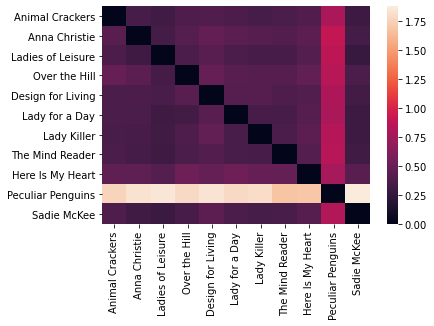

In [309]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

To reveal more patterns, let's do a multidimensional scaling of the matrix.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


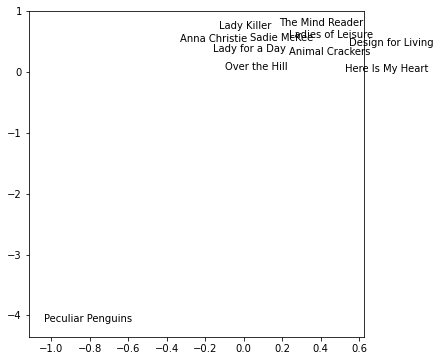

In [ ]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids):
    ax.annotate(txt, (x[i],y[i]))

A co-respondent's course and The Chain Gang are away from the others - any guesses why?

We may just want to focus on the distrbution of stopwords or non-stopwords. Let's do the analysis again first for stopwords and then for non-stopwords.

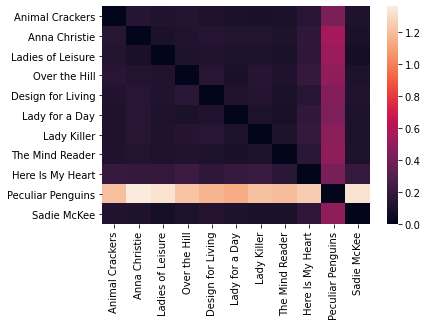

In [290]:
L = []
for p in corpora_s:
    l = []
    for q in corpora_s:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

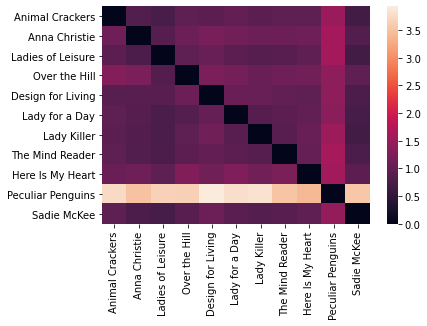

In [291]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

Now we compute the same for the assymmetric $\chi^2$ Divergence.

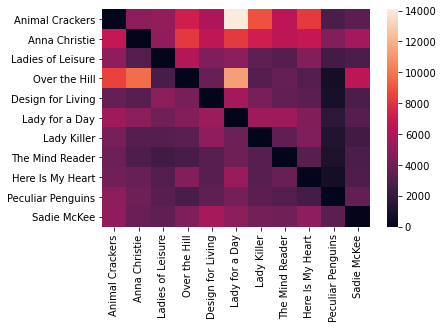

In [292]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Chi2'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

For the KS distance:

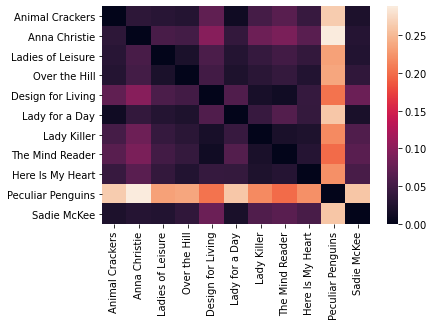

In [293]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

And finally for the Wasserstein or "earth mover's" Distance.

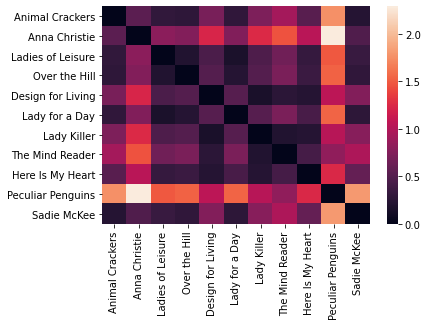

In [294]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

You can see that decade X is highly divergent and this makes reading the plot somewhat difficult. Let's fix this by taking the log of each cell, which will reduce the distance of decode X from other texts as an outlier.

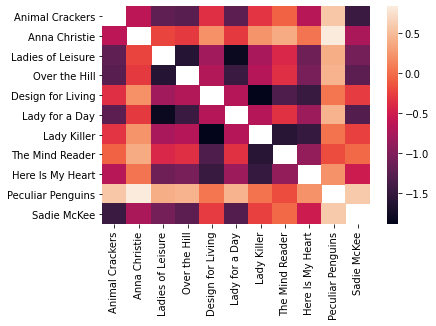

In [295]:
ax = sns.heatmap(div.apply(np.log).replace([np.inf, -np.inf], np.nan))
plt.show()

We only tried 11 movies, and from the same time period, so our signals might not be too interesting. What about different time periods?

An interesting experiment to maybe get some clearer signals: documents by decade in the Davies Corpus Of Historial American English (COHA) and see if we can detect patterns between them. 

If we want to rerun this on a new data set of our own composition, we can be a bit more efficient with our coding. Let's use the Shakespeare texts from last week as example. Here we again make use of our convenient `lucem_illud` functions, namely `loadTextDirectory`, which is found in [loaders.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/loaders.py). 

In [296]:
def loadTextDirectory(targetDir, encoding = 'utf-8'):
    text = []
    fileName = []

    for file in (file for file in os.scandir(targetDir) if file.is_file() and not file.name.startswith('.')):
        with open(file.path, encoding = encoding) as f:
            text.append(f.read())
        fileName.append(file.name)
    return pandas.DataFrame({'text' : text}, index = fileName)

In [297]:
shakespeare_df = lucem_illud.loadTextDirectory('../data/Shakespeare')

Now we stem and remove stopwords

In [298]:
shakespeare_df['tokenized_text'] = shakespeare_df['text'].apply(lambda x: word_tokenize(x))
shakespeare_df['normalized_tokens'] = shakespeare_df['tokenized_text'].apply(lambda x: normalizeTokens(x))

/Users/nyjiang/.local/lib/python3.8/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Create the corpus file and generate the heatmap:

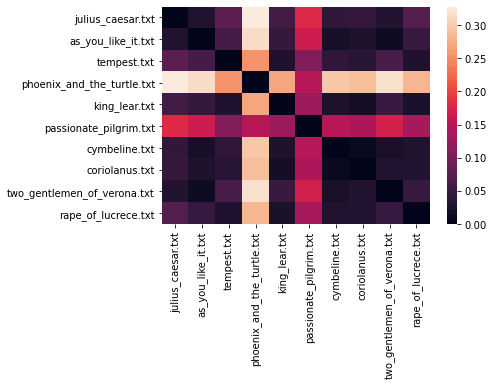

In [299]:
measure = 'KS' #"KL", "Chi2", "KS", "Wasserstein"
num_of_texts = 10 #The bigger this number the slower it will run, you can also try selecting your own plays
fileids_sp = list(shakespeare_df[:num_of_texts].index)
corpora_sp = list(shakespeare_df[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
ax = sns.heatmap(div)
plt.show()

What are "The Passionate Pilgrim" and "The Phoenix and the Turtle"? Little known poems by Shakespeare that are unsurprisingly hard to classify, as they are so different from everything else he wrote.

## <font color="red">*Exercise 7*</font>

<font color="red">Construct cells immediately below this that calculate the KL and $\chi^2$ divergences, and the KS and Wasserstein distances between four separate corpora, plot these with heatmaps, and then array them in two dimensions with multidimensional scaling as above. What does this reveal about relations between the corpora? Which analysis (and divergence or distribution) distinguishes the authors or documents better?

**Stretch**: Calculate the [Jensen-Shannon Divergence](https://en.wikipedia.org/wiki/Jensen–Shannon_divergence) between your four corpora. What is the relationship between the KL and JS divergences?</font> 

We begin by load two new corpora: TV and Wiki. 

1. TV corpus

In [340]:
tv = "/Users/nyjiang/Dropbox/Zips/TV" 
tv_raw = loadcorpus(tv)

text_13_idi.zip
text_16_qll.zip
text_32_ldf.zip
text_19_gvc.zip
text_09_jex.zip
text_05_nko.zip
text_17_arp.zip
text_01_ote.zip
text_28_rfy.zip
text_31_akv.zip
text_22_etp.zip
text_11_uoy.zip
text_14_lnc.zip
text_06_eyp.zip
text_08_loh.zip
text_33_kje.zip
text_30_wkp.zip
text_07_oma.zip
text_03_mnq.zip
text_21_fqa.zip
text_29_oye.zip
text_27_fle.zip
text_23_fmh.zip
text_12_rcq.zip
text_00_myn.zip
text_10_aoy.zip
text_04_mlq.zip
text_20_cde.zip
text_02_mqu.zip
text_26_ngj.zip
text_24_ywo.zip
text_18_jfj.zip
text_25_byg.zip
text_15_guo.zip


In [341]:
zfile_tv = zipfile.ZipFile(tv + "/sources_tv.zip")
source_tv = []
for file in zfile_tv.namelist():
    with zfile_tv.open(file) as f:
        for line in f:
            source_tv.append(line)
source_tv[0:10]

[b'textID\tfileID\t#words\tgenre\tyear\tcountry\tlanguage(s)\tseriesID\timdb\tseries\tepisodeTitle\r\n',
 b'-----\t-----\t-----\t-----\t-----\t-----\t-----\t-----\t-----\t------\t------\r\n',
 b'\r\n',
 b'2170814\t6814479\t4094\tComedy\t2012\tAustralia\tEnglish\t2170814\t2164274\tA Moody Christmas\tDecapod Crustaceans\r\n',
 b"2170806\t6814480\t4354\tComedy\t2012\tAustralia\tEnglish\t2170806\t2164274\tA Moody Christmas\tI'm Walt Roskow\r\n",
 b'2170796\t6814482\t3635\tComedy\t2012\tAustralia\tEnglish\t2170796\t2164274\tA Moody Christmas\tLast Minute Airfare\r\n',
 b'2170816\t6814478\t3969\tComedy\t2012\tAustralia\tEnglish\t2170816\t2164274\tA Moody Christmas\tOperation Sex Via the Homeless\r\n',
 b'2170800\t6814477\t4381\tComedy\t2012\tAustralia\tEnglish\t2170800\t2164274\tA Moody Christmas\tSeparate Seats\r\n',
 b'2170820\t6814481\t4191\tComedy\t2012\tAustralia\tEnglish\t2170820\t2164274\tA Moody Christmas\tWater Under the Bridge\r\n',
 b'2281428\t5789799\t4434\tDrama\t2013\tAustralia

In [342]:
tv_texts = {}
for files in tv_raw:
    if len(tv_texts) > 100:
        break
    # I use the clean function that I developed in exercise 1
    tvs = clean_raw_text(tv_raw[files][1:])
    for tv in tvs:
        txts = lucem_illud.word_tokenize(tv)
        try:
            tv_texts[txts[0][2:]] = txts[1:]
        except IndexError:
            continue

/Users/nyjiang/.local/lib/python3.8/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [343]:
tv_df = pd.DataFrame(columns=["TV Name", "Genre", "Year", "Country", "Tokenized Texts"])
for tv in source_tv[3:]:
    try:
        tid, fileid, total_words, genre, year, country, lang, seriesid, imdb, series, episodeTitle = tv.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    try:
        tv_df.loc[fileid.strip()] = [episodeTitle.strip(), genre.strip(), year.strip(), country.strip(), tv_texts[fileid.strip()]]
    except KeyError:
        continue

In [344]:
tv_df

TV Name                    Genre  Year  \
5790267              True to Your Heart                    Drama  2013   
5798187                  Auld Lang Syne                    Drama  2014   
5895982                Rainbow Warriors                    Drama  2010   
4074906  In the Hands of Giants: Part 2    Crime, Drama, Mystery  2007   
5732148                    Ballet Fever     Drama, Family, Music  2010   
...                                 ...                      ...   ...   
5597650       Everyone Knows It's Windy    Crime, Drama, Mystery  2009   
6800389                     Pride & Joy           Drama, History  2016   
4260356                Project Dawn #10  Action, Drama, Thriller  2011   
4222876                 Project Dawn #1  Action, Drama, Thriller  2011   
4223290                 Project Dawn #2  Action, Drama, Thriller  2011   

                       Country  \
5790267              Australia   
5798187              Australia   
5895982              Australia   
4074906              Australia   
5732148              Australia   
...                        ...   
5597650                USA, UK   
6800389                USA, UK   
4260356       USA, UK, Hungary   
4222876  USA, UK, South Africa   
4223290  USA, UK, South Africa   

                                           Tokenized Texts  
5790267  [You, 've, done, a, good, job, at, keeping, th...  
5798187  [@knock_at_door, Just, a, tick, I, ca, n't, I,...  
5895982  [G'day, darl, How, about, it, Where, did, you,...  
4074906  [Previously, on, City, Homicide, Physical, evi...  
5732148  [Previously, on, Dance, Academy, Welcome, to, ...  
...                                                    ...  
5597650  [SATELLITEOFLOVEplaying, Satellite, 's, gone, ...  
6800389  [Ask, my, daughters, to, come, and, see, me, Y...  
4260356  [Previously, on, Strike, Back, We, 've, recove...  
4222876  [ELECTRICITYZAPPING, GRUNTS, CAPTOR, YELLSINFO...  
4223290  [@crowd_chattering, KEYSRATTLING, Stonebridge,...  

[2093 rows x 5 columns]

In [366]:
tv_df['normalized_tokens'] = tv_df['Tokenized Texts'].apply(lambda x: normalizeTokens(x))

In [355]:
corpora_tv = []
for index, row in tv_df.iterrows():
    if len(corpora_tv) > 10:
        break
    corpora_tv.append(row['Tokenized Texts'])

In [357]:
len(corpora_tv)

11

In [358]:
fileids_tv = list(tv_df['TV Name'])[0:11]

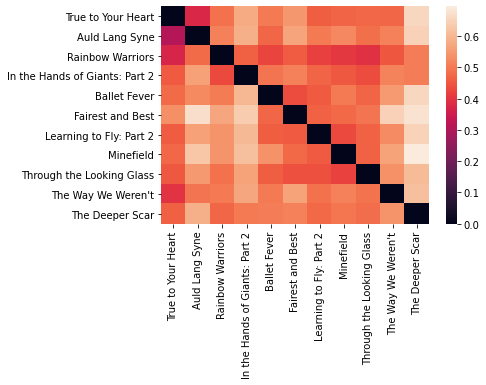

In [359]:
L = []
for p in corpora_tv:
    l = []
    for q in corpora_tv:
        l.append(Divergence(p,q, difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_tv, index = fileids_tv)
ax = sns.heatmap(div)
plt.show()

From the above heatmap, we can see that the distribution of divergences between different TV shows is relatively uniform. This is to say, there are no one or two shows that are significantly different from the others. "The Deeper Scar" may be the most distinguished one in this subset of shows. 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


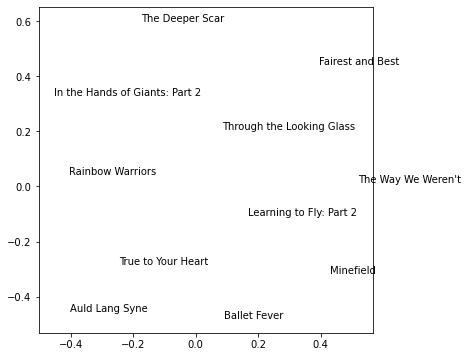

In [360]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids_tv):
    ax.annotate(txt, (x[i],y[i]))

This multi-dimensional scaling graph captures something similar with the heatmap. The distribution of divergences between different TV shows is relatively uniform

In [348]:
wiki = "/Users/nyjiang/Dropbox/Zips/Wiki" 
wiki_raw = loadcorpus(wiki)

text_09-vfd.zip
text_02-bnw.zip
text_01-pme.zip
text_07-lth.zip
text_05-jfy.zip
text_06-qvv.zip
text_04-bqd.zip
text_03-ucb.zip
text_08-qfx.zip
text_00-sng.zip


In [350]:
zfile_wiki = zipfile.ZipFile(wiki + "/wiki_sources.zip")
source_wiki = []
for file in zfile_wiki.namelist():
    with zfile_wiki.open(file) as f:
        for line in f:
            source_wiki.append(line)
source_wiki[0:10]

[b'textID\t#words\ttitle\r\n',
 b'----\t----\t----\r\n',
 b'\r\n',
 b'2\t672\t\r\n',
 b'12\t9400\tAnarchism\r\n',
 b'25\t7020\tAutism\r\n',
 b'39\t2348\tAlbedo\r\n',
 b'290\t1242\tA\r\n',
 b'303\t9369\tAlabama\r\n',
 b'305\t5359\tAchilles\r\n']

In [351]:
wiki_texts = {}
for files in wiki_raw:
    if len(wiki_texts) > 100:
        break
    # I use the clean function that I developed in exercise 1
    wikis = clean_raw_text(wiki_raw[files][1:])
    for wiki in wikis:
        txts = lucem_illud.word_tokenize(wiki)
        try:
            wiki_texts[txts[0][2:]] = txts[1:]
        except IndexError:
            continue

/Users/nyjiang/.local/lib/python3.8/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [353]:
wiki_df = pd.DataFrame(columns=["Wiki Title", "Tokenized Texts"])
for wiki in source_wiki[3:]:
    try:
        fileid, total_words, title = wiki.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    try:
        wiki_df.loc[fileid.strip()] = [title.strip(), wiki_texts[fileid.strip()]]
    except KeyError:
        continue

In [375]:
wiki_df['normalized_tokens'] = wiki_df['Tokenized Texts'].apply(lambda x: normalizeTokens(x))

In [354]:
corpora_wiki = []
for index, row in wiki_df.iterrows():
    if len(corpora_wiki) > 10:
        break
    corpora_wiki.append(row['Tokenized Texts'])

In [361]:
len(corpora_wiki)

11

In [362]:
fileids_wiki = list(wiki_df['Wiki Title'])[0:11]

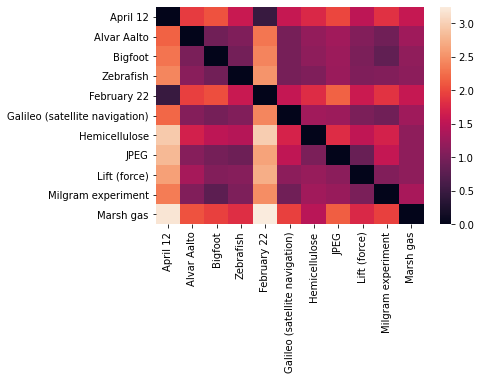

In [363]:
L = []
for p in corpora_wiki:
    l = []
    for q in corpora_wiki:
        l.append(Divergence(p,q, difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_wiki, index = fileids_wiki)
ax = sns.heatmap(div)
plt.show()

We can see that this heatmap is much more different from what we have seen in the TV corpus. First, the scales are different in these two heatmaps. Then, in the Wiki corpus, "April 12" and "February 22" are significantly different from the other topics, with lighter color in the graph. 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


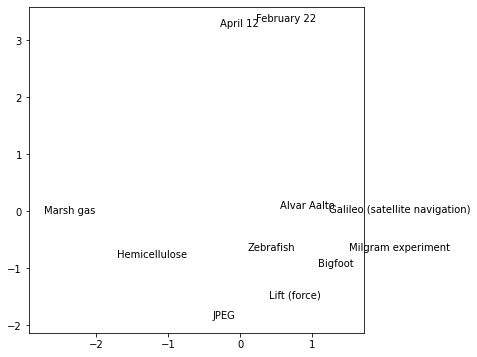

In [364]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids_wiki):
    ax.annotate(txt, (x[i],y[i]))

This multi-dimensional scaling graph captures something similar with the heatmap. "April 12" and "February 22" are significantly different from the other topics.

In [376]:
tvWords = set(tv_df['normalized_tokens'].sum())
wikiWords = set(wiki_df['normalized_tokens'].sum())

#Change & to | if you want to keep all words
overlapWords2 = tvWords & wikiWords

overlapWordsDict2 = {word: index for index, word in enumerate(overlapWords2)}
overlapWordsDict2['love']

6536

Here, we first calculate the KL divergence between tv and wiki:

In [377]:
tvProbArray = makeProbsArray(tv_df['normalized_tokens'], overlapWordsDict2)
wikiProbArray = makeProbsArray(wiki_df['normalized_tokens'], overlapWordsDict2)
tv_wikiDivergence = scipy.stats.entropy(tvProbArray, wikiProbArray)
print (tv_wikiDivergence)
wiki_tvDivergence = scipy.stats.entropy(wikiProbArray, tvProbArray)
print (wiki_tvDivergence)

1.424543143454472
1.1744867656568057


Note that the two KL divergence is assymmetric: one is 1.424543143454472 and the other is 1.1744867656568057. However, the Jensen–Shannon divergence is symmetric. It uses the KL divergence to calculate a normalized score that is symmetrical. This means that the divergence of P from Q is the same as Q from P. Given the KL divergence, we can calculate the JS divergence as follows:
JS(P || Q) = 1/2 * KL(P || M) + 1/2 * KL(Q || M), Where M is calculated as: M = 1/2 * (P + Q). I find it take too long time to load four corpora! So I just use these two external corpora to present my thinking. 